<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/NEW40dbmAP64_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 64
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.1, desired_action_stddev=0.1, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.01, buffer_size=10000, critic_lr=0.1, delta=0.2, drop_prob=0.4, gamma=0.99, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
10.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<09:48,  1.70episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -1.57 || Distance: nan ||
wsee: 0.0001661991048524716, eqwsee: 0.04703093556304132, reward: -1.572029739747625
|| Test Run No: 1100 || WSEE: 0.06167465646147229 || eq_WSEE: 0.03057012312579958 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.09091690364893736 || eq_WSEE: 0.04087244565717976 || Reward: 0.45 ||
|| Test Run No: 1140 || WSEE: 0.08050358419327144 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.08505041034141429 || eq_WSEE: 0.04660345054852954 || Reward: 0.34 ||
|| Test Run No: 1180 || WSEE: 0.061351694773972225 || eq_WSEE: 0.03851401073079608 || Reward: 0.35 ||
wsee:0.07252859054765531, fpa_wsee: 0.04278191159572484


  0%|          | 2/1000 [00:05<31:29,  1.89s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -2.29 || Distance: nan ||
wsee: 0.07846310183609496, eqwsee: 0.03673555125431262, reward: -2.2912547590805405


  0%|          | 3/1000 [00:05<24:15,  1.46s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: 1.26 || Distance: nan ||
wsee: 0.06751779115141919, eqwsee: 0.04316281848927427, reward: 1.261572297227397
|| Test Run No: 1100 || WSEE: 0.06660142832171995 || eq_WSEE: 0.03057012312579958 || Reward: 0.39 ||
|| Test Run No: 1120 || WSEE: 0.09091690364893736 || eq_WSEE: 0.04087244565717976 || Reward: 0.45 ||
|| Test Run No: 1140 || WSEE: 0.08050358419327144 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.08505041034141429 || eq_WSEE: 0.04660345054852954 || Reward: 0.34 ||
|| Test Run No: 1180 || WSEE: 0.061351694773972225 || eq_WSEE: 0.03851401073079608 || Reward: 0.35 ||
wsee:0.07257785826625779, fpa_wsee: 0.04278191159572484


  0%|          | 4/1000 [00:10<40:39,  2.45s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: 1.79 || Distance: nan ||
wsee: 0.07846310183609496, eqwsee: 0.03673555125431262, reward: 1.790020960922653


  0%|          | 5/1000 [00:11<30:44,  1.85s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: 2.54 || Distance: nan ||
wsee: 0.09244948243603125, eqwsee: 0.043158780530642815, reward: 2.5384419523870423
|| Test Run No: 1100 || WSEE: 0.06545717391637325 || eq_WSEE: 0.03057012312579958 || Reward: 0.35 ||
|| Test Run No: 1120 || WSEE: 0.09091690364893736 || eq_WSEE: 0.04087244565717976 || Reward: 0.45 ||
|| Test Run No: 1140 || WSEE: 0.08050358419327144 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.08505041034141429 || eq_WSEE: 0.04660345054852954 || Reward: 0.34 ||
|| Test Run No: 1180 || WSEE: 0.061351694773972225 || eq_WSEE: 0.03851401073079608 || Reward: 0.35 ||
wsee:0.07256641572220433, fpa_wsee: 0.04278191159572484


  1%|          | 6/1000 [00:15<45:19,  2.74s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: 1.38 || Distance: nan ||
wsee: 0.07846310183609496, eqwsee: 0.03673555125431262, reward: 1.382773279360068


  1%|          | 7/1000 [00:16<34:01,  2.06s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: 1.88 || Distance: nan ||
wsee: 0.07058846028841671, eqwsee: 0.03697775787500956, reward: 1.8811722924660228
|| Test Run No: 1100 || WSEE: 0.062116722717254685 || eq_WSEE: 0.03057012312579958 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.09091690364893736 || eq_WSEE: 0.04087244565717976 || Reward: 0.45 ||
|| Test Run No: 1140 || WSEE: 0.08050358419327144 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.08505041034141429 || eq_WSEE: 0.04660345054852954 || Reward: 0.34 ||
|| Test Run No: 1180 || WSEE: 0.061351694773972225 || eq_WSEE: 0.03851401073079608 || Reward: 0.35 ||
wsee:0.07253301121021315, fpa_wsee: 0.04278191159572484


  1%|          | 8/1000 [00:21<47:40,  2.88s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: 0.07 || Distance: nan ||
wsee: 0.07846310183609496, eqwsee: 0.03673555125431262, reward: 0.0679319640284802


  1%|          | 9/1000 [00:21<35:42,  2.16s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: 2.40 || Distance: nan ||
wsee: 0.08315455913588862, eqwsee: 0.04114680199320989, reward: 2.403513394669279
|| Test Run No: 1100 || WSEE: 0.06237035705846978 || eq_WSEE: 0.03057012312579958 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.09091690364893736 || eq_WSEE: 0.04087244565717976 || Reward: 0.45 ||
|| Test Run No: 1140 || WSEE: 0.08050358419327144 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.08505041034141429 || eq_WSEE: 0.04660345054852954 || Reward: 0.34 ||
|| Test Run No: 1180 || WSEE: 0.061351694773972225 || eq_WSEE: 0.03851401073079608 || Reward: 0.35 ||
wsee:0.07253554755362529, fpa_wsee: 0.04278191159572484


  1%|1         | 10/1000 [00:26<50:03,  3.03s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: 0.92 || Distance: nan ||
wsee: 0.07846310183609496, eqwsee: 0.03673555125431262, reward: 0.9172517418139183


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.07323890924453735|| Global step: 550 || Episode: 11 || Reward: 1.73 || Distance: 0.2112 ||
wsee: 0.07234372575151667, eqwsee: 0.040705872783120524, reward: 1.7271619516772252
|| Test Run No: 1100 || WSEE: 0.04739451697551987 || eq_WSEE: 0.03057012312579958 || Reward: 0.46 ||
|| Test Run No: 1120 || WSEE: 0.07342549762079012 || eq_WSEE: 0.04087244565717976 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.055697333841180224 || eq_WSEE: 0.03710408090963881 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.05994314098750973 || eq_WSEE: 0.04660345054852954 || Reward: -0.10 ||
|| Test Run No: 1180 || WSEE: 0.007950643949706305 || eq_WSEE: 0.03851401073079608 || Reward: -0.07 ||
wsee:0.03981414063552385, fpa_wsee: 0.04278191159572484


  1%|1         | 12/1000 [00:36<1:06:04,  4.01s/episode]

Loss: 0.07958070933818817|| Global step: 600 || Episode: 12 || Reward: 2.43 || Distance: 0.1477 ||
wsee: 0.05633279649380498, eqwsee: 0.03673555125431262, reward: 2.4336819766765796


  1%|1         | 13/1000 [00:37<54:07,  3.29s/episode]  

Loss: 0.11455578356981277|| Global step: 650 || Episode: 13 || Reward: 2.92 || Distance: 0.1086 ||
wsee: 0.10392639426555031, eqwsee: 0.04048991972384036, reward: 2.924552907507514
|| Test Run No: 1100 || WSEE: 0.050604091422050156 || eq_WSEE: 0.03057012312579958 || Reward: 0.46 ||
|| Test Run No: 1120 || WSEE: 0.07665123502089233 || eq_WSEE: 0.04087244565717976 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.06040680132078985 || eq_WSEE: 0.03710408090963881 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.06450398246447307 || eq_WSEE: 0.04660345054852954 || Reward: -0.01 ||
|| Test Run No: 1180 || WSEE: 0.008527485145257887 || eq_WSEE: 0.03851401073079608 || Reward: -0.04 ||
wsee:0.04420210235364818, fpa_wsee: 0.04278191159572484


  1%|1         | 14/1000 [00:43<1:07:33,  4.11s/episode]

Loss: 0.02327626943588257|| Global step: 700 || Episode: 14 || Reward: 2.91 || Distance: 0.3265 ||
wsee: 0.05822345167714087, eqwsee: 0.03673555125431262, reward: 2.9128545219739013


  2%|1         | 15/1000 [00:45<55:16,  3.37s/episode]  

Loss: 0.03810909390449524|| Global step: 750 || Episode: 15 || Reward: 3.24 || Distance: 0.1149 ||
wsee: 0.10603912103575135, eqwsee: 0.03793120079280128, reward: 3.2350236781978037
|| Test Run No: 1100 || WSEE: 0.06380744786844401 || eq_WSEE: 0.03057012312579958 || Reward: 0.54 ||
|| Test Run No: 1120 || WSEE: 0.08108947969996529 || eq_WSEE: 0.04087244565717976 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.06562644940909429 || eq_WSEE: 0.03710408090963881 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.07099763506451245 || eq_WSEE: 0.04660345054852954 || Reward: 0.11 ||
|| Test Run No: 1180 || WSEE: 0.009358310643604985 || eq_WSEE: 0.03851401073079608 || Reward: -0.01 ||
wsee:0.05212910348297733, fpa_wsee: 0.04278191159572484


  2%|1         | 16/1000 [00:51<1:08:33,  4.18s/episode]

Loss: 0.04019588977098465|| Global step: 800 || Episode: 16 || Reward: 3.74 || Distance: 0.0801 ||
wsee: 0.06382838756691554, eqwsee: 0.03673555125431262, reward: 3.7412158031422007


  2%|1         | 17/1000 [00:53<56:50,  3.47s/episode]  

Loss: 0.022473543882369995|| Global step: 850 || Episode: 17 || Reward: 2.89 || Distance: 0.3109 ||
wsee: 0.10034347877788187, eqwsee: 0.036331261593111404, reward: 2.8865864740577782
|| Test Run No: 1100 || WSEE: 0.06376193781804054 || eq_WSEE: 0.03057012312579958 || Reward: 0.52 ||
|| Test Run No: 1120 || WSEE: 0.08525627085181256 || eq_WSEE: 0.04087244565717976 || Reward: 0.37 ||
|| Test Run No: 1140 || WSEE: 0.07118913796526952 || eq_WSEE: 0.03710408090963881 || Reward: 0.32 ||
|| Test Run No: 1160 || WSEE: 0.07721362277760876 || eq_WSEE: 0.04660345054852954 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.010009188115808719 || eq_WSEE: 0.03851401073079608 || Reward: 0.02 ||
wsee:0.06078386625989113, fpa_wsee: 0.04278191159572484


  2%|1         | 18/1000 [00:59<1:10:09,  4.29s/episode]

Loss: 0.03495146706700325|| Global step: 900 || Episode: 18 || Reward: 3.57 || Distance: 0.1960 ||
wsee: 0.06975697459854929, eqwsee: 0.03673555125431262, reward: 3.569371050090024


  2%|1         | 19/1000 [01:01<57:18,  3.50s/episode]  

Loss: 0.06658577919006348|| Global step: 950 || Episode: 19 || Reward: 3.16 || Distance: 0.2564 ||
wsee: 0.1166928511295047, eqwsee: 0.04492342645493688, reward: 3.1610512275228198
|| Test Run No: 1100 || WSEE: 0.06749330226719796 || eq_WSEE: 0.03057012312579958 || Reward: 0.52 ||
|| Test Run No: 1120 || WSEE: 0.08965234819820166 || eq_WSEE: 0.04087244565717976 || Reward: 0.44 ||
|| Test Run No: 1140 || WSEE: 0.07510485484759126 || eq_WSEE: 0.03710408090963881 || Reward: 0.35 ||
|| Test Run No: 1160 || WSEE: 0.08336303090193753 || eq_WSEE: 0.04660345054852954 || Reward: 0.33 ||
|| Test Run No: 1180 || WSEE: 0.010491286495884333 || eq_WSEE: 0.03851401073079608 || Reward: 0.05 ||
wsee:0.07033132744246567, fpa_wsee: 0.04278191159572484


  2%|2         | 20/1000 [01:07<1:09:34,  4.26s/episode]

Loss: 0.0019783107563853264|| Global step: 1000 || Episode: 20 || Reward: 3.68 || Distance: 0.3110 ||
wsee: 0.0756225604644359, eqwsee: 0.03673555125431262, reward: 3.6765899894142384


  2%|2         | 21/1000 [01:09<57:14,  3.51s/episode]  

Loss: 0.02538602612912655|| Global step: 1050 || Episode: 21 || Reward: -1.20 || Distance: 0.1451 ||
wsee: 0.00014549985981212379, eqwsee: 0.042859925035620125, reward: -1.1955563032735332
|| Test Run No: 1100 || WSEE: 0.07560545816267197 || eq_WSEE: 0.03057012312579958 || Reward: 0.57 ||
|| Test Run No: 1120 || WSEE: 0.0933862945334535 || eq_WSEE: 0.04087244565717976 || Reward: 0.49 ||
|| Test Run No: 1140 || WSEE: 0.07824019741070545 || eq_WSEE: 0.03710408090963881 || Reward: 0.37 ||
|| Test Run No: 1160 || WSEE: 0.08829254734328906 || eq_WSEE: 0.04660345054852954 || Reward: 0.40 ||
|| Test Run No: 1180 || WSEE: 0.058222699293080535 || eq_WSEE: 0.03851401073079608 || Reward: 0.33 ||
wsee:0.07845210503092638, fpa_wsee: 0.04278191159572484


  2%|2         | 22/1000 [01:15<1:09:58,  4.29s/episode]

Loss: 0.044441383332014084|| Global step: 1100 || Episode: 22 || Reward: 2.57 || Distance: 0.2551 ||
wsee: 0.079341321014037, eqwsee: 0.03673555125431262, reward: 2.5743482904955726


  2%|2         | 23/1000 [01:16<57:36,  3.54s/episode]  

Loss: 0.031033724546432495|| Global step: 1150 || Episode: 23 || Reward: 3.66 || Distance: 0.2044 ||
wsee: 0.1270832199783966, eqwsee: 0.04590221609150737, reward: 3.664989789524985
|| Test Run No: 1100 || WSEE: 0.07845850250232225 || eq_WSEE: 0.03057012312579958 || Reward: 0.60 ||
|| Test Run No: 1120 || WSEE: 0.09616138047453722 || eq_WSEE: 0.04087244565717976 || Reward: 0.53 ||
|| Test Run No: 1140 || WSEE: 0.08069192951951765 || eq_WSEE: 0.03710408090963881 || Reward: 0.39 ||
|| Test Run No: 1160 || WSEE: 0.0921343907074175 || eq_WSEE: 0.04660345054852954 || Reward: 0.44 ||
|| Test Run No: 1180 || WSEE: 0.07413145873954281 || eq_WSEE: 0.03851401073079608 || Reward: 0.43 ||
wsee:0.08398060005507099, fpa_wsee: 0.04278191159572484
Model could have been saved!


  2%|2         | 24/1000 [01:23<1:10:40,  4.34s/episode]

Loss: 0.011667359620332718|| Global step: 1200 || Episode: 24 || Reward: 4.27 || Distance: 0.1195 ||
wsee: 0.08192117140330703, eqwsee: 0.03673555125431262, reward: 4.267244290578985


  2%|2         | 25/1000 [01:25<58:12,  3.58s/episode]  

Loss: 0.0355212539434433|| Global step: 1250 || Episode: 25 || Reward: 3.97 || Distance: 0.2536 ||
wsee: 0.13994273983766148, eqwsee: 0.04987884081861195, reward: 3.973712922815736
|| Test Run No: 1100 || WSEE: 0.08182282688962011 || eq_WSEE: 0.03057012312579958 || Reward: 0.62 ||
|| Test Run No: 1120 || WSEE: 0.09816540563177531 || eq_WSEE: 0.04087244565717976 || Reward: 0.56 ||
|| Test Run No: 1140 || WSEE: 0.08323666165083729 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.09505603173772881 || eq_WSEE: 0.04660345054852954 || Reward: 0.48 ||
|| Test Run No: 1180 || WSEE: 0.0878265873873322 || eq_WSEE: 0.03851401073079608 || Reward: 0.52 ||
wsee:0.08866067333349074, fpa_wsee: 0.04278191159572484
Model could have been saved!


  3%|2         | 26/1000 [01:31<1:09:50,  4.30s/episode]

Loss: 0.01013475377112627|| Global step: 1300 || Episode: 26 || Reward: 3.85 || Distance: 0.2522 ||
wsee: 0.08407496726365096, eqwsee: 0.03673555125431262, reward: 3.848666496966673


  3%|2         | 27/1000 [01:32<57:20,  3.54s/episode]  

Loss: 0.014871630817651749|| Global step: 1350 || Episode: 27 || Reward: 3.59 || Distance: 0.1032 ||
wsee: 0.12445864013126995, eqwsee: 0.045880264744544055, reward: 3.594068751348814
|| Test Run No: 1100 || WSEE: 0.0816284069465635 || eq_WSEE: 0.03057012312579958 || Reward: 0.60 ||
|| Test Run No: 1120 || WSEE: 0.09980330270476714 || eq_WSEE: 0.04087244565717976 || Reward: 0.58 ||
|| Test Run No: 1140 || WSEE: 0.08537295333957591 || eq_WSEE: 0.03710408090963881 || Reward: 0.43 ||
|| Test Run No: 1160 || WSEE: 0.09748106162619267 || eq_WSEE: 0.04660345054852954 || Reward: 0.51 ||
|| Test Run No: 1180 || WSEE: 0.09412563018296598 || eq_WSEE: 0.03851401073079608 || Reward: 0.57 ||
wsee:0.09200908410646255, fpa_wsee: 0.04278191159572484
Model could have been saved!


  3%|2         | 28/1000 [01:38<1:09:37,  4.30s/episode]

Loss: 0.019814508035779|| Global step: 1400 || Episode: 28 || Reward: 3.13 || Distance: 0.1667 ||
wsee: 0.08587579617587293, eqwsee: 0.03673555125431262, reward: 3.1317627435016386


  3%|2         | 29/1000 [01:40<57:30,  3.55s/episode]  

Loss: 0.006971942260861397|| Global step: 1450 || Episode: 29 || Reward: 4.02 || Distance: 0.2940 ||
wsee: 0.13258143589497273, eqwsee: 0.051499538811091324, reward: 4.018690409465597
|| Test Run No: 1100 || WSEE: 0.08331493799633602 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.10127318749302748 || eq_WSEE: 0.04087244565717976 || Reward: 0.59 ||
|| Test Run No: 1140 || WSEE: 0.08718267297680182 || eq_WSEE: 0.03710408090963881 || Reward: 0.44 ||
|| Test Run No: 1160 || WSEE: 0.09965071427359885 || eq_WSEE: 0.04660345054852954 || Reward: 0.53 ||
|| Test Run No: 1180 || WSEE: 0.09783003808735163 || eq_WSEE: 0.03851401073079608 || Reward: 0.59 ||
wsee:0.09475145294000989, fpa_wsee: 0.04278191159572484
Model could have been saved!


  3%|3         | 30/1000 [01:46<1:09:26,  4.30s/episode]

Loss: 0.0013970616273581982|| Global step: 1500 || Episode: 30 || Reward: 4.59 || Distance: 0.1415 ||
wsee: 0.08746801965523772, eqwsee: 0.03673555125431262, reward: 4.591262538756645


  3%|3         | 31/1000 [01:48<57:51,  3.58s/episode]  

Loss: 0.005988568998873234|| Global step: 1550 || Episode: 31 || Reward: 3.15 || Distance: 0.1565 ||
wsee: 0.11125803345915385, eqwsee: 0.041203567116753236, reward: 3.1455309411483365
|| Test Run No: 1100 || WSEE: 0.08040458433390846 || eq_WSEE: 0.03057012312579958 || Reward: 0.56 ||
|| Test Run No: 1120 || WSEE: 0.10252720183082467 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08861091608216434 || eq_WSEE: 0.03710408090963881 || Reward: 0.46 ||
|| Test Run No: 1160 || WSEE: 0.10151147174724873 || eq_WSEE: 0.04660345054852954 || Reward: 0.55 ||
|| Test Run No: 1180 || WSEE: 0.09992865819590718 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09681824668264415, fpa_wsee: 0.04278191159572484
Model could have been saved!


  3%|3         | 32/1000 [01:54<1:10:49,  4.39s/episode]

Loss: 0.004363220185041428|| Global step: 1600 || Episode: 32 || Reward: 3.31 || Distance: 0.1668 ||
wsee: 0.08866300434197716, eqwsee: 0.03673555125431262, reward: 3.3129143818324627


  3%|3         | 33/1000 [01:56<58:46,  3.65s/episode]  

Loss: 0.01444623339921236|| Global step: 1650 || Episode: 33 || Reward: 2.26 || Distance: 0.0501 ||
wsee: 0.09038102355916675, eqwsee: 0.04684791462663588, reward: 2.2583785922763786
|| Test Run No: 1100 || WSEE: 0.08682384712132873 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10351481965316989 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.08977537741798423 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10305520875638921 || eq_WSEE: 0.04660345054852954 || Reward: 0.57 ||
|| Test Run No: 1180 || WSEE: 0.10124079926534087 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09855495011961977, fpa_wsee: 0.04278191159572484
Model could have been saved!


  3%|3         | 34/1000 [02:02<1:10:51,  4.40s/episode]

Loss: 0.006280956324189901|| Global step: 1700 || Episode: 34 || Reward: 3.88 || Distance: 0.2469 ||
wsee: 0.08960780876540404, eqwsee: 0.03673555125431262, reward: 3.876822940459626


  4%|3         | 35/1000 [02:04<58:25,  3.63s/episode]  

Loss: 0.0062543656677007675|| Global step: 1750 || Episode: 35 || Reward: 3.20 || Distance: 0.1031 ||
wsee: 0.10926720528961288, eqwsee: 0.039148614879979615, reward: 3.2016915581470395
|| Test Run No: 1100 || WSEE: 0.08669688814990514 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10417277642931835 || eq_WSEE: 0.04087244565717976 || Reward: 0.63 ||
|| Test Run No: 1140 || WSEE: 0.0906360902609282 || eq_WSEE: 0.03710408090963881 || Reward: 0.48 ||
|| Test Run No: 1160 || WSEE: 0.10411383759767505 || eq_WSEE: 0.04660345054852954 || Reward: 0.58 ||
|| Test Run No: 1180 || WSEE: 0.1020295752368259 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.09977100902792632, fpa_wsee: 0.04278191159572484
Model could have been saved!


  4%|3         | 36/1000 [02:10<1:10:19,  4.38s/episode]

Loss: 0.0019266585586592555|| Global step: 1800 || Episode: 36 || Reward: 3.53 || Distance: 0.1926 ||
wsee: 0.09030839639346615, eqwsee: 0.03673555125431262, reward: 3.5289828670087218


  4%|3         | 37/1000 [02:12<58:10,  3.62s/episode]  

Loss: 0.0012227041879668832|| Global step: 1850 || Episode: 37 || Reward: 3.53 || Distance: 0.1540 ||
wsee: 0.11522075467824366, eqwsee: 0.04170905299214607, reward: 3.527924894426195
|| Test Run No: 1100 || WSEE: 0.0872449734045941 || eq_WSEE: 0.03057012312579958 || Reward: 0.62 ||
|| Test Run No: 1120 || WSEE: 0.104603869377213 || eq_WSEE: 0.04087244565717976 || Reward: 0.63 ||
|| Test Run No: 1140 || WSEE: 0.0912879650328593 || eq_WSEE: 0.03710408090963881 || Reward: 0.49 ||
|| Test Run No: 1160 || WSEE: 0.1048398546976818 || eq_WSEE: 0.04660345054852954 || Reward: 0.58 ||
|| Test Run No: 1180 || WSEE: 0.1024841818168279 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.10063147293833859, fpa_wsee: 0.04278191159572484
Model could have been saved!


  4%|3         | 38/1000 [02:18<1:09:48,  4.35s/episode]

Loss: 0.00211099605076015|| Global step: 1900 || Episode: 38 || Reward: 3.99 || Distance: 0.1867 ||
wsee: 0.09075613711230052, eqwsee: 0.03673555125431262, reward: 3.992562880782389


  4%|3         | 39/1000 [02:20<58:02,  3.62s/episode]  

Loss: 0.0023896810598671436|| Global step: 1950 || Episode: 39 || Reward: 3.22 || Distance: 0.1539 ||
wsee: 0.11074222135624827, eqwsee: 0.04012023905556075, reward: 3.2246255451803183
|| Test Run No: 1100 || WSEE: 0.07360904205452026 || eq_WSEE: 0.03057012312579958 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.10491518460475335 || eq_WSEE: 0.04087244565717976 || Reward: 0.63 ||
|| Test Run No: 1140 || WSEE: 0.09180258161318329 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.1053469140492692 || eq_WSEE: 0.04660345054852954 || Reward: 0.59 ||
|| Test Run No: 1180 || WSEE: 0.102795072899685 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.10110845643879955, fpa_wsee: 0.04278191159572484
Model could have been saved!


  4%|4         | 40/1000 [02:26<1:10:36,  4.41s/episode]

Loss: 0.001259434036910534|| Global step: 2000 || Episode: 40 || Reward: -0.42 || Distance: 0.1598 ||
wsee: 0.09109080486501017, eqwsee: 0.03673555125431262, reward: -0.41714310738455224


  4%|4         | 41/1000 [02:28<58:49,  3.68s/episode]  

Loss: 0.0020579975098371506|| Global step: 2050 || Episode: 41 || Reward: 3.65 || Distance: 0.2453 ||
wsee: 0.1222759307764971, eqwsee: 0.04391120693765316, reward: 3.6478922816965396
|| Test Run No: 1100 || WSEE: 0.0867109164673914 || eq_WSEE: 0.03057012312579958 || Reward: 0.62 ||
|| Test Run No: 1120 || WSEE: 0.10514829630616959 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09216416007632633 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.1057318220222562 || eq_WSEE: 0.04660345054852954 || Reward: 0.59 ||
|| Test Run No: 1180 || WSEE: 0.10301254781062683 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.10167863013171653, fpa_wsee: 0.04278191159572484
Model could have been saved!


  4%|4         | 42/1000 [02:35<1:10:39,  4.43s/episode]

Loss: 0.001108201453462243|| Global step: 2100 || Episode: 42 || Reward: 3.87 || Distance: 0.1256 ||
wsee: 0.09133443703065396, eqwsee: 0.03673555125431262, reward: 3.8661931204605766


  4%|4         | 43/1000 [02:37<58:39,  3.68s/episode]  

Loss: 0.0014134220546111465|| Global step: 2150 || Episode: 43 || Reward: 3.17 || Distance: 0.1236 ||
wsee: 0.11061910935443388, eqwsee: 0.03955810190181272, reward: 3.1701669175067866
|| Test Run No: 1100 || WSEE: 0.08326679279586491 || eq_WSEE: 0.03057012312579958 || Reward: 0.57 ||
|| Test Run No: 1120 || WSEE: 0.10529407542154788 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09241257415281931 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.10596898313443295 || eq_WSEE: 0.04660345054852954 || Reward: 0.59 ||
|| Test Run No: 1180 || WSEE: 0.10315860589547163 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10193246017489986, fpa_wsee: 0.04278191159572484
Model could have been saved!


  4%|4         | 44/1000 [02:43<1:10:48,  4.44s/episode]

Loss: 0.002684670966118574|| Global step: 2200 || Episode: 44 || Reward: 3.39 || Distance: 0.1550 ||
wsee: 0.09150356969445414, eqwsee: 0.03673555125431262, reward: 3.389703125635345


  4%|4         | 45/1000 [02:45<59:05,  3.71s/episode]  

Loss: 0.0009976192377507687|| Global step: 2250 || Episode: 45 || Reward: 3.49 || Distance: 0.2812 ||
wsee: 0.10898614396049465, eqwsee: 0.03887555707866281, reward: 3.485068995983592
|| Test Run No: 1100 || WSEE: 0.0882557581235674 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10536511012000264 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09252781207357874 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.10608540382086108 || eq_WSEE: 0.04660345054852954 || Reward: 0.60 ||
|| Test Run No: 1180 || WSEE: 0.10322520567468887 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10211824276400995, fpa_wsee: 0.04278191159572484
Model could have been saved!


  5%|4         | 46/1000 [02:51<1:10:49,  4.45s/episode]

Loss: 0.0018879820127040148|| Global step: 2300 || Episode: 46 || Reward: 2.74 || Distance: 0.1096 ||
wsee: 0.09158354400972075, eqwsee: 0.03673555125431262, reward: 2.737233042511402


  5%|4         | 47/1000 [02:53<58:54,  3.71s/episode]  

Loss: 0.0010858486639335752|| Global step: 2350 || Episode: 47 || Reward: -0.99 || Distance: 0.1208 ||
wsee: 0.00013149133128400724, eqwsee: 0.0392160770390473, reward: -0.9906073143619076
|| Test Run No: 1100 || WSEE: 0.08868308470940714 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10536377479038868 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09252618933833721 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.10608299504999258 || eq_WSEE: 0.04660345054852954 || Reward: 0.60 ||
|| Test Run No: 1180 || WSEE: 0.10322366201460939 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10211988717078826, fpa_wsee: 0.04278191159572484
Model could have been saved!


  5%|4         | 48/1000 [02:59<1:11:10,  4.49s/episode]

Loss: 0.001330982893705368|| Global step: 2400 || Episode: 48 || Reward: 2.98 || Distance: 0.2573 ||
wsee: 0.09158211566978629, eqwsee: 0.03673555125431262, reward: 2.98424784014627


  5%|4         | 49/1000 [03:01<59:17,  3.74s/episode]  

Loss: 0.001978021115064621|| Global step: 2450 || Episode: 49 || Reward: 3.50 || Distance: 0.0998 ||
wsee: 0.11603518317602053, eqwsee: 0.04544263657551913, reward: 3.5039529942620407
|| Test Run No: 1100 || WSEE: 0.07400580076396021 || eq_WSEE: 0.03057012312579958 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1052929919205189 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.0924068763034103 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.10596573916646507 || eq_WSEE: 0.04660345054852954 || Reward: 0.59 ||
|| Test Run No: 1180 || WSEE: 0.1031517233914332 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.1018340438675378, fpa_wsee: 0.04278191159572484
Model could have been saved!


  5%|5         | 50/1000 [03:07<1:10:52,  4.48s/episode]

Loss: 0.0016485443338751793|| Global step: 2500 || Episode: 50 || Reward: -0.85 || Distance: 0.0741 ||
wsee: 0.09150078496038135, eqwsee: 0.03673555125431262, reward: -0.8472743679831524


  5%|5         | 51/1000 [03:10<59:26,  3.76s/episode]  

Loss: 0.0013347642961889505|| Global step: 2550 || Episode: 51 || Reward: -0.67 || Distance: 0.1830 ||
wsee: 0.0004091936311922004, eqwsee: 0.03318986363753355, reward: -0.6692447011050039
|| Test Run No: 1100 || WSEE: 0.08842384065066046 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.1051588626947407 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09218472892962105 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.10574507230591848 || eq_WSEE: 0.04660345054852954 || Reward: 0.59 ||
|| Test Run No: 1180 || WSEE: 0.10300358401559004 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.10170057035116625, fpa_wsee: 0.04278191159572484
Model could have been saved!


  5%|5         | 52/1000 [03:16<1:11:05,  4.50s/episode]

Loss: 0.0014803842641413212|| Global step: 2600 || Episode: 52 || Reward: 2.42 || Distance: 0.1298 ||
wsee: 0.09134921676203064, eqwsee: 0.03673555125431262, reward: 2.421426218671994


  5%|5         | 53/1000 [03:18<59:19,  3.76s/episode]  

Loss: 0.0012969343224540353|| Global step: 2650 || Episode: 53 || Reward: 3.26 || Distance: 0.0876 ||
wsee: 0.11146936752979486, eqwsee: 0.04132880230650038, reward: 3.264646173622457
|| Test Run No: 1100 || WSEE: 0.07362937673751214 || eq_WSEE: 0.03057012312579958 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.10496015516253032 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09184967126822526 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.10541801137100786 || eq_WSEE: 0.04660345054852954 || Reward: 0.59 ||
|| Test Run No: 1180 || WSEE: 0.10276891281223409 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.10113790675693361, fpa_wsee: 0.04278191159572484
Model could have been saved!


  5%|5         | 54/1000 [03:24<1:11:05,  4.51s/episode]

Loss: 0.0016798025462776423|| Global step: 2700 || Episode: 54 || Reward: -1.00 || Distance: 0.0267 ||
wsee: 0.09112587047481052, eqwsee: 0.03673555125431262, reward: -0.9952028960748097


  6%|5         | 55/1000 [03:26<59:36,  3.78s/episode]  

Loss: 0.0034445631317794323|| Global step: 2750 || Episode: 55 || Reward: -1.19 || Distance: 0.0305 ||
wsee: 0.0004919876383451501, eqwsee: 0.04519353349152912, reward: -1.1947418244999028
|| Test Run No: 1100 || WSEE: 0.08524800025738201 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.10471236744136994 || eq_WSEE: 0.04087244565717976 || Reward: 0.63 ||
|| Test Run No: 1140 || WSEE: 0.0914384913759695 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.10501674986106438 || eq_WSEE: 0.04660345054852954 || Reward: 0.58 ||
|| Test Run No: 1180 || WSEE: 0.10247090940906138 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.10074107806748861, fpa_wsee: 0.04278191159572484
Model could have been saved!


  6%|5         | 56/1000 [03:32<1:11:14,  4.53s/episode]

Loss: 0.0020976597443223|| Global step: 2800 || Episode: 56 || Reward: 2.43 || Distance: 0.0673 ||
wsee: 0.09085899304603225, eqwsee: 0.03673555125431262, reward: 2.432482304535606


  6%|5         | 57/1000 [03:35<59:50,  3.81s/episode]  

Loss: 0.0015868357149884105|| Global step: 2850 || Episode: 57 || Reward: 3.55 || Distance: 0.0929 ||
wsee: 0.11220601683975454, eqwsee: 0.03977681388511204, reward: 3.5546655037147583
|| Test Run No: 1100 || WSEE: 0.07299721980706662 || eq_WSEE: 0.03057012312579958 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.10442911706386966 || eq_WSEE: 0.04087244565717976 || Reward: 0.63 ||
|| Test Run No: 1140 || WSEE: 0.09096160152165231 || eq_WSEE: 0.03710408090963881 || Reward: 0.49 ||
|| Test Run No: 1160 || WSEE: 0.10456624063244153 || eq_WSEE: 0.04660345054852954 || Reward: 0.58 ||
|| Test Run No: 1180 || WSEE: 0.10208685290989918 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.1000059699464227, fpa_wsee: 0.04278191159572484
Model could have been saved!


  6%|5         | 58/1000 [03:41<1:11:59,  4.59s/episode]

Loss: 0.002726567443460226|| Global step: 2900 || Episode: 58 || Reward: -0.14 || Distance: 0.0904 ||
wsee: 0.09054432745200305, eqwsee: 0.03673555125431262, reward: -0.1398610071656564


  6%|5         | 59/1000 [03:43<1:00:21,  3.85s/episode]

Loss: 0.0024983712937682867|| Global step: 2950 || Episode: 59 || Reward: 3.33 || Distance: 0.2074 ||
wsee: 0.11336970783388513, eqwsee: 0.040671312872985296, reward: 3.329728522726789
|| Test Run No: 1100 || WSEE: 0.08125803018517966 || eq_WSEE: 0.03057012312579958 || Reward: 0.55 ||
|| Test Run No: 1120 || WSEE: 0.1041373115369024 || eq_WSEE: 0.04087244565717976 || Reward: 0.63 ||
|| Test Run No: 1140 || WSEE: 0.09051894879194436 || eq_WSEE: 0.03710408090963881 || Reward: 0.48 ||
|| Test Run No: 1160 || WSEE: 0.10410236950871815 || eq_WSEE: 0.04660345054852954 || Reward: 0.58 ||
|| Test Run No: 1180 || WSEE: 0.101640380499986 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09944083919092601, fpa_wsee: 0.04278191159572484
Model could have been saved!


  6%|6         | 60/1000 [03:49<1:11:56,  4.59s/episode]

Loss: 0.002518168417736888|| Global step: 3000 || Episode: 60 || Reward: 4.11 || Distance: 0.0939 ||
wsee: 0.09022294950723703, eqwsee: 0.03673555125431262, reward: 4.10574234199941


  6%|6         | 61/1000 [03:52<1:00:19,  3.85s/episode]

Loss: 0.005918553099036217|| Global step: 3050 || Episode: 61 || Reward: 3.42 || Distance: 0.0870 ||
wsee: 0.11240581017515255, eqwsee: 0.039746636099486816, reward: 3.4212214345588277
|| Test Run No: 1100 || WSEE: 0.07234164682876287 || eq_WSEE: 0.03057012312579958 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.10388471308286285 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.09013002895691674 || eq_WSEE: 0.03710408090963881 || Reward: 0.48 ||
|| Test Run No: 1160 || WSEE: 0.10370651062856669 || eq_WSEE: 0.04660345054852954 || Reward: 0.57 ||
|| Test Run No: 1180 || WSEE: 0.10122743539735822 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09877263600643683, fpa_wsee: 0.04278191159572484
Model could have been saved!


  6%|6         | 62/1000 [03:58<1:12:14,  4.62s/episode]

Loss: 0.006401245016604662|| Global step: 3100 || Episode: 62 || Reward: -0.46 || Distance: 0.0896 ||
wsee: 0.08995921317428417, eqwsee: 0.03673555125431262, reward: -0.4616007328743794


  6%|6         | 63/1000 [04:00<1:00:45,  3.89s/episode]

Loss: 0.00801999494433403|| Global step: 3150 || Episode: 63 || Reward: 2.58 || Distance: 0.0349 ||
wsee: 0.08397757260679033, eqwsee: 0.032397532583934796, reward: 2.5802383835515665
|| Test Run No: 1100 || WSEE: 0.08436399795056992 || eq_WSEE: 0.03057012312579958 || Reward: 0.60 ||
|| Test Run No: 1120 || WSEE: 0.10364363189555023 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.0897780538488042 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10332607713721179 || eq_WSEE: 0.04660345054852954 || Reward: 0.57 ||
|| Test Run No: 1180 || WSEE: 0.10082517704004708 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09836759990592991, fpa_wsee: 0.04278191159572484
Model could have been saved!


  6%|6         | 64/1000 [04:07<1:12:28,  4.65s/episode]

Loss: 0.0068464335054159164|| Global step: 3200 || Episode: 64 || Reward: 3.13 || Distance: 0.2319 ||
wsee: 0.08970742966252296, eqwsee: 0.03673555125431262, reward: 3.1267177925645653


  6%|6         | 65/1000 [04:09<1:01:13,  3.93s/episode]

Loss: 0.001789337256923318|| Global step: 3250 || Episode: 65 || Reward: -0.83 || Distance: 0.0597 ||
wsee: 0.00040175883666409705, eqwsee: 0.043299698323093765, reward: -0.8269377776940914
|| Test Run No: 1100 || WSEE: 0.08348196420890919 || eq_WSEE: 0.03057012312579958 || Reward: 0.60 ||
|| Test Run No: 1120 || WSEE: 0.10349222886339109 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.089559122622167 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10308467392476364 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.10055085485124594 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09802349006979476, fpa_wsee: 0.04278191159572484
Model could have been saved!


  7%|6         | 66/1000 [04:15<1:13:29,  4.72s/episode]

Loss: 0.005784195847809315|| Global step: 3300 || Episode: 66 || Reward: 2.72 || Distance: 0.1770 ||
wsee: 0.08955184842672953, eqwsee: 0.03673555125431262, reward: 2.722444017055164


  7%|6         | 67/1000 [04:18<1:02:08,  4.00s/episode]

Loss: 0.004785058554261923|| Global step: 3350 || Episode: 67 || Reward: 4.35 || Distance: 0.1584 ||
wsee: 0.13749848304150275, eqwsee: 0.04898017628730119, reward: 4.350265991636422
|| Test Run No: 1100 || WSEE: 0.08612586472617959 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10336923454898334 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.08938137277323188 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10289262593134427 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.1003121025768233 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09777424443100989, fpa_wsee: 0.04278191159572484
Model could have been saved!


  7%|6         | 68/1000 [04:24<1:14:03,  4.77s/episode]

Loss: 0.0016350836958736181|| Global step: 3400 || Episode: 68 || Reward: 3.97 || Distance: 0.1089 ||
wsee: 0.08942159509080233, eqwsee: 0.03673555125431262, reward: 3.9719657371833077


  7%|6         | 69/1000 [04:27<1:02:46,  4.05s/episode]

Loss: 0.010826798155903816|| Global step: 3450 || Episode: 69 || Reward: 3.41 || Distance: 0.1566 ||
wsee: 0.12385076977482964, eqwsee: 0.04552950431108758, reward: 3.407615727776156
|| Test Run No: 1100 || WSEE: 0.08588573566958854 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10326682968686575 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.08924032056335243 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10274394255231895 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.10012328318254951 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09755010969429562, fpa_wsee: 0.04278191159572484
Model could have been saved!


  7%|7         | 70/1000 [04:33<1:14:50,  4.83s/episode]

Loss: 0.00426515843719244|| Global step: 3500 || Episode: 70 || Reward: 4.60 || Distance: 0.1885 ||
wsee: 0.08931745595187231, eqwsee: 0.03673555125431262, reward: 4.598246759381287


  7%|7         | 71/1000 [04:36<1:03:10,  4.08s/episode]

Loss: 0.011155274696648121|| Global step: 3550 || Episode: 71 || Reward: 3.22 || Distance: 0.1377 ||
wsee: 0.10457356494920905, eqwsee: 0.03790320988020237, reward: 3.219590648268396
|| Test Run No: 1100 || WSEE: 0.07158150115789379 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.10320346219234529 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.08915669059548068 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10265270245500846 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.09999563184143923 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09726491200454705, fpa_wsee: 0.04278191159572484
Model could have been saved!


  7%|7         | 72/1000 [04:42<1:15:07,  4.86s/episode]

Loss: 0.005733215715736151|| Global step: 3600 || Episode: 72 || Reward: -1.02 || Distance: 0.1000 ||
wsee: 0.08925600689505014, eqwsee: 0.03673555125431262, reward: -1.0213077325564328


  7%|7         | 73/1000 [04:45<1:03:38,  4.12s/episode]

Loss: 0.0020293230190873146|| Global step: 3650 || Episode: 73 || Reward: 3.05 || Distance: 0.1812 ||
wsee: 0.10095518975421378, eqwsee: 0.03691579638081437, reward: 3.0507374115345227
|| Test Run No: 1100 || WSEE: 0.07154311324840812 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.10316447578936724 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.08910420272919711 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10259702902899805 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.09991979066581348 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09717840386133558, fpa_wsee: 0.04278191159572484
Model could have been saved!


  7%|7         | 74/1000 [04:51<1:15:37,  4.90s/episode]

Loss: 0.005701490677893162|| Global step: 3700 || Episode: 74 || Reward: -0.80 || Distance: 0.1065 ||
wsee: 0.08921786478704308, eqwsee: 0.03673555125431262, reward: -0.7971538540808399


  8%|7         | 75/1000 [04:54<1:04:04,  4.16s/episode]

Loss: 0.01651187427341938|| Global step: 3750 || Episode: 75 || Reward: 3.57 || Distance: 0.1368 ||
wsee: 0.11484444655132227, eqwsee: 0.04464634075699209, reward: 3.566472207458865
|| Test Run No: 1100 || WSEE: 0.07153167157975643 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1031524202953625 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08908834751826702 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.1025793546071948 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.09989621535324539 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09715246980749322, fpa_wsee: 0.04278191159572484
Model could have been saved!


  8%|7         | 76/1000 [05:00<1:15:45,  4.92s/episode]

Loss: 0.00117893994320184|| Global step: 3800 || Episode: 76 || Reward: -1.27 || Distance: 0.0459 ||
wsee: 0.08920603556417808, eqwsee: 0.03673555125431262, reward: -1.2703541874344741


  8%|7         | 77/1000 [05:03<1:04:14,  4.18s/episode]

Loss: 0.012676779180765152|| Global step: 3850 || Episode: 77 || Reward: -1.46 || Distance: 0.0340 ||
wsee: 0.00013565948715323038, eqwsee: 0.0450356519789658, reward: -1.4593636700214443
|| Test Run No: 1100 || WSEE: 0.08473904224027655 || eq_WSEE: 0.03057012312579958 || Reward: 0.62 ||
|| Test Run No: 1120 || WSEE: 0.10314986113115342 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08908491979684836 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10257550284743269 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.09989108977432476 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09727912988953703, fpa_wsee: 0.04278191159572484
Model could have been saved!


  8%|7         | 78/1000 [05:10<1:16:13,  4.96s/episode]

Loss: 0.008707749657332897|| Global step: 3900 || Episode: 78 || Reward: 2.83 || Distance: 0.0993 ||
wsee: 0.08920340729508579, eqwsee: 0.03673555125431262, reward: 2.828090034702959


  8%|7         | 79/1000 [05:12<1:04:47,  4.22s/episode]

Loss: 0.006523583550006151|| Global step: 3950 || Episode: 79 || Reward: -0.87 || Distance: 0.0527 ||
wsee: 0.00017774710152835773, eqwsee: 0.043202610928922365, reward: -0.8663913250682039
|| Test Run No: 1100 || WSEE: 0.08391218688376931 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.10314839974375978 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08908319652079444 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10257323939324389 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.09988862334278527 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09726812600683322, fpa_wsee: 0.04278191159572484
Model could have been saved!


  8%|8         | 80/1000 [05:19<1:17:02,  5.02s/episode]

Loss: 0.014212111011147499|| Global step: 4000 || Episode: 80 || Reward: 2.73 || Distance: 0.0948 ||
wsee: 0.08920198083735205, eqwsee: 0.03673555125431262, reward: 2.7336360477602346


  8%|8         | 81/1000 [05:22<1:05:18,  4.26s/episode]

Loss: 0.012126483023166656|| Global step: 4050 || Episode: 81 || Reward: -1.27 || Distance: 0.0681 ||
wsee: 0.00010202348800520509, eqwsee: 0.04439359708890297, reward: -1.2720648486032038
|| Test Run No: 1100 || WSEE: 0.07152779615167677 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.10314791558432501 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08908270466654261 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10257246392388843 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.09988799528302139 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09714351645146627, fpa_wsee: 0.04278191159572484
Model could have been saved!


  8%|8         | 82/1000 [05:28<1:17:16,  5.05s/episode]

Loss: 0.01251746341586113|| Global step: 4100 || Episode: 82 || Reward: -2.32 || Distance: 0.0255 ||
wsee: 0.08920148271206038, eqwsee: 0.03673555125431262, reward: -2.3159720284643286


  8%|8         | 83/1000 [05:31<1:05:35,  4.29s/episode]

Loss: 0.02271886356174946|| Global step: 4150 || Episode: 83 || Reward: -1.41 || Distance: 0.1765 ||
wsee: 0.00022628826853303196, eqwsee: 0.04273685598194884, reward: -1.4071098383490543
|| Test Run No: 1100 || WSEE: 0.08556044189312124 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10314991362789117 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08908578460437591 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10257503872969634 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.09989123420191018 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09728809445343875, fpa_wsee: 0.04278191159572484
Model could have been saved!


  8%|8         | 84/1000 [05:38<1:17:06,  5.05s/episode]

Loss: 0.009646004065871239|| Global step: 4200 || Episode: 84 || Reward: 3.08 || Distance: 0.0607 ||
wsee: 0.08920363218180019, eqwsee: 0.03673555125431262, reward: 3.083237495401067


  8%|8         | 85/1000 [05:40<1:05:40,  4.31s/episode]

Loss: 0.009346650913357735|| Global step: 4250 || Episode: 85 || Reward: 3.37 || Distance: 0.1492 ||
wsee: 0.1210510317999503, eqwsee: 0.04469385138835534, reward: 3.372355529981569
|| Test Run No: 1100 || WSEE: 0.07187441490711341 || eq_WSEE: 0.03057012312579958 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1034900493349056 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.08955742070280165 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.10307261199733639 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.10056475419705731 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09792350222130103, fpa_wsee: 0.04278191159572484
Model could have been saved!


  9%|8         | 86/1000 [05:47<1:17:08,  5.06s/episode]

Loss: 0.012543956749141216|| Global step: 4300 || Episode: 86 || Reward: -0.70 || Distance: 0.1168 ||
wsee: 0.08955574026871674, eqwsee: 0.03673555125431262, reward: -0.7005628325807968


  9%|8         | 87/1000 [05:50<1:05:33,  4.31s/episode]

Loss: 0.010036074556410313|| Global step: 4350 || Episode: 87 || Reward: -1.40 || Distance: 0.0187 ||
wsee: 0.00019515571961686184, eqwsee: 0.04964299898432596, reward: -1.396161910181664
|| Test Run No: 1100 || WSEE: 0.088189562270451 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10550975456450522 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09276523594181914 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.10626948483202603 || eq_WSEE: 0.04660345054852954 || Reward: 0.60 ||
|| Test Run No: 1180 || WSEE: 0.10326542804949826 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10239435899331109, fpa_wsee: 0.04278191159572484
Model could have been saved!


  9%|8         | 88/1000 [05:57<1:17:16,  5.08s/episode]

Loss: 0.003461082000285387|| Global step: 4400 || Episode: 88 || Reward: 3.66 || Distance: 0.0986 ||
wsee: 0.09176947307110749, eqwsee: 0.03673555125431262, reward: 3.6611723788162833


  9%|8         | 89/1000 [05:59<1:06:28,  4.38s/episode]

Loss: 0.014673170633614063|| Global step: 4450 || Episode: 89 || Reward: -0.69 || Distance: 0.0882 ||
wsee: 0.00021390140950905032, eqwsee: 0.03557159252990544, reward: -0.6928232706110374
|| Test Run No: 1100 || WSEE: 0.08920086466056304 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10615368829895791 || eq_WSEE: 0.04087244565717976 || Reward: 0.65 ||
|| Test Run No: 1140 || WSEE: 0.09375782722454576 || eq_WSEE: 0.03710408090963881 || Reward: 0.53 ||
|| Test Run No: 1160 || WSEE: 0.10735837008552152 || eq_WSEE: 0.04660345054852954 || Reward: 0.61 ||
|| Test Run No: 1180 || WSEE: 0.10382525634940212 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10360751624552263, fpa_wsee: 0.04278191159572484
Model could have been saved!


  9%|9         | 90/1000 [06:06<1:18:44,  5.19s/episode]

Loss: 0.007226461544632912|| Global step: 4500 || Episode: 90 || Reward: 2.82 || Distance: 0.1719 ||
wsee: 0.09247034869937916, eqwsee: 0.03673555125431262, reward: 2.8152766702701038


  9%|9         | 91/1000 [06:09<1:07:01,  4.42s/episode]

Loss: 0.007308647967875004|| Global step: 4550 || Episode: 91 || Reward: -0.88 || Distance: 0.0458 ||
wsee: 0.0005766095415516126, eqwsee: 0.03994247307530046, reward: -0.8832028922557343
|| Test Run No: 1100 || WSEE: 0.08921979774609196 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10617809966053623 || eq_WSEE: 0.04087244565717976 || Reward: 0.65 ||
|| Test Run No: 1140 || WSEE: 0.09380406066801854 || eq_WSEE: 0.03710408090963881 || Reward: 0.53 ||
|| Test Run No: 1160 || WSEE: 0.10740521393984055 || eq_WSEE: 0.04660345054852954 || Reward: 0.61 ||
|| Test Run No: 1180 || WSEE: 0.10385743970730765 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10375396355356242, fpa_wsee: 0.04278191159572484
Model could have been saved!


  9%|9         | 92/1000 [06:16<1:18:43,  5.20s/episode]

Loss: 0.002793611492961645|| Global step: 4600 || Episode: 92 || Reward: 2.82 || Distance: 0.1584 ||
wsee: 0.09250362878434958, eqwsee: 0.03673555125431262, reward: 2.8204868404233214


  9%|9         | 93/1000 [06:19<1:07:04,  4.44s/episode]

Loss: 0.007344363257288933|| Global step: 4650 || Episode: 93 || Reward: 3.95 || Distance: 0.1774 ||
wsee: 0.1258340745747658, eqwsee: 0.04598276995856584, reward: 3.9496430394348647
|| Test Run No: 1100 || WSEE: 0.07471641600653711 || eq_WSEE: 0.03057012312579958 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.10617794857118536 || eq_WSEE: 0.04087244565717976 || Reward: 0.65 ||
|| Test Run No: 1140 || WSEE: 0.09373028290296331 || eq_WSEE: 0.03710408090963881 || Reward: 0.53 ||
|| Test Run No: 1160 || WSEE: 0.10741236017344617 || eq_WSEE: 0.04660345054852954 || Reward: 0.61 ||
|| Test Run No: 1180 || WSEE: 0.10386204448876599 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10355231112158453, fpa_wsee: 0.04278191159572484
Model could have been saved!


  9%|9         | 94/1000 [06:26<1:18:47,  5.22s/episode]

Loss: 0.007796665653586388|| Global step: 4700 || Episode: 94 || Reward: -0.64 || Distance: 0.0180 ||
wsee: 0.09247481743852587, eqwsee: 0.03673555125431262, reward: -0.6361200288172889


 10%|9         | 95/1000 [06:29<1:07:22,  4.47s/episode]

Loss: 0.010165143758058548|| Global step: 4750 || Episode: 95 || Reward: 3.83 || Distance: 0.0668 ||
wsee: 0.11843849617270433, eqwsee: 0.04167741468542305, reward: 3.826414831612694
|| Test Run No: 1100 || WSEE: 0.08548914206988725 || eq_WSEE: 0.03057012312579958 || Reward: 0.60 ||
|| Test Run No: 1120 || WSEE: 0.10614421773321031 || eq_WSEE: 0.04087244565717976 || Reward: 0.65 ||
|| Test Run No: 1140 || WSEE: 0.09370587411005141 || eq_WSEE: 0.03710408090963881 || Reward: 0.53 ||
|| Test Run No: 1160 || WSEE: 0.10733248380414762 || eq_WSEE: 0.04660345054852954 || Reward: 0.61 ||
|| Test Run No: 1180 || WSEE: 0.1038769825752284 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10375436519993297, fpa_wsee: 0.04278191159572484
Model could have been saved!


 10%|9         | 96/1000 [06:36<1:19:26,  5.27s/episode]

Loss: 0.007165504619479179|| Global step: 4800 || Episode: 96 || Reward: 3.62 || Distance: 0.0862 ||
wsee: 0.0924361946560498, eqwsee: 0.03673555125431262, reward: 3.621883909777953


 10%|9         | 97/1000 [06:38<1:07:54,  4.51s/episode]

Loss: 0.012550859712064266|| Global step: 4850 || Episode: 97 || Reward: -1.37 || Distance: 0.1646 ||
wsee: 8.272487641557026e-05, eqwsee: 0.04163849879420572, reward: -1.3678808762328618
|| Test Run No: 1100 || WSEE: 0.08777901193959853 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.10634184088031948 || eq_WSEE: 0.04087244565717976 || Reward: 0.65 ||
|| Test Run No: 1140 || WSEE: 0.09402550140154425 || eq_WSEE: 0.03710408090963881 || Reward: 0.53 ||
|| Test Run No: 1160 || WSEE: 0.10768022804745983 || eq_WSEE: 0.04660345054852954 || Reward: 0.61 ||
|| Test Run No: 1180 || WSEE: 0.10404255221819382 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10442418722207872, fpa_wsee: 0.04278191159572484
Model could have been saved!


 10%|9         | 98/1000 [06:46<1:19:42,  5.30s/episode]

Loss: 0.007768972776830196|| Global step: 4900 || Episode: 98 || Reward: 3.42 || Distance: 0.2046 ||
wsee: 0.09267701061551296, eqwsee: 0.03673555125431262, reward: 3.4183635748716847


 10%|9         | 99/1000 [06:48<1:07:56,  4.52s/episode]

Loss: 0.009835382923483849|| Global step: 4950 || Episode: 99 || Reward: 3.47 || Distance: 0.1328 ||
wsee: 0.11144656972677702, eqwsee: 0.04121744305048493, reward: 3.468068887298444
|| Test Run No: 1100 || WSEE: 0.07533389067472873 || eq_WSEE: 0.03057012312579958 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.106782720604858 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09461701412632054 || eq_WSEE: 0.03710408090963881 || Reward: 0.54 ||
|| Test Run No: 1160 || WSEE: 0.10846310183859201 || eq_WSEE: 0.04660345054852954 || Reward: 0.62 ||
|| Test Run No: 1180 || WSEE: 0.10439973666699953 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10526396022759721, fpa_wsee: 0.04278191159572484
Model could have been saved!


 10%|#         | 100/1000 [06:56<1:20:23,  5.36s/episode]

Loss: 0.0015179391484707594|| Global step: 5000 || Episode: 100 || Reward: -0.96 || Distance: 0.0380 ||
wsee: 0.09317213309883288, eqwsee: 0.03673555125431262, reward: -0.9623999819612361


 10%|#         | 101/1000 [06:58<1:08:41,  4.58s/episode]

Loss: 0.019364673644304276|| Global step: 5050 || Episode: 101 || Reward: 3.05 || Distance: 0.2582 ||
wsee: 0.1015479546009443, eqwsee: 0.03889284300674203, reward: 3.0465106122743575
|| Test Run No: 1100 || WSEE: 0.08963691364646006 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10679637938233916 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09462626605227674 || eq_WSEE: 0.03710408090963881 || Reward: 0.54 ||
|| Test Run No: 1160 || WSEE: 0.10848979310299624 || eq_WSEE: 0.04660345054852954 || Reward: 0.62 ||
|| Test Run No: 1180 || WSEE: 0.1044103206862276 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10542387279179703, fpa_wsee: 0.04278191159572484
Model could have been saved!


 10%|#         | 102/1000 [07:06<1:22:00,  5.48s/episode]

Loss: 0.008149012923240662|| Global step: 5100 || Episode: 102 || Reward: 3.76 || Distance: 0.1668 ||
wsee: 0.09318638553179602, eqwsee: 0.03673555125431262, reward: 3.7612918100323895


 10%|#         | 103/1000 [07:09<1:10:35,  4.72s/episode]

Loss: 0.016412751749157906|| Global step: 5150 || Episode: 103 || Reward: 4.28 || Distance: 0.1791 ||
wsee: 0.13992318355033614, eqwsee: 0.05032897876469701, reward: 4.278965576805881
|| Test Run No: 1100 || WSEE: 0.08767913341315536 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10674269600076321 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09456174929171232 || eq_WSEE: 0.03710408090963881 || Reward: 0.54 ||
|| Test Run No: 1160 || WSEE: 0.10839563835199019 || eq_WSEE: 0.04660345054852954 || Reward: 0.62 ||
|| Test Run No: 1180 || WSEE: 0.10437616747397896 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10530227769015353, fpa_wsee: 0.04278191159572484
Model could have been saved!


 10%|#         | 104/1000 [07:16<1:22:08,  5.50s/episode]

Loss: 0.008180596865713596|| Global step: 5200 || Episode: 104 || Reward: 4.49 || Distance: 0.1279 ||
wsee: 0.0931320559900579, eqwsee: 0.03673555125431262, reward: 4.489967478048143


 10%|#         | 105/1000 [07:19<1:10:19,  4.71s/episode]

Loss: 0.008004868403077126|| Global step: 5250 || Episode: 105 || Reward: 3.44 || Distance: 0.0892 ||
wsee: 0.10550226008108783, eqwsee: 0.037417799863670186, reward: 3.4401221388533445
|| Test Run No: 1100 || WSEE: 0.08977751840524162 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10682165237219259 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09466428690267747 || eq_WSEE: 0.03710408090963881 || Reward: 0.54 ||
|| Test Run No: 1160 || WSEE: 0.10853677100521478 || eq_WSEE: 0.04660345054852954 || Reward: 0.62 ||
|| Test Run No: 1180 || WSEE: 0.10442988557819616 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10547457623235683, fpa_wsee: 0.04278191159572484
Model could have been saved!


 11%|#         | 106/1000 [07:26<1:21:53,  5.50s/episode]

Loss: 0.015265322290360928|| Global step: 5300 || Episode: 106 || Reward: 3.92 || Distance: 0.0796 ||
wsee: 0.09321720359590398, eqwsee: 0.03673555125431262, reward: 3.9243460911826347


 11%|#         | 107/1000 [07:29<1:10:15,  4.72s/episode]

Loss: 0.025167763233184814|| Global step: 5350 || Episode: 107 || Reward: -0.91 || Distance: 0.0681 ||
wsee: 0.00011365391544007448, eqwsee: 0.041893391200562305, reward: -0.9141726226300527
|| Test Run No: 1100 || WSEE: 0.07538945425451184 || eq_WSEE: 0.03057012312579958 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.10685139172354886 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09470394595478271 || eq_WSEE: 0.03710408090963881 || Reward: 0.54 ||
|| Test Run No: 1160 || WSEE: 0.10858911197112968 || eq_WSEE: 0.04660345054852954 || Reward: 0.62 ||
|| Test Run No: 1180 || WSEE: 0.10444909358743433 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10538547970557975, fpa_wsee: 0.04278191159572484
Model could have been saved!


 11%|#         | 108/1000 [07:37<1:21:48,  5.50s/episode]

Loss: 0.0032449758145958185|| Global step: 5400 || Episode: 108 || Reward: -2.34 || Distance: 0.1288 ||
wsee: 0.09324907869544528, eqwsee: 0.03673555125431262, reward: -2.337636234658722


 11%|#         | 109/1000 [07:40<1:10:29,  4.75s/episode]

Loss: 0.03396744653582573|| Global step: 5450 || Episode: 109 || Reward: -1.12 || Distance: 0.1299 ||
wsee: 0.00015495155539271916, eqwsee: 0.04746624973892488, reward: -1.1176744423967753
|| Test Run No: 1100 || WSEE: 0.08861970431588169 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10551761287821691 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09292092566438492 || eq_WSEE: 0.03710408090963881 || Reward: 0.52 ||
|| Test Run No: 1160 || WSEE: 0.10627686544952056 || eq_WSEE: 0.04660345054852954 || Reward: 0.60 ||
|| Test Run No: 1180 || WSEE: 0.1035209584878938 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10274436236255038, fpa_wsee: 0.04278191159572484
Model could have been saved!


 11%|#1        | 110/1000 [07:47<1:22:16,  5.55s/episode]

Loss: 0.00774037791416049|| Global step: 5500 || Episode: 110 || Reward: 2.81 || Distance: 0.1669 ||
wsee: 0.09180453956860775, eqwsee: 0.03673555125431262, reward: 2.813886817434442


 11%|#1        | 111/1000 [07:50<1:10:40,  4.77s/episode]

Loss: 0.02078145183622837|| Global step: 5550 || Episode: 111 || Reward: 2.96 || Distance: 0.1935 ||
wsee: 0.09339149460195978, eqwsee: 0.033730660742569835, reward: 2.9622774110191417
|| Test Run No: 1100 || WSEE: 0.08353382877903218 || eq_WSEE: 0.03057012312579958 || Reward: 0.62 ||
|| Test Run No: 1120 || WSEE: 0.09945065348540935 || eq_WSEE: 0.04087244565717976 || Reward: 0.57 ||
|| Test Run No: 1140 || WSEE: 0.08580817865117073 || eq_WSEE: 0.03710408090963881 || Reward: 0.45 ||
|| Test Run No: 1160 || WSEE: 0.09681282738256722 || eq_WSEE: 0.04660345054852954 || Reward: 0.50 ||
|| Test Run No: 1180 || WSEE: 0.09600741480749642 || eq_WSEE: 0.03851401073079608 || Reward: 0.57 ||
wsee:0.09246645268072266, fpa_wsee: 0.04278191159572484
Model could have been saved!


 11%|#1        | 112/1000 [07:57<1:22:05,  5.55s/episode]

Loss: 0.02629726380109787|| Global step: 5600 || Episode: 112 || Reward: 2.79 || Distance: 0.3023 ||
wsee: 0.08494285321888657, eqwsee: 0.03673555125431262, reward: 2.7924026847453822


 11%|#1        | 113/1000 [08:00<1:10:24,  4.76s/episode]

Loss: 0.009547252207994461|| Global step: 5650 || Episode: 113 || Reward: -1.60 || Distance: 0.0880 ||
wsee: 0.00017015786859540889, eqwsee: 0.04465601992372668, reward: -1.599769929756596
|| Test Run No: 1100 || WSEE: 0.08434351828200065 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.09958155219442254 || eq_WSEE: 0.04087244565717976 || Reward: 0.58 ||
|| Test Run No: 1140 || WSEE: 0.0860080675082659 || eq_WSEE: 0.03710408090963881 || Reward: 0.45 ||
|| Test Run No: 1160 || WSEE: 0.0969927853270028 || eq_WSEE: 0.04660345054852954 || Reward: 0.51 ||
|| Test Run No: 1180 || WSEE: 0.09636595192655106 || eq_WSEE: 0.03851401073079608 || Reward: 0.57 ||
wsee:0.09276967239904392, fpa_wsee: 0.04278191159572484
Model could have been saved!


 11%|#1        | 114/1000 [08:08<1:22:09,  5.56s/episode]

Loss: 0.014523384161293507|| Global step: 5700 || Episode: 114 || Reward: 2.81 || Distance: 0.0432 ||
wsee: 0.08512154773239006, eqwsee: 0.03673555125431262, reward: 2.8096353795996944


 12%|#1        | 115/1000 [08:11<1:10:53,  4.81s/episode]

Loss: 0.02322150208055973|| Global step: 5750 || Episode: 115 || Reward: 3.68 || Distance: 0.1994 ||
wsee: 0.12814407039878098, eqwsee: 0.04643353172517893, reward: 3.6751618375066055
|| Test Run No: 1100 || WSEE: 0.07604618946595092 || eq_WSEE: 0.03057012312579958 || Reward: 0.48 ||
|| Test Run No: 1120 || WSEE: 0.10009850263647214 || eq_WSEE: 0.04087244565717976 || Reward: 0.58 ||
|| Test Run No: 1140 || WSEE: 0.08654480776183153 || eq_WSEE: 0.03710408090963881 || Reward: 0.45 ||
|| Test Run No: 1160 || WSEE: 0.0977335982267219 || eq_WSEE: 0.04660345054852954 || Reward: 0.51 ||
|| Test Run No: 1180 || WSEE: 0.09738872066176651 || eq_WSEE: 0.03851401073079608 || Reward: 0.58 ||
wsee:0.09360470453806713, fpa_wsee: 0.04278191159572484
Model could have been saved!


 12%|#1        | 116/1000 [08:19<1:24:25,  5.73s/episode]

Loss: 0.036109697073698044|| Global step: 5800 || Episode: 116 || Reward: 2.73 || Distance: 0.0940 ||
wsee: 0.08566378049315634, eqwsee: 0.03673555125431262, reward: 2.7280204011123503


 12%|#1        | 117/1000 [08:22<1:12:43,  4.94s/episode]

Loss: 0.04208863154053688|| Global step: 5850 || Episode: 117 || Reward: -1.33 || Distance: 0.0788 ||
wsee: 6.166253961102624e-05, eqwsee: 0.045283257465771436, reward: -1.3304398096488377
|| Test Run No: 1100 || WSEE: 0.08706891045329185 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10300113058301116 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08973020287421808 || eq_WSEE: 0.03710408090963881 || Reward: 0.49 ||
|| Test Run No: 1160 || WSEE: 0.1020698238802845 || eq_WSEE: 0.04660345054852954 || Reward: 0.56 ||
|| Test Run No: 1180 || WSEE: 0.10153159598024707 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09868125749063825, fpa_wsee: 0.04278191159572484
Model could have been saved!


 12%|#1        | 118/1000 [08:30<1:25:10,  5.79s/episode]

Loss: 0.011854946613311768|| Global step: 5900 || Episode: 118 || Reward: 2.57 || Distance: 0.1961 ||
wsee: 0.08879650390008861, eqwsee: 0.03673555125431262, reward: 2.574255583969627


 12%|#1        | 119/1000 [08:33<1:13:17,  4.99s/episode]

Loss: 0.0034156760666519403|| Global step: 5950 || Episode: 119 || Reward: 4.03 || Distance: 0.0655 ||
wsee: 0.13158160803602792, eqwsee: 0.050070831099255725, reward: 4.030146515683866
|| Test Run No: 1100 || WSEE: 0.08814043965462355 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.1044323143437728 || eq_WSEE: 0.04087244565717976 || Reward: 0.63 ||
|| Test Run No: 1140 || WSEE: 0.0915328607425971 || eq_WSEE: 0.03710408090963881 || Reward: 0.51 ||
|| Test Run No: 1160 || WSEE: 0.10437365451622163 || eq_WSEE: 0.04660345054852954 || Reward: 0.58 ||
|| Test Run No: 1180 || WSEE: 0.10281272579174418 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.101038640334952, fpa_wsee: 0.04278191159572484
Model could have been saved!


 12%|#2        | 120/1000 [08:40<1:24:54,  5.79s/episode]

Loss: 0.045193418860435486|| Global step: 6000 || Episode: 120 || Reward: 3.84 || Distance: 0.1406 ||
wsee: 0.09043823193354636, eqwsee: 0.03673555125431262, reward: 3.836025605517266


 12%|#2        | 121/1000 [08:43<1:13:12,  5.00s/episode]

Loss: 0.03221013769507408|| Global step: 6050 || Episode: 121 || Reward: -1.61 || Distance: 0.1690 ||
wsee: 8.90381783322258e-05, eqwsee: 0.04915335575210558, reward: -1.609032145140773
|| Test Run No: 1100 || WSEE: 0.08560411913869131 || eq_WSEE: 0.03057012312579958 || Reward: 0.60 ||
|| Test Run No: 1120 || WSEE: 0.10373950011863947 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.09070270771005186 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.10320558246359338 || eq_WSEE: 0.04660345054852954 || Reward: 0.57 ||
|| Test Run No: 1180 || WSEE: 0.1021495540383683 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09983815354596681, fpa_wsee: 0.04278191159572484
Model could have been saved!


 12%|#2        | 122/1000 [08:51<1:24:56,  5.80s/episode]

Loss: 0.032281480729579926|| Global step: 6100 || Episode: 122 || Reward: 2.57 || Distance: 0.1883 ||
wsee: 0.08963141596730012, eqwsee: 0.03673555125431262, reward: 2.5744642594027667


 12%|#2        | 123/1000 [08:54<1:13:10,  5.01s/episode]

Loss: 0.03537283092737198|| Global step: 6150 || Episode: 123 || Reward: -1.36 || Distance: 0.0941 ||
wsee: 0.00010589193469938567, eqwsee: 0.043133381916543936, reward: -1.3586245796469443
|| Test Run No: 1100 || WSEE: 0.08293814867548624 || eq_WSEE: 0.03057012312579958 || Reward: 0.58 ||
|| Test Run No: 1120 || WSEE: 0.10359458737953678 || eq_WSEE: 0.04087244565717976 || Reward: 0.62 ||
|| Test Run No: 1140 || WSEE: 0.09054358710621638 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.10298017461257858 || eq_WSEE: 0.04660345054852954 || Reward: 0.57 ||
|| Test Run No: 1180 || WSEE: 0.1019027842104368 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09951921368220543, fpa_wsee: 0.04278191159572484
Model could have been saved!


 12%|#2        | 124/1000 [09:02<1:24:30,  5.79s/episode]

Loss: 0.03369174152612686|| Global step: 6200 || Episode: 124 || Reward: 2.61 || Distance: 0.1354 ||
wsee: 0.0894700096486103, eqwsee: 0.03673555125431262, reward: 2.6077693489999088


 12%|#2        | 125/1000 [09:05<1:12:42,  4.99s/episode]

Loss: 0.014451625756919384|| Global step: 6250 || Episode: 125 || Reward: 4.13 || Distance: 0.2045 ||
wsee: 0.14443343649778168, eqwsee: 0.052299119695394684, reward: 4.127649678563314
|| Test Run No: 1100 || WSEE: 0.09025163736027547 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10735284427103005 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09540225979611411 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.10954207354431851 || eq_WSEE: 0.04660345054852954 || Reward: 0.63 ||
|| Test Run No: 1180 || WSEE: 0.10485480595580625 || eq_WSEE: 0.03851401073079608 || Reward: 0.66 ||
wsee:0.10661884510196744, fpa_wsee: 0.04278191159572484
Model could have been saved!


 13%|#2        | 126/1000 [09:13<1:24:26,  5.80s/episode]

Loss: 0.014796718955039978|| Global step: 6300 || Episode: 126 || Reward: 3.39 || Distance: 0.0780 ||
wsee: 0.0937778121701504, eqwsee: 0.03673555125431262, reward: 3.39353202881459


 13%|#2        | 127/1000 [09:16<1:13:01,  5.02s/episode]

Loss: 0.024888096377253532|| Global step: 6350 || Episode: 127 || Reward: 4.38 || Distance: 0.2072 ||
wsee: 0.15238553874674238, eqwsee: 0.05270547869974329, reward: 4.379650326403924
|| Test Run No: 1100 || WSEE: 0.08912734559572962 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10756147389810268 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.0956866977596574 || eq_WSEE: 0.03710408090963881 || Reward: 0.56 ||
|| Test Run No: 1160 || WSEE: 0.10992605842697044 || eq_WSEE: 0.04660345054852954 || Reward: 0.63 ||
|| Test Run No: 1180 || WSEE: 0.10498769374365723 || eq_WSEE: 0.03851401073079608 || Reward: 0.66 ||
wsee:0.10696115716773193, fpa_wsee: 0.04278191159572484
Model could have been saved!


 13%|#2        | 128/1000 [09:24<1:24:38,  5.82s/episode]

Loss: 0.0015289325965568423|| Global step: 6400 || Episode: 128 || Reward: 2.68 || Distance: 0.1896 ||
wsee: 0.09401894975963548, eqwsee: 0.03673555125431262, reward: 2.678792397733292


 13%|#2        | 129/1000 [09:27<1:13:17,  5.05s/episode]

Loss: 0.014483688399195671|| Global step: 6450 || Episode: 129 || Reward: 4.43 || Distance: 0.1333 ||
wsee: 0.14571576970377473, eqwsee: 0.05289228420925044, reward: 4.426516810368965
|| Test Run No: 1100 || WSEE: 0.09015094975874081 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10711400412353903 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09510381458521888 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.10909975758963635 || eq_WSEE: 0.04660345054852954 || Reward: 0.63 ||
|| Test Run No: 1180 || WSEE: 0.10468024748812116 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10624193311620753, fpa_wsee: 0.04278191159572484
Model could have been saved!


 13%|#3        | 130/1000 [09:35<1:25:13,  5.88s/episode]

Loss: 0.019740890711545944|| Global step: 6500 || Episode: 130 || Reward: 4.06 || Distance: 0.2014 ||
wsee: 0.09350047486753409, eqwsee: 0.03673555125431262, reward: 4.059257452244613


 13%|#3        | 131/1000 [09:38<1:14:37,  5.15s/episode]

Loss: 0.03290855139493942|| Global step: 6550 || Episode: 131 || Reward: 3.55 || Distance: 0.1197 ||
wsee: 0.1186739873591915, eqwsee: 0.0464804596845055, reward: 3.5468543834365454
|| Test Run No: 1100 || WSEE: 0.08793997252210618 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10700007892169498 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.0949811483049746 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.10888458119643749 || eq_WSEE: 0.04660345054852954 || Reward: 0.62 ||
|| Test Run No: 1180 || WSEE: 0.10459172325104583 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10604360181251113, fpa_wsee: 0.04278191159572484
Model could have been saved!


 13%|#3        | 132/1000 [09:46<1:27:59,  6.08s/episode]

Loss: 0.05055994167923927|| Global step: 6600 || Episode: 132 || Reward: 3.70 || Distance: 0.1772 ||
wsee: 0.09337564177040593, eqwsee: 0.03673555125431262, reward: 3.701213787867609


 13%|#3        | 133/1000 [09:50<1:16:44,  5.31s/episode]

Loss: 0.015691736713051796|| Global step: 6650 || Episode: 133 || Reward: 3.43 || Distance: 0.0580 ||
wsee: 0.11527862896875977, eqwsee: 0.041475268777045146, reward: 3.4299514184811777
|| Test Run No: 1100 || WSEE: 0.09019684409774707 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10711515395153162 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09512225500188692 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.10909821179994504 || eq_WSEE: 0.04660345054852954 || Reward: 0.63 ||
|| Test Run No: 1180 || WSEE: 0.10467060812630938 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.1062567696254928, fpa_wsee: 0.04278191159572484
Model could have been saved!


 13%|#3        | 134/1000 [09:58<1:28:21,  6.12s/episode]

Loss: 0.028400717303156853|| Global step: 6700 || Episode: 134 || Reward: 3.87 || Distance: 0.1555 ||
wsee: 0.0935050406662487, eqwsee: 0.03673555125431262, reward: 3.8698417389816617


 14%|#3        | 135/1000 [10:01<1:15:38,  5.25s/episode]

Loss: 0.0437086746096611|| Global step: 6750 || Episode: 135 || Reward: 3.41 || Distance: 0.1251 ||
wsee: 0.10949898621981707, eqwsee: 0.040508756375091014, reward: 3.4137293767999455
|| Test Run No: 1100 || WSEE: 0.08944318440047916 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10736146355278403 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.0953951050797395 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.10955215615268675 || eq_WSEE: 0.04660345054852954 || Reward: 0.63 ||
|| Test Run No: 1180 || WSEE: 0.10483274194226852 || eq_WSEE: 0.03851401073079608 || Reward: 0.66 ||
wsee:0.10663535539517588, fpa_wsee: 0.04278191159572484
Model could have been saved!


 14%|#3        | 136/1000 [10:09<1:26:10,  5.98s/episode]

Loss: 0.03452877700328827|| Global step: 6800 || Episode: 136 || Reward: 2.86 || Distance: 0.1084 ||
wsee: 0.09376580262719192, eqwsee: 0.03673555125431262, reward: 2.8640477357834113


 14%|#3        | 137/1000 [10:12<1:14:42,  5.19s/episode]

Loss: 0.0021391068585217|| Global step: 6850 || Episode: 137 || Reward: 2.86 || Distance: 0.2422 ||
wsee: 0.10698733521607784, eqwsee: 0.03898705154649871, reward: 2.8570609886365723
|| Test Run No: 1100 || WSEE: 0.0763558419821613 || eq_WSEE: 0.03057012312579958 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1078083943872533 || eq_WSEE: 0.04087244565717976 || Reward: 0.67 ||
|| Test Run No: 1140 || WSEE: 0.09591405948556829 || eq_WSEE: 0.03710408090963881 || Reward: 0.56 ||
|| Test Run No: 1160 || WSEE: 0.11037601110433544 || eq_WSEE: 0.04660345054852954 || Reward: 0.64 ||
|| Test Run No: 1180 || WSEE: 0.10510962448104574 || eq_WSEE: 0.03851401073079608 || Reward: 0.66 ||
wsee:0.10717448143862209, fpa_wsee: 0.04278191159572484
Model could have been saved!


 14%|#3        | 138/1000 [10:20<1:25:21,  5.94s/episode]

Loss: 0.023228486999869347|| Global step: 6900 || Episode: 138 || Reward: -1.04 || Distance: 0.0642 ||
wsee: 0.09424600697963449, eqwsee: 0.03673555125431262, reward: -1.036469326972387


 14%|#3        | 139/1000 [10:23<1:13:49,  5.14s/episode]

Loss: 0.03478890284895897|| Global step: 6950 || Episode: 139 || Reward: -1.37 || Distance: 0.0915 ||
wsee: 7.259283549723764e-05, eqwsee: 0.050608402062934404, reward: -1.3713223682018527
|| Test Run No: 1100 || WSEE: 0.08879288004475547 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10621770534567139 || eq_WSEE: 0.04087244565717976 || Reward: 0.65 ||
|| Test Run No: 1140 || WSEE: 0.09390746362969872 || eq_WSEE: 0.03710408090963881 || Reward: 0.54 ||
|| Test Run No: 1160 || WSEE: 0.10745865528033878 || eq_WSEE: 0.04660345054852954 || Reward: 0.61 ||
|| Test Run No: 1180 || WSEE: 0.10397498874495067 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10470128131758996, fpa_wsee: 0.04278191159572484
Model could have been saved!


 14%|#4        | 140/1000 [10:31<1:25:09,  5.94s/episode]

Loss: 0.037867091596126556|| Global step: 7000 || Episode: 140 || Reward: 2.63 || Distance: 0.0845 ||
wsee: 0.09240824331053747, eqwsee: 0.03673555125431262, reward: 2.632462597353535


 14%|#4        | 141/1000 [10:34<1:13:43,  5.15s/episode]

Loss: 0.014478055760264397|| Global step: 7050 || Episode: 141 || Reward: 3.41 || Distance: 0.1527 ||
wsee: 0.10951591238421754, eqwsee: 0.0412136611225103, reward: 3.4103114522679823
|| Test Run No: 1100 || WSEE: 0.07089900726497933 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.10010032184863363 || eq_WSEE: 0.04087244565717976 || Reward: 0.57 ||
|| Test Run No: 1140 || WSEE: 0.08782520221997639 || eq_WSEE: 0.03710408090963881 || Reward: 0.48 ||
|| Test Run No: 1160 || WSEE: 0.09722277984763747 || eq_WSEE: 0.04660345054852954 || Reward: 0.50 ||
|| Test Run No: 1180 || WSEE: 0.09813136998328409 || eq_WSEE: 0.03851401073079608 || Reward: 0.59 ||
wsee:0.09476872769101842, fpa_wsee: 0.04278191159572484
Model could have been saved!


 14%|#4        | 142/1000 [10:42<1:25:09,  5.96s/episode]

Loss: 0.04264459013938904|| Global step: 7100 || Episode: 142 || Reward: -0.92 || Distance: 0.0465 ||
wsee: 0.08566164783047797, eqwsee: 0.03673555125431262, reward: -0.9240117312054232


 14%|#4        | 143/1000 [10:45<1:14:01,  5.18s/episode]

Loss: 0.010745624080300331|| Global step: 7150 || Episode: 143 || Reward: 3.41 || Distance: 0.1963 ||
wsee: 0.11608133932148253, eqwsee: 0.0418125398988117, reward: 3.4107693741340945
|| Test Run No: 1100 || WSEE: 0.060132179688223014 || eq_WSEE: 0.03057012312579958 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.0810526656055827 || eq_WSEE: 0.04087244565717976 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.07658720667649432 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.07410217420853205 || eq_WSEE: 0.04660345054852954 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.05340949364466215 || eq_WSEE: 0.03851401073079608 || Reward: 0.23 ||
wsee:0.06673165155568349, fpa_wsee: 0.04278191159572484


 14%|#4        | 144/1000 [10:53<1:25:10,  5.97s/episode]

Loss: 0.013763261958956718|| Global step: 7200 || Episode: 144 || Reward: -1.01 || Distance: 0.0521 ||
wsee: 0.06878978535513468, eqwsee: 0.03673555125431262, reward: -1.0093318164636476


 14%|#4        | 145/1000 [10:57<1:14:06,  5.20s/episode]

Loss: 0.015593045391142368|| Global step: 7250 || Episode: 145 || Reward: -1.56 || Distance: 0.1063 ||
wsee: 0.00015951186829840655, eqwsee: 0.044952965411672756, reward: -1.560850293899209
|| Test Run No: 1100 || WSEE: 0.05694669698946816 || eq_WSEE: 0.03057012312579958 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.07097632140303745 || eq_WSEE: 0.04087244565717976 || Reward: 0.04 ||
|| Test Run No: 1140 || WSEE: 0.0740113727592124 || eq_WSEE: 0.03710408090963881 || Reward: 0.39 ||
|| Test Run No: 1160 || WSEE: 0.06756730576680023 || eq_WSEE: 0.04660345054852954 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.007971028372876096 || eq_WSEE: 0.03851401073079608 || Reward: -0.07 ||
wsee:0.05789807749741713, fpa_wsee: 0.04278191159572484


 15%|#4        | 146/1000 [11:05<1:25:56,  6.04s/episode]

Loss: 0.030331766232848167|| Global step: 7300 || Episode: 146 || Reward: -2.35 || Distance: 0.0985 ||
wsee: 0.06350695559919249, eqwsee: 0.03673555125431262, reward: -2.345062513099168


 15%|#4        | 147/1000 [11:08<1:15:56,  5.34s/episode]

Loss: 0.05339045822620392|| Global step: 7350 || Episode: 147 || Reward: 2.65 || Distance: 0.0189 ||
wsee: 0.09979095166580404, eqwsee: 0.038180074859612605, reward: 2.646982043204671
|| Test Run No: 1100 || WSEE: 0.06964257133581801 || eq_WSEE: 0.03057012312579958 || Reward: 0.55 ||
|| Test Run No: 1120 || WSEE: 0.07881625049774989 || eq_WSEE: 0.04087244565717976 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.07588541934982604 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.07253718577266177 || eq_WSEE: 0.04660345054852954 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.04063931903078019 || eq_WSEE: 0.03851401073079608 || Reward: 0.15 ||
wsee:0.06411791935324601, fpa_wsee: 0.04278191159572484


 15%|#4        | 148/1000 [11:17<1:28:03,  6.20s/episode]

Loss: 0.020503481850028038|| Global step: 7400 || Episode: 148 || Reward: 3.48 || Distance: 0.1193 ||
wsee: 0.06758297338554711, eqwsee: 0.03673555125431262, reward: 3.4772218811673548


 15%|#4        | 149/1000 [11:20<1:16:10,  5.37s/episode]

Loss: 0.0019637704826891422|| Global step: 7450 || Episode: 149 || Reward: 1.40 || Distance: 0.1603 ||
wsee: 0.07237483273909022, eqwsee: 0.04746395372660528, reward: 1.3975313008610735
|| Test Run No: 1100 || WSEE: 0.0738348384775667 || eq_WSEE: 0.03057012312579958 || Reward: 0.58 ||
|| Test Run No: 1120 || WSEE: 0.08149285227925021 || eq_WSEE: 0.04087244565717976 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.0766644982436772 || eq_WSEE: 0.03710408090963881 || Reward: 0.41 ||
|| Test Run No: 1160 || WSEE: 0.07448551001355339 || eq_WSEE: 0.04660345054852954 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.05240808428348337 || eq_WSEE: 0.03851401073079608 || Reward: 0.23 ||
wsee:0.06691481727231632, fpa_wsee: 0.04278191159572484


 15%|#5        | 150/1000 [11:28<1:27:04,  6.15s/episode]

Loss: 0.021739859133958817|| Global step: 7500 || Episode: 150 || Reward: 2.46 || Distance: 0.1159 ||
wsee: 0.0691131765812054, eqwsee: 0.03673555125431262, reward: 2.4598748115847866


 15%|#5        | 151/1000 [11:32<1:16:00,  5.37s/episode]

Loss: 0.07069438695907593|| Global step: 7550 || Episode: 151 || Reward: 2.47 || Distance: 0.1325 ||
wsee: 0.0859568624703226, eqwsee: 0.034020940246510804, reward: 2.4709143732092493
|| Test Run No: 1100 || WSEE: 0.07901151537480582 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.0902887569258485 || eq_WSEE: 0.04087244565717976 || Reward: 0.42 ||
|| Test Run No: 1140 || WSEE: 0.08052202143125448 || eq_WSEE: 0.03710408090963881 || Reward: 0.43 ||
|| Test Run No: 1160 || WSEE: 0.08355555341619206 || eq_WSEE: 0.04660345054852954 || Reward: 0.35 ||
|| Test Run No: 1180 || WSEE: 0.07960720227110138 || eq_WSEE: 0.03851401073079608 || Reward: 0.43 ||
wsee:0.07945856515669882, fpa_wsee: 0.04278191159572484


 15%|#5        | 152/1000 [11:40<1:28:03,  6.23s/episode]

Loss: 0.013395833782851696|| Global step: 7600 || Episode: 152 || Reward: 3.20 || Distance: 0.0622 ||
wsee: 0.07592133383608014, eqwsee: 0.03673555125431262, reward: 3.1967348615594453


 15%|#5        | 153/1000 [11:43<1:16:39,  5.43s/episode]

Loss: 0.030587181448936462|| Global step: 7650 || Episode: 153 || Reward: 3.53 || Distance: 0.0723 ||
wsee: 0.11990674207152638, eqwsee: 0.04334910320193633, reward: 3.533208262317641
|| Test Run No: 1100 || WSEE: 0.08002236704296775 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.09159648473131889 || eq_WSEE: 0.04087244565717976 || Reward: 0.44 ||
|| Test Run No: 1140 || WSEE: 0.08126871404314681 || eq_WSEE: 0.03710408090963881 || Reward: 0.44 ||
|| Test Run No: 1160 || WSEE: 0.08521575295951443 || eq_WSEE: 0.04660345054852954 || Reward: 0.37 ||
|| Test Run No: 1180 || WSEE: 0.08231957705551915 || eq_WSEE: 0.03851401073079608 || Reward: 0.45 ||
wsee:0.0815181544241311, fpa_wsee: 0.04278191159572484


 15%|#5        | 154/1000 [11:51<1:27:40,  6.22s/episode]

Loss: 0.009909107349812984|| Global step: 7700 || Episode: 154 || Reward: 3.24 || Distance: 0.1930 ||
wsee: 0.07712325698879446, eqwsee: 0.03673555125431262, reward: 3.2376396047852505


 16%|#5        | 155/1000 [11:55<1:16:33,  5.44s/episode]

Loss: 0.04861755669116974|| Global step: 7750 || Episode: 155 || Reward: 3.74 || Distance: 0.1408 ||
wsee: 0.11944145680059606, eqwsee: 0.04317431487112558, reward: 3.739927168780169
|| Test Run No: 1100 || WSEE: 0.08218157542431781 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.09678040963149763 || eq_WSEE: 0.04087244565717976 || Reward: 0.52 ||
|| Test Run No: 1140 || WSEE: 0.08483985737398128 || eq_WSEE: 0.03710408090963881 || Reward: 0.46 ||
|| Test Run No: 1160 || WSEE: 0.09236927214140193 || eq_WSEE: 0.04660345054852954 || Reward: 0.45 ||
|| Test Run No: 1180 || WSEE: 0.09235472011671292 || eq_WSEE: 0.03851401073079608 || Reward: 0.54 ||
wsee:0.0894043313930927, fpa_wsee: 0.04278191159572484
Model could have been saved!


 16%|#5        | 156/1000 [12:03<1:28:59,  6.33s/episode]

Loss: 0.02251540496945381|| Global step: 7800 || Episode: 156 || Reward: 2.91 || Distance: 0.1779 ||
wsee: 0.08218441020270172, eqwsee: 0.03673555125431262, reward: 2.9064815925585745


 16%|#5        | 157/1000 [12:07<1:17:46,  5.54s/episode]

Loss: 0.02268127351999283|| Global step: 7850 || Episode: 157 || Reward: -1.06 || Distance: 0.0581 ||
wsee: 0.0001232818761321732, eqwsee: 0.04095054891743287, reward: -1.0592607115985135
|| Test Run No: 1100 || WSEE: 0.0841346980911392 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.09814581297361369 || eq_WSEE: 0.04087244565717976 || Reward: 0.54 ||
|| Test Run No: 1140 || WSEE: 0.08570361216708819 || eq_WSEE: 0.03710408090963881 || Reward: 0.47 ||
|| Test Run No: 1160 || WSEE: 0.09435395753887435 || eq_WSEE: 0.04660345054852954 || Reward: 0.47 ||
|| Test Run No: 1180 || WSEE: 0.09483157499397107 || eq_WSEE: 0.03851401073079608 || Reward: 0.56 ||
wsee:0.09157924778890819, fpa_wsee: 0.04278191159572484
Model could have been saved!


 16%|#5        | 158/1000 [12:16<1:30:39,  6.46s/episode]

Loss: 0.01901574805378914|| Global step: 7900 || Episode: 158 || Reward: 2.85 || Distance: 0.0688 ||
wsee: 0.08342808343986816, eqwsee: 0.03673555125431262, reward: 2.8527339560749803


 16%|#5        | 159/1000 [12:20<1:19:26,  5.67s/episode]

Loss: 0.013356959447264671|| Global step: 7950 || Episode: 159 || Reward: -1.10 || Distance: 0.0665 ||
wsee: 0.00014813434195621488, eqwsee: 0.046515187210257054, reward: -1.100988807829724
|| Test Run No: 1100 || WSEE: 0.06951048345920008 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.09722477106227415 || eq_WSEE: 0.04087244565717976 || Reward: 0.53 ||
|| Test Run No: 1140 || WSEE: 0.08461414200156164 || eq_WSEE: 0.03710408090963881 || Reward: 0.46 ||
|| Test Run No: 1160 || WSEE: 0.09297127539034789 || eq_WSEE: 0.04660345054852954 || Reward: 0.46 ||
|| Test Run No: 1180 || WSEE: 0.093477297126601 || eq_WSEE: 0.03851401073079608 || Reward: 0.55 ||
wsee:0.09018947212978631, fpa_wsee: 0.04278191159572484
Model could have been saved!


 16%|#6        | 160/1000 [12:28<1:30:12,  6.44s/episode]

Loss: 0.014356139115989208|| Global step: 8000 || Episode: 160 || Reward: -2.29 || Distance: 0.0714 ||
wsee: 0.08222466591691988, eqwsee: 0.03673555125431262, reward: -2.286464130621859


 16%|#6        | 161/1000 [12:32<1:18:49,  5.64s/episode]

Loss: 0.020671837031841278|| Global step: 8050 || Episode: 161 || Reward: -1.14 || Distance: 0.0419 ||
wsee: 0.00033095706425514634, eqwsee: 0.04056336820465734, reward: -1.137127686863833
|| Test Run No: 1100 || WSEE: 0.08593585989058856 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.09995826427599315 || eq_WSEE: 0.04087244565717976 || Reward: 0.57 ||
|| Test Run No: 1140 || WSEE: 0.08697563580782396 || eq_WSEE: 0.03710408090963881 || Reward: 0.48 ||
|| Test Run No: 1160 || WSEE: 0.09709246044157172 || eq_WSEE: 0.04660345054852954 || Reward: 0.50 ||
|| Test Run No: 1180 || WSEE: 0.09728717349704302 || eq_WSEE: 0.03851401073079608 || Reward: 0.58 ||
wsee:0.09426348628763372, fpa_wsee: 0.04278191159572484
Model could have been saved!


 16%|#6        | 162/1000 [12:40<1:30:09,  6.46s/episode]

Loss: 0.010747009888291359|| Global step: 8100 || Episode: 162 || Reward: 3.41 || Distance: 0.1040 ||
wsee: 0.08504490719643029, eqwsee: 0.03673555125431262, reward: 3.4084681359954194


 16%|#6        | 163/1000 [12:44<1:19:11,  5.68s/episode]

Loss: 0.05132191628217697|| Global step: 8150 || Episode: 163 || Reward: 3.29 || Distance: 0.1455 ||
wsee: 0.10288878994346778, eqwsee: 0.03703698401921737, reward: 3.2851352573585935
|| Test Run No: 1100 || WSEE: 0.07740689000162852 || eq_WSEE: 0.03057012312579958 || Reward: 0.49 ||
|| Test Run No: 1120 || WSEE: 0.10097766125462432 || eq_WSEE: 0.04087244565717976 || Reward: 0.58 ||
|| Test Run No: 1140 || WSEE: 0.0880147114539467 || eq_WSEE: 0.03710408090963881 || Reward: 0.48 ||
|| Test Run No: 1160 || WSEE: 0.09871720444285914 || eq_WSEE: 0.04660345054852954 || Reward: 0.52 ||
|| Test Run No: 1180 || WSEE: 0.09872093349915201 || eq_WSEE: 0.03851401073079608 || Reward: 0.59 ||
wsee:0.09570943513243405, fpa_wsee: 0.04278191159572484
Model could have been saved!


 16%|#6        | 164/1000 [12:52<1:31:06,  6.54s/episode]

Loss: 0.023284129798412323|| Global step: 8200 || Episode: 164 || Reward: 2.97 || Distance: 0.1033 ||
wsee: 0.08624018186069693, eqwsee: 0.03673555125431262, reward: 2.966981380598462


 16%|#6        | 165/1000 [12:56<1:19:41,  5.73s/episode]

Loss: 0.03454171493649483|| Global step: 8250 || Episode: 165 || Reward: -1.13 || Distance: 0.0700 ||
wsee: 0.00035236991619764016, eqwsee: 0.04108823906059985, reward: -1.129985249208316
|| Test Run No: 1100 || WSEE: 0.08687732741948716 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10275057443977008 || eq_WSEE: 0.04087244565717976 || Reward: 0.61 ||
|| Test Run No: 1140 || WSEE: 0.08967553236071511 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.10162445722465888 || eq_WSEE: 0.04660345054852954 || Reward: 0.55 ||
|| Test Run No: 1180 || WSEE: 0.10051043832795355 || eq_WSEE: 0.03851401073079608 || Reward: 0.61 ||
wsee:0.09822455835043448, fpa_wsee: 0.04278191159572484
Model could have been saved!


 17%|#6        | 166/1000 [13:05<1:31:09,  6.56s/episode]

Loss: 0.015864990651607513|| Global step: 8300 || Episode: 166 || Reward: 2.68 || Distance: 0.1499 ||
wsee: 0.08818576403680134, eqwsee: 0.03673555125431262, reward: 2.6773064222919842


 17%|#6        | 167/1000 [13:08<1:19:38,  5.74s/episode]

Loss: 0.04202300310134888|| Global step: 8350 || Episode: 167 || Reward: 3.49 || Distance: 0.2277 ||
wsee: 0.1195616613569557, eqwsee: 0.04256338605415833, reward: 3.4870337194530032
|| Test Run No: 1100 || WSEE: 0.08523267017889528 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10151880403269758 || eq_WSEE: 0.04087244565717976 || Reward: 0.59 ||
|| Test Run No: 1140 || WSEE: 0.08979866859748416 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.09955063414060751 || eq_WSEE: 0.04660345054852954 || Reward: 0.53 ||
|| Test Run No: 1180 || WSEE: 0.1014362205249073 || eq_WSEE: 0.03851401073079608 || Reward: 0.62 ||
wsee:0.09722186023955183, fpa_wsee: 0.04278191159572484
Model could have been saved!


 17%|#6        | 168/1000 [13:17<1:30:37,  6.54s/episode]

Loss: 0.014679580926895142|| Global step: 8400 || Episode: 168 || Reward: 4.42 || Distance: 0.2176 ||
wsee: 0.08777453322309064, eqwsee: 0.03673555125431262, reward: 4.417651138652844


 17%|#6        | 169/1000 [13:21<1:19:04,  5.71s/episode]

Loss: 0.012876896187663078|| Global step: 8450 || Episode: 169 || Reward: -0.97 || Distance: 0.0739 ||
wsee: 0.0005562530341645603, eqwsee: 0.036438139496630426, reward: -0.9677091874978082
|| Test Run No: 1100 || WSEE: 0.07790300468074818 || eq_WSEE: 0.03057012312579958 || Reward: 0.57 ||
|| Test Run No: 1120 || WSEE: 0.09157199078099844 || eq_WSEE: 0.04087244565717976 || Reward: 0.46 ||
|| Test Run No: 1140 || WSEE: 0.08251112306506737 || eq_WSEE: 0.03710408090963881 || Reward: 0.44 ||
|| Test Run No: 1160 || WSEE: 0.08499080038174688 || eq_WSEE: 0.04660345054852954 || Reward: 0.38 ||
|| Test Run No: 1180 || WSEE: 0.09259169486753471 || eq_WSEE: 0.03851401073079608 || Reward: 0.53 ||
wsee:0.08514105016769143, fpa_wsee: 0.04278191159572484
Model could have been saved!


 17%|#7        | 170/1000 [13:29<1:30:05,  6.51s/episode]

Loss: 0.021163787692785263|| Global step: 8500 || Episode: 170 || Reward: 2.54 || Distance: 0.0393 ||
wsee: 0.078850902625373, eqwsee: 0.03673555125431262, reward: 2.538541245606509


 17%|#7        | 171/1000 [13:33<1:18:54,  5.71s/episode]

Loss: 0.03588298708200455|| Global step: 8550 || Episode: 171 || Reward: -1.32 || Distance: 0.0357 ||
wsee: 0.0002975741210503237, eqwsee: 0.04156616265021866, reward: -1.3234437016842115
|| Test Run No: 1100 || WSEE: 0.01646066399109558 || eq_WSEE: 0.03057012312579958 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.005467036164993336 || eq_WSEE: 0.03710408090963881 || Reward: -0.17 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.004398532059246289, fpa_wsee: 0.04278191159572484


 17%|#7        | 172/1000 [13:41<1:30:06,  6.53s/episode]

Loss: 0.010425264947116375|| Global step: 8600 || Episode: 172 || Reward: 2.47 || Distance: 0.0672 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.467077027708966


 17%|#7        | 173/1000 [13:45<1:19:04,  5.74s/episode]

Loss: 0.0021459809504449368|| Global step: 8650 || Episode: 173 || Reward: 2.69 || Distance: 0.1710 ||
wsee: 0.13406864333657967, eqwsee: 0.04982922086713686, reward: 2.6878084917029543
|| Test Run No: 1100 || WSEE: 0.020701650573771168 || eq_WSEE: 0.03057012312579958 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.005438883452984081 || eq_WSEE: 0.03710408090963881 || Reward: -0.17 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0044641682592203085, fpa_wsee: 0.04278191159572484


 17%|#7        | 174/1000 [13:54<1:31:15,  6.63s/episode]

Loss: 0.029819056391716003|| Global step: 8700 || Episode: 174 || Reward: 3.35 || Distance: 0.1768 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.3517516002687597


 18%|#7        | 175/1000 [13:58<1:20:05,  5.83s/episode]

Loss: 0.020509736612439156|| Global step: 8750 || Episode: 175 || Reward: 2.96 || Distance: 0.2039 ||
wsee: 0.12869255572982902, eqwsee: 0.046647410582987645, reward: 2.9648595471557546
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.003588224831071798 || eq_WSEE: 0.03710408090963881 || Reward: -0.22 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0035082483181026252, fpa_wsee: 0.04278191159572484


 18%|#7        | 176/1000 [14:06<1:31:04,  6.63s/episode]

Loss: 0.028424588963389397|| Global step: 8800 || Episode: 176 || Reward: -0.65 || Distance: 0.0521 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.6472892645317022


 18%|#7        | 177/1000 [14:10<1:19:51,  5.82s/episode]

Loss: 0.022304482758045197|| Global step: 8850 || Episode: 177 || Reward: 3.21 || Distance: 0.1814 ||
wsee: 0.11877609905004988, eqwsee: 0.04189347653338826, reward: 3.2107941451946655
|| Test Run No: 1100 || WSEE: 0.01985365578567959 || eq_WSEE: 0.03057012312579958 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0027443941566078654 || eq_WSEE: 0.03710408090963881 || Reward: -0.25 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0033698034643364692, fpa_wsee: 0.04278191159572484


 18%|#7        | 178/1000 [14:19<1:30:34,  6.61s/episode]

Loss: 0.017831584438681602|| Global step: 8900 || Episode: 178 || Reward: 3.81 || Distance: 0.1494 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.812516962629994


 18%|#7        | 179/1000 [14:23<1:19:32,  5.81s/episode]

Loss: 0.020263586193323135|| Global step: 8950 || Episode: 179 || Reward: -2.10 || Distance: 0.0170 ||
wsee: 0.0002915083140601491, eqwsee: 0.042244233357850186, reward: -2.097636252189503
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.001265792145450988 || eq_WSEE: 0.03710408090963881 || Reward: -0.31 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00268918556611773, fpa_wsee: 0.04278191159572484


 18%|#8        | 180/1000 [14:31<1:30:20,  6.61s/episode]

Loss: 0.023861702531576157|| Global step: 9000 || Episode: 180 || Reward: 2.12 || Distance: 0.1210 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.122992870338291


 18%|#8        | 181/1000 [14:35<1:19:17,  5.81s/episode]

Loss: 0.014158053323626518|| Global step: 9050 || Episode: 181 || Reward: 3.03 || Distance: 0.1925 ||
wsee: 0.13152798565336304, eqwsee: 0.04776516312269292, reward: 3.030811311394368
|| Test Run No: 1100 || WSEE: 0.019465418404656928 || eq_WSEE: 0.03057012312579958 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0024157850749888608, fpa_wsee: 0.04278191159572484


 18%|#8        | 182/1000 [14:44<1:30:19,  6.62s/episode]

Loss: 0.018929719924926758|| Global step: 9100 || Episode: 182 || Reward: 3.32 || Distance: 0.0643 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.3226280756029114


 18%|#8        | 183/1000 [14:48<1:19:33,  5.84s/episode]

Loss: 0.02214984968304634|| Global step: 9150 || Episode: 183 || Reward: -1.62 || Distance: 0.1862 ||
wsee: 0.00040584698983566966, eqwsee: 0.03275926114157575, reward: -1.6176707075870043
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0021059692038536124, fpa_wsee: 0.04278191159572484


 18%|#8        | 184/1000 [14:56<1:30:50,  6.68s/episode]

Loss: 0.02430524304509163|| Global step: 9200 || Episode: 184 || Reward: -1.53 || Distance: 0.1004 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.532888669380428


 18%|#8        | 185/1000 [15:00<1:20:06,  5.90s/episode]

Loss: 0.012037395499646664|| Global step: 9250 || Episode: 185 || Reward: 2.70 || Distance: 0.1771 ||
wsee: 0.11909988338829954, eqwsee: 0.042701571597768995, reward: 2.704269737772288
|| Test Run No: 1100 || WSEE: 0.02064950556129648 || eq_WSEE: 0.03057012312579958 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0024294475975959926, fpa_wsee: 0.04278191159572484


 19%|#8        | 186/1000 [15:09<1:31:11,  6.72s/episode]

Loss: 0.029203884303569794|| Global step: 9300 || Episode: 186 || Reward: 3.83 || Distance: 0.2020 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.827460609044046


 19%|#8        | 187/1000 [15:13<1:20:16,  5.92s/episode]

Loss: 0.015365741215646267|| Global step: 9350 || Episode: 187 || Reward: 2.51 || Distance: 0.1548 ||
wsee: 0.11646273069335523, eqwsee: 0.04157119058630855, reward: 2.5062646167843097
|| Test Run No: 1100 || WSEE: 0.020675661269320054 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0011924006260991948 || eq_WSEE: 0.03710408090963881 || Reward: -0.31 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.002753638792572132, fpa_wsee: 0.04278191159572484


 19%|#8        | 188/1000 [15:22<1:30:59,  6.72s/episode]

Loss: 0.020102135837078094|| Global step: 9400 || Episode: 188 || Reward: 4.20 || Distance: 0.0979 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 4.195642820963767


 19%|#8        | 189/1000 [15:26<1:20:13,  5.94s/episode]

Loss: 0.031165065243840218|| Global step: 9450 || Episode: 189 || Reward: 2.52 || Distance: 0.0719 ||
wsee: 0.10068899535003373, eqwsee: 0.03615703971945093, reward: 2.5223781123605606
|| Test Run No: 1100 || WSEE: 0.02118566039392862 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0025532783782255407, fpa_wsee: 0.04278191159572484


 19%|#9        | 190/1000 [15:34<1:31:12,  6.76s/episode]

Loss: 0.04251736402511597|| Global step: 9500 || Episode: 190 || Reward: 4.62 || Distance: 0.1764 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 4.616524729292351


 19%|#9        | 191/1000 [15:39<1:20:24,  5.96s/episode]

Loss: 0.03976643458008766|| Global step: 9550 || Episode: 191 || Reward: -2.56 || Distance: 0.1169 ||
wsee: 0.00016481214855109573, eqwsee: 0.05134987858940108, reward: -2.559253322042499
|| Test Run No: 1100 || WSEE: 0.017872680659700695 || eq_WSEE: 0.03057012312579958 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0028687814857412935 || eq_WSEE: 0.03710408090963881 || Reward: -0.24 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0014618789707043472, fpa_wsee: 0.04278191159572484


 19%|#9        | 192/1000 [15:47<1:31:19,  6.78s/episode]

Loss: 0.023947065696120262|| Global step: 9600 || Episode: 192 || Reward: 2.76 || Distance: 0.0964 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.7632431131601947


 19%|#9        | 193/1000 [15:51<1:20:41,  6.00s/episode]

Loss: 0.022974759340286255|| Global step: 9650 || Episode: 193 || Reward: 2.28 || Distance: 0.0726 ||
wsee: 0.11197694699225205, eqwsee: 0.04099123386443312, reward: 2.2828955636860035
|| Test Run No: 1100 || WSEE: 0.020932064562853653 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.004094865404092096 || eq_WSEE: 0.03710408090963881 || Reward: -0.21 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.001675996268637755, fpa_wsee: 0.04278191159572484


 19%|#9        | 194/1000 [16:00<1:31:44,  6.83s/episode]

Loss: 0.03077319636940956|| Global step: 9700 || Episode: 194 || Reward: 3.32 || Distance: 0.0865 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.3229118876451538


 20%|#9        | 195/1000 [16:04<1:20:47,  6.02s/episode]

Loss: 0.003125679912045598|| Global step: 9750 || Episode: 195 || Reward: 2.65 || Distance: 0.1492 ||
wsee: 0.11629359240701197, eqwsee: 0.043160047677349184, reward: 2.652555021992818
|| Test Run No: 1100 || WSEE: 0.020153475961097483 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0038592611218720495 || eq_WSEE: 0.03710408090963881 || Reward: -0.21 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0016659294317039398, fpa_wsee: 0.04278191159572484


 20%|#9        | 196/1000 [16:13<1:32:19,  6.89s/episode]

Loss: 0.02843264490365982|| Global step: 9800 || Episode: 196 || Reward: 3.90 || Distance: 0.0782 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.898665225264555


 20%|#9        | 197/1000 [16:17<1:21:36,  6.10s/episode]

Loss: 0.013835215009748936|| Global step: 9850 || Episode: 197 || Reward: 2.54 || Distance: 0.1253 ||
wsee: 0.10810150037194893, eqwsee: 0.044199875828736544, reward: 2.5434281510240027
|| Test Run No: 1100 || WSEE: 0.02126634353558343 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0038082507885229535 || eq_WSEE: 0.03710408090963881 || Reward: -0.22 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00168209725214082, fpa_wsee: 0.04278191159572484


 20%|#9        | 198/1000 [16:26<1:32:07,  6.89s/episode]

Loss: 0.03514787554740906|| Global step: 9900 || Episode: 198 || Reward: 3.27 || Distance: 0.1285 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.2686700737521255


 20%|#9        | 199/1000 [16:30<1:21:20,  6.09s/episode]

Loss: 0.030123671516776085|| Global step: 9950 || Episode: 199 || Reward: -1.72 || Distance: 0.0515 ||
wsee: 0.00032214509185469353, eqwsee: 0.03473058979056121, reward: -1.720422234935326
|| Test Run No: 1100 || WSEE: 0.021024620594602157 || eq_WSEE: 0.03057012312579958 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.003727788652008752 || eq_WSEE: 0.03710408090963881 || Reward: -0.22 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0016529110628632998, fpa_wsee: 0.04278191159572484


 20%|##        | 200/1000 [16:39<1:32:28,  6.94s/episode]

Loss: 0.014063345268368721|| Global step: 10000 || Episode: 200 || Reward: 3.34 || Distance: 0.1247 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.34162662339416


 20%|##        | 201/1000 [16:44<1:21:27,  6.12s/episode]

Loss: 0.01137611735612154|| Global step: 10050 || Episode: 201 || Reward: 3.20 || Distance: 0.1866 ||
wsee: 0.1324481903344036, eqwsee: 0.04862857539012999, reward: 3.1992315240178475
|| Test Run No: 1100 || WSEE: 0.02112518243980008 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0009275241982741263, fpa_wsee: 0.04278191159572484


 20%|##        | 202/1000 [16:52<1:32:17,  6.94s/episode]

Loss: 0.025291454046964645|| Global step: 10100 || Episode: 202 || Reward: 3.24 || Distance: 0.0620 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.242724634016141


 20%|##        | 203/1000 [16:57<1:21:13,  6.11s/episode]

Loss: 0.058697208762168884|| Global step: 10150 || Episode: 203 || Reward: -2.45 || Distance: 0.0668 ||
wsee: 0.0001718136541438102, eqwsee: 0.049210969001324795, reward: -2.451957767359048
|| Test Run No: 1100 || WSEE: 0.013522350932178157 || eq_WSEE: 0.03057012312579958 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00082528783579865, fpa_wsee: 0.04278191159572484


 20%|##        | 204/1000 [17:05<1:31:14,  6.88s/episode]

Loss: 0.016446541994810104|| Global step: 10200 || Episode: 204 || Reward: 1.74 || Distance: 0.0351 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 1.7422517166944547


 20%|##        | 205/1000 [17:10<1:20:36,  6.08s/episode]

Loss: 0.023171741515398026|| Global step: 10250 || Episode: 205 || Reward: 3.66 || Distance: 0.0701 ||
wsee: 0.13910906607150908, eqwsee: 0.05008972665925576, reward: 3.6561016775666184
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.004772655117628944 || eq_WSEE: 0.03710408090963881 || Reward: -0.19 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.001656754567106075, fpa_wsee: 0.04278191159572484


 21%|##        | 206/1000 [17:18<1:30:45,  6.86s/episode]

Loss: 0.02373511902987957|| Global step: 10300 || Episode: 206 || Reward: -0.51 || Distance: 0.0919 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.5082182564228332


 21%|##        | 207/1000 [17:23<1:20:59,  6.13s/episode]

Loss: 0.02082868292927742|| Global step: 10350 || Episode: 207 || Reward: -2.48 || Distance: 0.1067 ||
wsee: 0.00014478780974432574, eqwsee: 0.04978197337794589, reward: -2.4818592784100773
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.005857163923165986 || eq_WSEE: 0.03710408090963881 || Reward: -0.16 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0019580860866019205, fpa_wsee: 0.04278191159572484


 21%|##        | 208/1000 [17:32<1:32:30,  7.01s/episode]

Loss: 0.021885104477405548|| Global step: 10400 || Episode: 208 || Reward: -2.03 || Distance: 0.0612 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -2.0349240375001183


 21%|##        | 209/1000 [17:36<1:21:51,  6.21s/episode]

Loss: 0.021825900301337242|| Global step: 10450 || Episode: 209 || Reward: -2.08 || Distance: 0.1297 ||
wsee: 0.00029856108045200414, eqwsee: 0.04181481590414683, reward: -2.0758127411847433
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0033449487037450557 || eq_WSEE: 0.03710408090963881 || Reward: -0.23 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0014620675680983442, fpa_wsee: 0.04278191159572484


 21%|##1       | 210/1000 [17:45<1:32:02,  6.99s/episode]

Loss: 0.017914948984980583|| Global step: 10500 || Episode: 210 || Reward: -1.73 || Distance: 0.0994 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.7273720453310413


 21%|##1       | 211/1000 [17:49<1:21:14,  6.18s/episode]

Loss: 0.02042006328701973|| Global step: 10550 || Episode: 211 || Reward: -1.80 || Distance: 0.0509 ||
wsee: 0.00037018865496992294, eqwsee: 0.036416442363181874, reward: -1.8023126854105984
|| Test Run No: 1100 || WSEE: 0.020403737643138943 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.004230901160879642 || eq_WSEE: 0.03710408090963881 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0017890066649057404, fpa_wsee: 0.04278191159572484


 21%|##1       | 212/1000 [17:58<1:30:52,  6.92s/episode]

Loss: 0.0196085162460804|| Global step: 10600 || Episode: 212 || Reward: 2.86 || Distance: 0.2138 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.863823003922094


 21%|##1       | 213/1000 [18:02<1:20:27,  6.13s/episode]

Loss: 0.023977328091859818|| Global step: 10650 || Episode: 213 || Reward: 3.24 || Distance: 0.0695 ||
wsee: 0.12788125629460095, eqwsee: 0.04596073954599719, reward: 3.2372930515898877
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.003447595187725161 || eq_WSEE: 0.03710408090963881 || Reward: -0.23 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0014766649154324182, fpa_wsee: 0.04278191159572484


 21%|##1       | 214/1000 [18:11<1:30:35,  6.92s/episode]

Loss: 0.031527865678071976|| Global step: 10700 || Episode: 214 || Reward: -1.14 || Distance: 0.1694 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.1355315587161232


 22%|##1       | 215/1000 [18:15<1:20:32,  6.16s/episode]

Loss: 0.023539269343018532|| Global step: 10750 || Episode: 215 || Reward: -2.90 || Distance: 0.1623 ||
wsee: 7.185632340210392e-05, eqwsee: 0.05809706971657136, reward: -2.901260669658462
|| Test Run No: 1100 || WSEE: 0.021230166710531143 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.003889464142804884 || eq_WSEE: 0.03710408090963881 || Reward: -0.21 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0017497638328522953, fpa_wsee: 0.04278191159572484


 22%|##1       | 216/1000 [18:24<1:30:52,  6.95s/episode]

Loss: 0.02496469020843506|| Global step: 10800 || Episode: 216 || Reward: 3.03 || Distance: 0.1183 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.025230200635853


 22%|##1       | 217/1000 [18:28<1:20:41,  6.18s/episode]

Loss: 0.006837025284767151|| Global step: 10850 || Episode: 217 || Reward: 3.28 || Distance: 0.1011 ||
wsee: 0.1265015333745134, eqwsee: 0.04694875183322225, reward: 3.2783421950475145
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006738426664857632, fpa_wsee: 0.04278191159572484


 22%|##1       | 218/1000 [18:37<1:30:53,  6.97s/episode]

Loss: 0.01305750198662281|| Global step: 10900 || Episode: 218 || Reward: -1.26 || Distance: 0.2649 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.263869242166894


 22%|##1       | 219/1000 [18:42<1:21:00,  6.22s/episode]

Loss: 0.020685996860265732|| Global step: 10950 || Episode: 219 || Reward: -2.46 || Distance: 0.1308 ||
wsee: 6.681102597758205e-05, eqwsee: 0.04929760984263115, reward: -2.4615399408326777
|| Test Run No: 1100 || WSEE: 0.02053690496554331 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.000871157025554558, fpa_wsee: 0.04278191159572484


 22%|##2       | 220/1000 [18:51<1:31:21,  7.03s/episode]

Loss: 0.02100551500916481|| Global step: 11000 || Episode: 220 || Reward: 2.74 || Distance: 0.0907 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.7388608415429228


 22%|##2       | 221/1000 [18:55<1:21:03,  6.24s/episode]

Loss: 0.02701452746987343|| Global step: 11050 || Episode: 221 || Reward: -2.25 || Distance: 0.1670 ||
wsee: 0.0001271874851742084, eqwsee: 0.0452008112289585, reward: -2.2536811871892146
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006667898069787534, fpa_wsee: 0.04278191159572484


 22%|##2       | 222/1000 [19:04<1:31:14,  7.04s/episode]

Loss: 0.013138646259903908|| Global step: 11100 || Episode: 222 || Reward: -2.49 || Distance: 0.1353 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -2.4886721971102492


 22%|##2       | 223/1000 [19:08<1:20:56,  6.25s/episode]

Loss: 0.03797364607453346|| Global step: 11150 || Episode: 223 || Reward: 2.37 || Distance: 0.0817 ||
wsee: 0.10602391731019262, eqwsee: 0.03873865334546126, reward: 2.3666011502153044
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006790128252376308, fpa_wsee: 0.04278191159572484


 22%|##2       | 224/1000 [19:17<1:30:52,  7.03s/episode]

Loss: 0.02518082968890667|| Global step: 11200 || Episode: 224 || Reward: -0.91 || Distance: 0.2005 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.9100289640570627


 22%|##2       | 225/1000 [19:22<1:20:50,  6.26s/episode]

Loss: 0.001823772443458438|| Global step: 11250 || Episode: 225 || Reward: 3.24 || Distance: 0.0800 ||
wsee: 0.12016552658918984, eqwsee: 0.043290180797307634, reward: 3.243509728469993
|| Test Run No: 1100 || WSEE: 0.02032284302401922 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0008917930586523533, fpa_wsee: 0.04278191159572484


 23%|##2       | 226/1000 [19:31<1:33:29,  7.25s/episode]

Loss: 0.011914214119315147|| Global step: 11300 || Episode: 226 || Reward: 4.06 || Distance: 0.1512 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 4.063840466095666


 23%|##2       | 227/1000 [19:36<1:22:47,  6.43s/episode]

Loss: 0.03481321036815643|| Global step: 11350 || Episode: 227 || Reward: 1.95 || Distance: 0.1499 ||
wsee: 0.08041972611290962, eqwsee: 0.028865436846109954, reward: 1.9539698557624274
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005191800473825708, fpa_wsee: 0.04278191159572484


 23%|##2       | 228/1000 [19:45<1:32:27,  7.19s/episode]

Loss: 0.0039711445569992065|| Global step: 11400 || Episode: 228 || Reward: -1.36 || Distance: 0.0330 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.3648654072257216


 23%|##2       | 229/1000 [19:49<1:22:12,  6.40s/episode]

Loss: 0.029046619310975075|| Global step: 11450 || Episode: 229 || Reward: 3.16 || Distance: 0.1572 ||
wsee: 0.12885568586152743, eqwsee: 0.04649715152050846, reward: 3.156566308490964
|| Test Run No: 1100 || WSEE: 0.021111937993189372 || eq_WSEE: 0.03057012312579958 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006090789842393196, fpa_wsee: 0.04278191159572484


 23%|##3       | 230/1000 [19:58<1:31:54,  7.16s/episode]

Loss: 0.016971595585346222|| Global step: 11500 || Episode: 230 || Reward: 3.40 || Distance: 0.0940 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.3976763868398563


 23%|##3       | 231/1000 [20:03<1:21:47,  6.38s/episode]

Loss: 0.0033769262954592705|| Global step: 11550 || Episode: 231 || Reward: -2.53 || Distance: 0.1123 ||
wsee: 7.272748005530567e-05, eqwsee: 0.05073584495111647, reward: -2.533155873553058
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004307524851133283, fpa_wsee: 0.04278191159572484


 23%|##3       | 232/1000 [20:12<1:32:39,  7.24s/episode]

Loss: 0.05116129294037819|| Global step: 11600 || Episode: 232 || Reward: -2.48 || Distance: 0.1044 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -2.482128085570689


 23%|##3       | 233/1000 [20:17<1:22:38,  6.46s/episode]

Loss: 0.04151482135057449|| Global step: 11650 || Episode: 233 || Reward: 2.37 || Distance: 0.1456 ||
wsee: 0.09371424349305389, eqwsee: 0.0331123543156075, reward: 2.3681397528252637
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00043690753595089304, fpa_wsee: 0.04278191159572484


 23%|##3       | 234/1000 [20:26<1:33:22,  7.31s/episode]

Loss: 0.014327009208500385|| Global step: 11700 || Episode: 234 || Reward: -1.63 || Distance: 0.1572 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.6273305189380762


 24%|##3       | 235/1000 [20:31<1:23:42,  6.57s/episode]

Loss: 0.013172910548746586|| Global step: 11750 || Episode: 235 || Reward: -2.18 || Distance: 0.0952 ||
wsee: 0.00025486450393832205, eqwsee: 0.04393405063658712, reward: -2.1839593066324414
|| Test Run No: 1100 || WSEE: 0.021292379550741376 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006452793060276248, fpa_wsee: 0.04278191159572484


 24%|##3       | 236/1000 [20:40<1:34:22,  7.41s/episode]

Loss: 0.039491213858127594|| Global step: 11800 || Episode: 236 || Reward: 2.24 || Distance: 0.2529 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.2433427560254


 24%|##3       | 237/1000 [20:45<1:24:00,  6.61s/episode]

Loss: 0.014199674129486084|| Global step: 11850 || Episode: 237 || Reward: -2.19 || Distance: 0.0307 ||
wsee: 0.00016579504460688624, eqwsee: 0.043930661898994604, reward: -2.1882433427193866
|| Test Run No: 1100 || WSEE: 0.019869204223188077 || eq_WSEE: 0.03057012312579958 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006506895612410525, fpa_wsee: 0.04278191159572484


 24%|##3       | 238/1000 [20:54<1:33:53,  7.39s/episode]

Loss: 0.0023492025211453438|| Global step: 11900 || Episode: 238 || Reward: 2.05 || Distance: 0.1843 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.0540293867793804


 24%|##3       | 239/1000 [20:59<1:23:31,  6.59s/episode]

Loss: 0.028693553060293198|| Global step: 11950 || Episode: 239 || Reward: 2.53 || Distance: 0.1105 ||
wsee: 0.09493637722003177, eqwsee: 0.03354872888568503, reward: 2.5341729048989303
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00045597615568390324, fpa_wsee: 0.04278191159572484


 24%|##4       | 240/1000 [21:08<1:33:10,  7.36s/episode]

Loss: 0.0019116697367280722|| Global step: 12000 || Episode: 240 || Reward: -1.56 || Distance: 0.1439 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.559383160741836


 24%|##4       | 241/1000 [21:13<1:23:09,  6.57s/episode]

Loss: 0.04824359342455864|| Global step: 12050 || Episode: 241 || Reward: 2.96 || Distance: 0.1156 ||
wsee: 0.10489029068171628, eqwsee: 0.03775568985295679, reward: 2.9554952586591985
|| Test Run No: 1100 || WSEE: 0.02129216180354733 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006638763388797158, fpa_wsee: 0.04278191159572484


 24%|##4       | 242/1000 [21:22<1:33:40,  7.41s/episode]

Loss: 0.037410933524370193|| Global step: 12100 || Episode: 242 || Reward: 4.00 || Distance: 0.1853 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.9959042055601968


 24%|##4       | 243/1000 [21:27<1:23:33,  6.62s/episode]

Loss: 0.037705373018980026|| Global step: 12150 || Episode: 243 || Reward: 2.24 || Distance: 0.0933 ||
wsee: 0.10039314502930285, eqwsee: 0.035031419059439295, reward: 2.238420077679376
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004774723383459283, fpa_wsee: 0.04278191159572484


 24%|##4       | 244/1000 [21:36<1:33:01,  7.38s/episode]

Loss: 0.03918520733714104|| Global step: 12200 || Episode: 244 || Reward: -0.81 || Distance: 0.1067 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.8110198274513117


 24%|##4       | 245/1000 [21:41<1:23:04,  6.60s/episode]

Loss: 0.012882743030786514|| Global step: 12250 || Episode: 245 || Reward: -2.44 || Distance: 0.1373 ||
wsee: 9.393904055084054e-05, eqwsee: 0.04893077576572895, reward: -2.4418418362589063
|| Test Run No: 1100 || WSEE: 0.016918749345182636 || eq_WSEE: 0.03057012312579958 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006640773513335919, fpa_wsee: 0.04278191159572484


 25%|##4       | 246/1000 [21:50<1:32:39,  7.37s/episode]

Loss: 0.06563398241996765|| Global step: 12300 || Episode: 246 || Reward: 2.51 || Distance: 0.0471 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.5055886349745893


 25%|##4       | 247/1000 [21:55<1:22:46,  6.60s/episode]

Loss: 0.04004186391830444|| Global step: 12350 || Episode: 247 || Reward: 3.12 || Distance: 0.2241 ||
wsee: 0.1229304788637049, eqwsee: 0.04664792808808041, reward: 3.119372719509321
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004992287148331074, fpa_wsee: 0.04278191159572484


 25%|##4       | 248/1000 [22:04<1:32:27,  7.38s/episode]

Loss: 0.060640037059783936|| Global step: 12400 || Episode: 248 || Reward: -0.38 || Distance: 0.0368 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.38142091111375587


 25%|##4       | 249/1000 [22:09<1:22:30,  6.59s/episode]

Loss: 0.025134336203336716|| Global step: 12450 || Episode: 249 || Reward: 2.53 || Distance: 0.0510 ||
wsee: 0.11635980931907723, eqwsee: 0.04417321394018248, reward: 2.5270812364636326
|| Test Run No: 1100 || WSEE: 0.021135988399913055 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006967929457884746, fpa_wsee: 0.04278191159572484


 25%|##5       | 250/1000 [22:18<1:31:51,  7.35s/episode]

Loss: 0.03804849460721016|| Global step: 12500 || Episode: 250 || Reward: 4.21 || Distance: 0.1025 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 4.206711905968197


 25%|##5       | 251/1000 [22:23<1:22:04,  6.57s/episode]

Loss: 0.016450494527816772|| Global step: 12550 || Episode: 251 || Reward: -1.99 || Distance: 0.0813 ||
wsee: 0.00030024017534625234, eqwsee: 0.04016392034485856, reward: -1.9931840084756132
|| Test Run No: 1100 || WSEE: 0.02126666339300937 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.000690836333312657, fpa_wsee: 0.04278191159572484


 25%|##5       | 252/1000 [22:32<1:31:40,  7.35s/episode]

Loss: 0.03509850800037384|| Global step: 12600 || Episode: 252 || Reward: 2.18 || Distance: 0.0868 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.1829266181061975


 25%|##5       | 253/1000 [22:36<1:22:02,  6.59s/episode]

Loss: 0.015829699113965034|| Global step: 12650 || Episode: 253 || Reward: 1.99 || Distance: 0.1316 ||
wsee: 0.10414068464603883, eqwsee: 0.04395386360746157, reward: 1.9925913434638882
|| Test Run No: 1100 || WSEE: 0.021171070979491564 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007025937522313994, fpa_wsee: 0.04278191159572484


 25%|##5       | 254/1000 [22:46<1:32:03,  7.40s/episode]

Loss: 0.021951934322714806|| Global step: 12700 || Episode: 254 || Reward: 3.84 || Distance: 0.1126 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.8384044652903713


 26%|##5       | 255/1000 [22:51<1:22:51,  6.67s/episode]

Loss: 0.03449474275112152|| Global step: 12750 || Episode: 255 || Reward: 2.71 || Distance: 0.0537 ||
wsee: 0.10074965700796382, eqwsee: 0.036732794507361305, reward: 2.7055167403535703
|| Test Run No: 1100 || WSEE: 0.019627964584424725 || eq_WSEE: 0.03057012312579958 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006854871335585523, fpa_wsee: 0.04278191159572484


 26%|##5       | 256/1000 [23:00<1:32:24,  7.45s/episode]

Loss: 0.013750494457781315|| Global step: 12800 || Episode: 256 || Reward: 3.11 || Distance: 0.0834 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.1073115741655783


 26%|##5       | 257/1000 [23:05<1:22:34,  6.67s/episode]

Loss: 0.020583301782608032|| Global step: 12850 || Episode: 257 || Reward: 3.04 || Distance: 0.1069 ||
wsee: 0.13408309408477356, eqwsee: 0.04816542895437644, reward: 3.041176353026284
|| Test Run No: 1100 || WSEE: 0.02068214615480912 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006948753852306157, fpa_wsee: 0.04278191159572484


 26%|##5       | 258/1000 [23:14<1:32:44,  7.50s/episode]

Loss: 0.04886039346456528|| Global step: 12900 || Episode: 258 || Reward: 3.39 || Distance: 0.0678 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.3907530894316014


 26%|##5       | 259/1000 [23:19<1:23:08,  6.73s/episode]

Loss: 0.027548857033252716|| Global step: 12950 || Episode: 259 || Reward: -2.53 || Distance: 0.1976 ||
wsee: 2.8494729287335673e-05, eqwsee: 0.050653151977267094, reward: -2.531232862398987
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005013732193931654, fpa_wsee: 0.04278191159572484


 26%|##6       | 260/1000 [23:29<1:32:53,  7.53s/episode]

Loss: 0.0350329652428627|| Global step: 13000 || Episode: 260 || Reward: -2.41 || Distance: 0.1414 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -2.4105172435616944


 26%|##6       | 261/1000 [23:34<1:23:11,  6.75s/episode]

Loss: 0.04698049649596214|| Global step: 13050 || Episode: 261 || Reward: -2.40 || Distance: 0.0689 ||
wsee: 0.00035530004086467044, eqwsee: 0.04827982518752751, reward: -2.3962262573331423
|| Test Run No: 1100 || WSEE: 0.02125276539022031 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007162291453095905, fpa_wsee: 0.04278191159572484


 26%|##6       | 262/1000 [23:43<1:32:24,  7.51s/episode]

Loss: 0.01741313934326172|| Global step: 13100 || Episode: 262 || Reward: 2.85 || Distance: 0.0934 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.8507749875608703


 26%|##6       | 263/1000 [23:48<1:22:51,  6.75s/episode]

Loss: 0.04897113889455795|| Global step: 13150 || Episode: 263 || Reward: -2.25 || Distance: 0.0669 ||
wsee: 0.00010512968074072998, eqwsee: 0.0450198317544175, reward: -2.245735103683841
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005018612362432338, fpa_wsee: 0.04278191159572484


 26%|##6       | 264/1000 [23:57<1:32:50,  7.57s/episode]

Loss: 0.014768493361771107|| Global step: 13200 || Episode: 264 || Reward: -1.79 || Distance: 0.0509 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.7861367726806578


 26%|##6       | 265/1000 [24:02<1:23:24,  6.81s/episode]

Loss: 0.028651483356952667|| Global step: 13250 || Episode: 265 || Reward: 2.73 || Distance: 0.2426 ||
wsee: 0.11407832408114452, eqwsee: 0.041152737886463786, reward: 2.7269160820679477
|| Test Run No: 1100 || WSEE: 0.020151043573102764 || eq_WSEE: 0.03057012312579958 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006971017973559771, fpa_wsee: 0.04278191159572484


 27%|##6       | 266/1000 [24:12<1:33:05,  7.61s/episode]

Loss: 0.002617528662085533|| Global step: 13300 || Episode: 266 || Reward: 2.91 || Distance: 0.1194 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.9111336584325844


 27%|##6       | 267/1000 [24:17<1:23:41,  6.85s/episode]

Loss: 0.01393281202763319|| Global step: 13350 || Episode: 267 || Reward: 3.18 || Distance: 0.1136 ||
wsee: 0.13287221440702446, eqwsee: 0.048383951969450625, reward: 3.1839551395238437
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005032074517816306, fpa_wsee: 0.04278191159572484


 27%|##6       | 268/1000 [24:26<1:32:52,  7.61s/episode]

Loss: 0.032858699560165405|| Global step: 13400 || Episode: 268 || Reward: -0.89 || Distance: 0.0262 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.894268355128729


 27%|##6       | 269/1000 [24:31<1:23:34,  6.86s/episode]

Loss: 0.025280741974711418|| Global step: 13450 || Episode: 269 || Reward: 1.71 || Distance: 0.1399 ||
wsee: 0.10234271191878276, eqwsee: 0.040804063300326474, reward: 1.7101695941467119
|| Test Run No: 1100 || WSEE: 0.02083602896983423 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007098021037251955, fpa_wsee: 0.04278191159572484


 27%|##7       | 270/1000 [24:41<1:33:01,  7.65s/episode]

Loss: 0.05033857747912407|| Global step: 13500 || Episode: 270 || Reward: 3.17 || Distance: 0.0713 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.1659188610536146


 27%|##7       | 271/1000 [24:46<1:23:40,  6.89s/episode]

Loss: 0.040714919567108154|| Global step: 13550 || Episode: 271 || Reward: 3.09 || Distance: 0.0570 ||
wsee: 0.14097296253042382, eqwsee: 0.05373280132788675, reward: 3.085754749785348
|| Test Run No: 1100 || WSEE: 0.02088908331551176 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007045883640189386, fpa_wsee: 0.04278191159572484


 27%|##7       | 272/1000 [24:56<1:33:10,  7.68s/episode]

Loss: 0.03947077691555023|| Global step: 13600 || Episode: 272 || Reward: 3.67 || Distance: 0.0667 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.6723855042145304


 27%|##7       | 273/1000 [25:01<1:25:25,  7.05s/episode]

Loss: 0.028667490929365158|| Global step: 13650 || Episode: 273 || Reward: 2.59 || Distance: 0.1541 ||
wsee: 0.11135875497405351, eqwsee: 0.04118579347294256, reward: 2.585685745178399
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005187476142759068, fpa_wsee: 0.04278191159572484


 27%|##7       | 274/1000 [25:11<1:36:04,  7.94s/episode]

Loss: 0.031160376965999603|| Global step: 13700 || Episode: 274 || Reward: -0.94 || Distance: 0.1041 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.9380641431158041


 28%|##7       | 275/1000 [25:17<1:26:44,  7.18s/episode]

Loss: 0.034928008913993835|| Global step: 13750 || Episode: 275 || Reward: 2.79 || Distance: 0.1854 ||
wsee: 0.12871786112016861, eqwsee: 0.046681051419266616, reward: 2.7941930716096306
|| Test Run No: 1100 || WSEE: 0.02082802256213203 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007550132440478022, fpa_wsee: 0.04278191159572484


 28%|##7       | 276/1000 [25:27<1:38:42,  8.18s/episode]

Loss: 0.025298718363046646|| Global step: 13800 || Episode: 276 || Reward: 3.94 || Distance: 0.0837 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.940054138959931


 28%|##7       | 277/1000 [25:32<1:28:32,  7.35s/episode]

Loss: 0.03829798474907875|| Global step: 13850 || Episode: 277 || Reward: 3.15 || Distance: 0.0608 ||
wsee: 0.12637275676502938, eqwsee: 0.046251536858355535, reward: 3.147518482324792
|| Test Run No: 1100 || WSEE: 0.021291306340321167 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007555835670669277, fpa_wsee: 0.04278191159572484


 28%|##7       | 278/1000 [25:43<1:38:48,  8.21s/episode]

Loss: 0.012533348053693771|| Global step: 13900 || Episode: 278 || Reward: 3.64 || Distance: 0.1291 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.642853058986459


 28%|##7       | 279/1000 [25:48<1:27:55,  7.32s/episode]

Loss: 0.024708375334739685|| Global step: 13950 || Episode: 279 || Reward: -1.63 || Distance: 0.1265 ||
wsee: 0.0005685431133746512, eqwsee: 0.033097352407834464, reward: -1.6264404647229893
|| Test Run No: 1100 || WSEE: 0.021012808885084958 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007721751222688279, fpa_wsee: 0.04278191159572484


 28%|##8       | 280/1000 [25:58<1:36:23,  8.03s/episode]

Loss: 0.012654237449169159|| Global step: 14000 || Episode: 280 || Reward: 2.91 || Distance: 0.1132 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.9101102054934267


 28%|##8       | 281/1000 [26:03<1:26:26,  7.21s/episode]

Loss: 0.018385358154773712|| Global step: 14050 || Episode: 281 || Reward: 1.94 || Distance: 0.1283 ||
wsee: 0.0911303752068933, eqwsee: 0.03541022131690863, reward: 1.9383984364298665
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005646300631836006, fpa_wsee: 0.04278191159572484


 28%|##8       | 282/1000 [26:13<1:35:41,  8.00s/episode]

Loss: 0.012581291608512402|| Global step: 14100 || Episode: 282 || Reward: -0.57 || Distance: 0.1769 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.5668229650622888


 28%|##8       | 283/1000 [26:18<1:26:01,  7.20s/episode]

Loss: 0.016876034438610077|| Global step: 14150 || Episode: 283 || Reward: -2.08 || Distance: 0.0794 ||
wsee: 0.00038253965107119673, eqwsee: 0.04202995290291782, reward: -2.082370662592334
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005572680788229713, fpa_wsee: 0.04278191159572484


 28%|##8       | 284/1000 [26:29<1:38:30,  8.26s/episode]

Loss: 0.03100133314728737|| Global step: 14200 || Episode: 284 || Reward: -2.20 || Distance: 0.2447 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -2.200205977470647


 28%|##8       | 285/1000 [26:34<1:28:30,  7.43s/episode]

Loss: 0.014626288786530495|| Global step: 14250 || Episode: 285 || Reward: -2.35 || Distance: 0.0839 ||
wsee: 0.00019022241058672386, eqwsee: 0.04720351974556466, reward: -2.3506648667488954
|| Test Run No: 1100 || WSEE: 0.02044123514621089 || eq_WSEE: 0.03057012312579958 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007487278146818253, fpa_wsee: 0.04278191159572484


 29%|##8       | 286/1000 [26:44<1:37:36,  8.20s/episode]

Loss: 0.04584754630923271|| Global step: 14300 || Episode: 286 || Reward: 2.44 || Distance: 0.1715 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.442448887653766


 29%|##8       | 287/1000 [26:50<1:27:33,  7.37s/episode]

Loss: 0.012345870956778526|| Global step: 14350 || Episode: 287 || Reward: 2.90 || Distance: 0.1757 ||
wsee: 0.12185001932685699, eqwsee: 0.04410517731626384, reward: 2.8967746434000765
|| Test Run No: 1100 || WSEE: 0.016475565247381502 || eq_WSEE: 0.03057012312579958 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0007166824095240073, fpa_wsee: 0.04278191159572484


 29%|##8       | 288/1000 [27:00<1:36:39,  8.15s/episode]

Loss: 0.035815395414829254|| Global step: 14400 || Episode: 288 || Reward: 3.15 || Distance: 0.1167 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.147909154389431


 29%|##8       | 289/1000 [27:05<1:26:56,  7.34s/episode]

Loss: 0.022469360381364822|| Global step: 14450 || Episode: 289 || Reward: 2.71 || Distance: 0.1910 ||
wsee: 0.11135540798105323, eqwsee: 0.04215672297564661, reward: 2.707502458319291
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004759285530990627, fpa_wsee: 0.04278191159572484


 29%|##9       | 290/1000 [27:15<1:36:18,  8.14s/episode]

Loss: 0.020867284387350082|| Global step: 14500 || Episode: 290 || Reward: -1.28 || Distance: 0.0418 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.283284455975445


 29%|##9       | 291/1000 [27:21<1:26:37,  7.33s/episode]

Loss: 0.02428118884563446|| Global step: 14550 || Episode: 291 || Reward: 2.84 || Distance: 0.1546 ||
wsee: 0.11831732753454302, eqwsee: 0.0418044851450227, reward: 2.8380243794231244
|| Test Run No: 1100 || WSEE: 0.01766535480126536 || eq_WSEE: 0.03057012312579958 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006465743424997357, fpa_wsee: 0.04278191159572484


 29%|##9       | 292/1000 [27:31<1:36:12,  8.15s/episode]

Loss: 0.005636206828057766|| Global step: 14600 || Episode: 292 || Reward: 3.45 || Distance: 0.1241 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.4501181604605002


 29%|##9       | 293/1000 [27:36<1:26:44,  7.36s/episode]

Loss: 0.028407851234078407|| Global step: 14650 || Episode: 293 || Reward: 2.58 || Distance: 0.2913 ||
wsee: 0.1091182593000222, eqwsee: 0.03893839842985095, reward: 2.5810418260141392
|| Test Run No: 1100 || WSEE: 0.020627084426354705 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006774185023719696, fpa_wsee: 0.04278191159572484


 29%|##9       | 294/1000 [27:46<1:35:54,  8.15s/episode]

Loss: 0.002277793362736702|| Global step: 14700 || Episode: 294 || Reward: 3.92 || Distance: 0.2105 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.923152506950387


 30%|##9       | 295/1000 [27:52<1:26:21,  7.35s/episode]

Loss: 0.01873316802084446|| Global step: 14750 || Episode: 295 || Reward: -2.10 || Distance: 0.2021 ||
wsee: 0.0003137770599129704, eqwsee: 0.04228839031394171, reward: -2.098730662701434
|| Test Run No: 1100 || WSEE: 0.020943418822326084 || eq_WSEE: 0.03057012312579958 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006810084228445028, fpa_wsee: 0.04278191159572484


 30%|##9       | 296/1000 [28:02<1:37:20,  8.30s/episode]

Loss: 0.011314986273646355|| Global step: 14800 || Episode: 296 || Reward: 2.83 || Distance: 0.1820 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.834311205127477


 30%|##9       | 297/1000 [28:08<1:27:37,  7.48s/episode]

Loss: 0.010438951663672924|| Global step: 14850 || Episode: 297 || Reward: 2.85 || Distance: 0.0468 ||
wsee: 0.11662092901762257, eqwsee: 0.04160254197720183, reward: 2.8484707680496633
|| Test Run No: 1100 || WSEE: 0.010185907388787234 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005729729066741501, fpa_wsee: 0.04278191159572484


 30%|##9       | 298/1000 [28:18<1:37:10,  8.31s/episode]

Loss: 0.010441724210977554|| Global step: 14900 || Episode: 298 || Reward: 2.09 || Distance: 0.1163 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.093210593936871


 30%|##9       | 299/1000 [28:24<1:27:31,  7.49s/episode]

Loss: 0.011567795649170876|| Global step: 14950 || Episode: 299 || Reward: -1.96 || Distance: 0.1456 ||
wsee: 0.00027974323107233525, eqwsee: 0.03949481606223392, reward: -1.960753641558078
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00045609980657216925, fpa_wsee: 0.04278191159572484


 30%|###       | 300/1000 [28:34<1:36:01,  8.23s/episode]

Loss: 0.0017769038677215576|| Global step: 15000 || Episode: 300 || Reward: -2.63 || Distance: 0.0908 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -2.632393209214526


 30%|###       | 301/1000 [28:39<1:26:26,  7.42s/episode]

Loss: 0.017608413472771645|| Global step: 15050 || Episode: 301 || Reward: 2.30 || Distance: 0.1295 ||
wsee: 0.090388671625004, eqwsee: 0.03228309667813723, reward: 2.302134237130124
|| Test Run No: 1100 || WSEE: 0.021290832208236944 || eq_WSEE: 0.03057012312579958 || Reward: -0.11 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006665916719910575, fpa_wsee: 0.04278191159572484


 30%|###       | 302/1000 [28:49<1:35:08,  8.18s/episode]

Loss: 0.02179088443517685|| Global step: 15100 || Episode: 302 || Reward: -0.14 || Distance: 0.0670 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.1386222386684578


 30%|###       | 303/1000 [28:55<1:25:55,  7.40s/episode]

Loss: 0.0072096120566129684|| Global step: 15150 || Episode: 303 || Reward: 3.02 || Distance: 0.0896 ||
wsee: 0.10952412442881629, eqwsee: 0.03942391036283267, reward: 3.0182539978383867
|| Test Run No: 1100 || WSEE: 0.01965446581448625 || eq_WSEE: 0.03057012312579958 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0006455310424904382, fpa_wsee: 0.04278191159572484


 30%|###       | 304/1000 [29:05<1:35:24,  8.22s/episode]

Loss: 0.010779131203889847|| Global step: 15200 || Episode: 304 || Reward: 4.01 || Distance: 0.0810 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 4.012334953797267


 30%|###       | 305/1000 [29:10<1:26:09,  7.44s/episode]

Loss: 0.03021899238228798|| Global step: 15250 || Episode: 305 || Reward: 2.57 || Distance: 0.1265 ||
wsee: 0.10864455817848619, eqwsee: 0.041335516363463984, reward: 2.5730245559229057
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0003753992577378383, fpa_wsee: 0.04278191159572484


 31%|###       | 306/1000 [29:20<1:34:59,  8.21s/episode]

Loss: 0.04134172573685646|| Global step: 15300 || Episode: 306 || Reward: -1.57 || Distance: 0.1663 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.5682622671060165


 31%|###       | 307/1000 [29:26<1:25:55,  7.44s/episode]

Loss: 0.014027167111635208|| Global step: 15350 || Episode: 307 || Reward: 2.91 || Distance: 0.1481 ||
wsee: 0.10735846489109868, eqwsee: 0.03829083447751655, reward: 2.9137130398604443
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00035967368703071175, fpa_wsee: 0.04278191159572484


 31%|###       | 308/1000 [29:36<1:34:35,  8.20s/episode]

Loss: 0.01539398543536663|| Global step: 15400 || Episode: 308 || Reward: -0.03 || Distance: 0.0584 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.03489256213515208


 31%|###       | 309/1000 [29:42<1:25:48,  7.45s/episode]

Loss: 0.012876763939857483|| Global step: 15450 || Episode: 309 || Reward: 2.81 || Distance: 0.1078 ||
wsee: 0.1153650826307252, eqwsee: 0.04135884890529041, reward: 2.8090642071625487
|| Test Run No: 1100 || WSEE: 0.021283899449639557 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005815230646396172, fpa_wsee: 0.04278191159572484


 31%|###1      | 310/1000 [29:52<1:35:15,  8.28s/episode]

Loss: 0.011916575022041798|| Global step: 15500 || Episode: 310 || Reward: 4.29 || Distance: 0.1374 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 4.287507464304285


 31%|###1      | 311/1000 [29:58<1:26:13,  7.51s/episode]

Loss: 0.021244343370199203|| Global step: 15550 || Episode: 311 || Reward: -2.43 || Distance: 0.0835 ||
wsee: 9.235767018484777e-05, eqwsee: 0.04872431757226535, reward: -2.4315979951040254
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0003639359928370286, fpa_wsee: 0.04278191159572484


 31%|###1      | 312/1000 [30:08<1:35:12,  8.30s/episode]

Loss: 0.020187588408589363|| Global step: 15600 || Episode: 312 || Reward: -1.86 || Distance: 0.0669 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.8570929449354705


 31%|###1      | 313/1000 [30:13<1:26:12,  7.53s/episode]

Loss: 0.0140196168795228|| Global step: 15650 || Episode: 313 || Reward: -1.71 || Distance: 0.0596 ||
wsee: 0.00024594366756124666, eqwsee: 0.03435598293820171, reward: -1.705501963532022
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0003627610611467347, fpa_wsee: 0.04278191159572484


 31%|###1      | 314/1000 [30:24<1:34:59,  8.31s/episode]

Loss: 0.02203419618308544|| Global step: 15700 || Episode: 314 || Reward: -1.74 || Distance: 0.0345 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.7400769812235592


 32%|###1      | 315/1000 [30:29<1:26:07,  7.54s/episode]

Loss: 0.03265226632356644|| Global step: 15750 || Episode: 315 || Reward: -2.69 || Distance: 0.0768 ||
wsee: 0.0001310628979383602, eqwsee: 0.0539088559170814, reward: -2.688889650957151
|| Test Run No: 1100 || WSEE: 0.01809457306914769 || eq_WSEE: 0.03057012312579958 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0005843893840847992, fpa_wsee: 0.04278191159572484


 32%|###1      | 316/1000 [30:40<1:35:48,  8.40s/episode]

Loss: 0.0060488698072731495|| Global step: 15800 || Episode: 316 || Reward: 2.72 || Distance: 0.0642 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.7247510240775634


 32%|###1      | 317/1000 [30:46<1:26:38,  7.61s/episode]

Loss: 0.0230402834713459|| Global step: 15850 || Episode: 317 || Reward: -1.45 || Distance: 0.1023 ||
wsee: 0.00039846005492763184, eqwsee: 0.02940641120968735, reward: -1.4503975577379848
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.000410328795477279, fpa_wsee: 0.04278191159572484


 32%|###1      | 318/1000 [30:56<1:35:26,  8.40s/episode]

Loss: 0.02307702973484993|| Global step: 15900 || Episode: 318 || Reward: -1.81 || Distance: 0.1208 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.8077532477945517


 32%|###1      | 319/1000 [31:02<1:26:18,  7.60s/episode]

Loss: 0.039900198578834534|| Global step: 15950 || Episode: 319 || Reward: -2.63 || Distance: 0.1216 ||
wsee: 6.926207120068577e-05, eqwsee: 0.0526555890298985, reward: -2.6293163479348913
|| Test Run No: 1100 || WSEE: 0.021295365662274014 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004912704689982741, fpa_wsee: 0.04278191159572484


 32%|###2      | 320/1000 [31:12<1:35:20,  8.41s/episode]

Loss: 0.02345718815922737|| Global step: 16000 || Episode: 320 || Reward: 2.79 || Distance: 0.1446 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.7876078176829084


 32%|###2      | 321/1000 [31:18<1:26:59,  7.69s/episode]

Loss: 0.02003905549645424|| Global step: 16050 || Episode: 321 || Reward: -1.73 || Distance: 0.1558 ||
wsee: 0.00037724491789695717, eqwsee: 0.03500818254440813, reward: -1.7315468813255601
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00022334453376304634, fpa_wsee: 0.04278191159572484


 32%|###2      | 322/1000 [31:28<1:36:25,  8.53s/episode]

Loss: 0.05176595598459244|| Global step: 16100 || Episode: 322 || Reward: -1.92 || Distance: 0.2323 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.9244672069886026


 32%|###2      | 323/1000 [31:35<1:28:23,  7.83s/episode]

Loss: 0.04419667273759842|| Global step: 16150 || Episode: 323 || Reward: -1.60 || Distance: 0.1156 ||
wsee: 0.0003800871826977293, eqwsee: 0.03242909208593026, reward: -1.602450245161625
|| Test Run No: 1100 || WSEE: 0.019032462736220262 || eq_WSEE: 0.03057012312579958 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00040995106070793394, fpa_wsee: 0.04278191159572484


 32%|###2      | 324/1000 [31:45<1:37:43,  8.67s/episode]

Loss: 0.028352290391921997|| Global step: 16200 || Episode: 324 || Reward: 3.09 || Distance: 0.1568 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.0898238426365063


 32%|###2      | 325/1000 [31:51<1:28:35,  7.88s/episode]

Loss: 0.0322197861969471|| Global step: 16250 || Episode: 325 || Reward: 2.35 || Distance: 0.0622 ||
wsee: 0.10248432264199624, eqwsee: 0.03644648525216722, reward: 2.351843539796149
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00022334453376304634, fpa_wsee: 0.04278191159572484


 33%|###2      | 326/1000 [32:02<1:38:13,  8.74s/episode]

Loss: 0.031264085322618484|| Global step: 16300 || Episode: 326 || Reward: -1.16 || Distance: 0.0334 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.158235356653285


 33%|###2      | 327/1000 [32:08<1:28:41,  7.91s/episode]

Loss: 0.02182137221097946|| Global step: 16350 || Episode: 327 || Reward: 3.05 || Distance: 0.1012 ||
wsee: 0.12889823201712786, eqwsee: 0.04849137174662134, reward: 3.047286021055066
|| Test Run No: 1100 || WSEE: 0.01922503915376179 || eq_WSEE: 0.03057012312579958 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004118768248833492, fpa_wsee: 0.04278191159572484


 33%|###2      | 328/1000 [32:18<1:36:57,  8.66s/episode]

Loss: 0.021001450717449188|| Global step: 16400 || Episode: 328 || Reward: 3.81 || Distance: 0.1344 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.812422158120047


 33%|###2      | 329/1000 [32:24<1:27:41,  7.84s/episode]

Loss: 0.01007054839283228|| Global step: 16450 || Episode: 329 || Reward: 2.60 || Distance: 0.1760 ||
wsee: 0.10697986733427337, eqwsee: 0.03791709968614445, reward: 2.596769392788712
|| Test Run No: 1100 || WSEE: 0.016955888021017478 || eq_WSEE: 0.03057012312579958 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00038918531355590613, fpa_wsee: 0.04278191159572484


 33%|###3      | 330/1000 [32:35<1:35:44,  8.57s/episode]

Loss: 0.011480581015348434|| Global step: 16500 || Episode: 330 || Reward: 3.35 || Distance: 0.0990 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.3509201265316557


 33%|###3      | 331/1000 [32:40<1:26:41,  7.77s/episode]

Loss: 0.023518795147538185|| Global step: 16550 || Episode: 331 || Reward: 2.88 || Distance: 0.0653 ||
wsee: 0.11319835202826853, eqwsee: 0.043261137108968714, reward: 2.8823713453427855
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00022334453376304634, fpa_wsee: 0.04278191159572484


 33%|###3      | 332/1000 [32:51<1:34:43,  8.51s/episode]

Loss: 0.016973065212368965|| Global step: 16600 || Episode: 332 || Reward: -0.58 || Distance: 0.1109 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.5775122053683308


 33%|###3      | 333/1000 [32:57<1:25:56,  7.73s/episode]

Loss: 0.035010337829589844|| Global step: 16650 || Episode: 333 || Reward: 3.05 || Distance: 0.1150 ||
wsee: 0.12809395072914984, eqwsee: 0.050700295836038536, reward: 3.0521419937680134
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00022334453376304634, fpa_wsee: 0.04278191159572484


 33%|###3      | 334/1000 [33:07<1:34:43,  8.53s/episode]

Loss: 0.0036004302091896534|| Global step: 16700 || Episode: 334 || Reward: -0.86 || Distance: 0.3007 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.8622850946048797


 34%|###3      | 335/1000 [33:13<1:26:39,  7.82s/episode]

Loss: 0.02989397943019867|| Global step: 16750 || Episode: 335 || Reward: 2.95 || Distance: 0.2014 ||
wsee: 0.12049281298909972, eqwsee: 0.045290778683010964, reward: 2.954546460788081
|| Test Run No: 1100 || WSEE: 0.021257645891073696 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004322028922564684, fpa_wsee: 0.04278191159572484


 34%|###3      | 336/1000 [33:24<1:35:05,  8.59s/episode]

Loss: 0.009693912230432034|| Global step: 16800 || Episode: 336 || Reward: 3.63 || Distance: 0.1157 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.6294206298833185


 34%|###3      | 337/1000 [33:29<1:26:12,  7.80s/episode]

Loss: 0.03801530599594116|| Global step: 16850 || Episode: 337 || Reward: 2.31 || Distance: 0.1298 ||
wsee: 0.09990557752773171, eqwsee: 0.03586465799695805, reward: 2.314154100894044
|| Test Run No: 1100 || WSEE: 0.021216642097575227 || eq_WSEE: 0.03057012312579958 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00043179285432148364, fpa_wsee: 0.04278191159572484


 34%|###3      | 338/1000 [33:40<1:34:17,  8.55s/episode]

Loss: 0.002656464697793126|| Global step: 16900 || Episode: 338 || Reward: 3.68 || Distance: 0.2227 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 3.6836826830619995


 34%|###3      | 339/1000 [33:46<1:25:39,  7.78s/episode]

Loss: 0.03144294023513794|| Global step: 16950 || Episode: 339 || Reward: -2.09 || Distance: 0.0902 ||
wsee: 0.0003562266677944589, eqwsee: 0.04213470380335556, reward: -2.088923856778057
|| Test Run No: 1100 || WSEE: 0.021135354110349884 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0004309799744492302, fpa_wsee: 0.04278191159572484


 34%|###4      | 340/1000 [33:56<1:34:13,  8.57s/episode]

Loss: 0.033621564507484436|| Global step: 17000 || Episode: 340 || Reward: 2.90 || Distance: 0.0814 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.9014724494096265


 34%|###4      | 341/1000 [34:02<1:25:56,  7.83s/episode]

Loss: 0.02055300958454609|| Global step: 17050 || Episode: 341 || Reward: 2.23 || Distance: 0.1000 ||
wsee: 0.09353181583473383, eqwsee: 0.0348109102824154, reward: 2.2257922354903235
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0003929293429341265, fpa_wsee: 0.04278191159572484


 34%|###4      | 342/1000 [34:13<1:34:33,  8.62s/episode]

Loss: 0.023731689900159836|| Global step: 17100 || Episode: 342 || Reward: -1.42 || Distance: 0.0913 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -1.4191979011640032


 34%|###4      | 343/1000 [34:19<1:25:58,  7.85s/episode]

Loss: 0.011130883358418941|| Global step: 17150 || Episode: 343 || Reward: 1.69 || Distance: 0.1136 ||
wsee: 0.10256722182685783, eqwsee: 0.04507519259025371, reward: 1.6908496915245013
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0005672692947847432 || eq_WSEE: 0.03710408090963881 || Reward: -0.37 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.00035510336770668086, fpa_wsee: 0.04278191159572484


 34%|###4      | 344/1000 [34:29<1:34:13,  8.62s/episode]

Loss: 0.038397252559661865|| Global step: 17200 || Episode: 344 || Reward: -0.60 || Distance: 0.1314 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: -0.6012052673912812


 34%|###4      | 345/1000 [34:35<1:25:57,  7.87s/episode]

Loss: 0.011400156654417515|| Global step: 17250 || Episode: 345 || Reward: 2.89 || Distance: 0.1353 ||
wsee: 0.11959338561985469, eqwsee: 0.04285732505836908, reward: 2.894164811623571
|| Test Run No: 1100 || WSEE: 0.018787650485651914 || eq_WSEE: 0.03057012312579958 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.0002086955571815276 || eq_WSEE: 0.04087244565717976 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.0013958514957687542 || eq_WSEE: 0.03710408090963881 || Reward: -0.30 ||
|| Test Run No: 1160 || WSEE: 5.7438862455908585e-05 || eq_WSEE: 0.04660345054852954 || Reward: -0.47 ||
|| Test Run No: 1180 || WSEE: 0.000195235474253955 || eq_WSEE: 0.03851401073079608 || Reward: -0.38 ||
wsee:0.0026314678310068802, fpa_wsee: 0.04278191159572484


 35%|###4      | 346/1000 [34:46<1:34:34,  8.68s/episode]

Loss: 0.03485783562064171|| Global step: 17300 || Episode: 346 || Reward: 2.87 || Distance: 0.1873 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.8717021074990225


 35%|###4      | 347/1000 [34:52<1:26:06,  7.91s/episode]

Loss: 0.021471921354532242|| Global step: 17350 || Episode: 347 || Reward: -1.96 || Distance: 0.1605 ||
wsee: 0.00013481517930140967, eqwsee: 0.039280917103210605, reward: -1.9573050961954606
|| Test Run No: 1100 || WSEE: 0.020884438523119705 || eq_WSEE: 0.03057012312579958 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.041183188999603236 || eq_WSEE: 0.04087244565717976 || Reward: -0.14 ||
|| Test Run No: 1140 || WSEE: 0.06619140902264276 || eq_WSEE: 0.03710408090963881 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.034342913394047506 || eq_WSEE: 0.04660345054852954 || Reward: -0.26 ||
|| Test Run No: 1180 || WSEE: 0.008918757824667656 || eq_WSEE: 0.03851401073079608 || Reward: -0.03 ||
wsee:0.02703836874063781, fpa_wsee: 0.04278191159572484


 35%|###4      | 348/1000 [35:02<1:34:22,  8.68s/episode]

Loss: 0.013696284964680672|| Global step: 17400 || Episode: 348 || Reward: 2.21 || Distance: 0.1837 ||
wsee: 0.00013134782231225193, eqwsee: 0.03673555125431262, reward: 2.21267271923795


 35%|###4      | 349/1000 [35:09<1:26:02,  7.93s/episode]

Loss: 0.0051943231374025345|| Global step: 17450 || Episode: 349 || Reward: -2.02 || Distance: 0.0706 ||
wsee: 0.00016948140308202213, eqwsee: 0.04061861920717487, reward: -2.0224568902046407
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.06174022400192912 || eq_WSEE: 0.04087244565717976 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.07182836603770153 || eq_WSEE: 0.03710408090963881 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.04707497153851211 || eq_WSEE: 0.04660345054852954 || Reward: -0.18 ||
|| Test Run No: 1180 || WSEE: 0.00985686861630022 || eq_WSEE: 0.03851401073079608 || Reward: 0.02 ||
wsee:0.03206799387436298, fpa_wsee: 0.04278191159572484


 35%|###5      | 350/1000 [35:19<1:34:44,  8.74s/episode]

Loss: 0.020988447591662407|| Global step: 17500 || Episode: 350 || Reward: -1.82 || Distance: 0.1188 ||
wsee: 0.020261071859667794, eqwsee: 0.03673555125431262, reward: -1.8177558956314785


 35%|###5      | 351/1000 [35:26<1:26:22,  7.99s/episode]

Loss: 0.018167899921536446|| Global step: 17550 || Episode: 351 || Reward: 3.49 || Distance: 0.1009 ||
wsee: 0.1270584634620085, eqwsee: 0.044978841507744394, reward: 3.4878551754723297
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.06606022656708299 || eq_WSEE: 0.04087244565717976 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.07307446214087318 || eq_WSEE: 0.03710408090963881 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.0501005658950562 || eq_WSEE: 0.04660345054852954 || Reward: -0.17 ||
|| Test Run No: 1180 || WSEE: 0.01004878308001013 || eq_WSEE: 0.03851401073079608 || Reward: 0.02 ||
wsee:0.034157963906779755, fpa_wsee: 0.04278191159572484


 35%|###5      | 352/1000 [35:36<1:34:39,  8.76s/episode]

Loss: 0.021299131214618683|| Global step: 17600 || Episode: 352 || Reward: -1.38 || Distance: 0.0547 ||
wsee: 0.029367850357215602, eqwsee: 0.03673555125431262, reward: -1.3763859614773388


 35%|###5      | 353/1000 [35:42<1:26:36,  8.03s/episode]

Loss: 0.027633044868707657|| Global step: 17650 || Episode: 353 || Reward: -1.98 || Distance: 0.0992 ||
wsee: 7.75920104798713e-05, eqwsee: 0.0440715249113764, reward: -1.976829973113533
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.06877213662413921 || eq_WSEE: 0.04087244565717976 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.07394264354875682 || eq_WSEE: 0.03710408090963881 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.05218439526072502 || eq_WSEE: 0.04660345054852954 || Reward: -0.15 ||
|| Test Run No: 1180 || WSEE: 0.010170612870981137 || eq_WSEE: 0.03851401073079608 || Reward: 0.03 ||
wsee:0.036350283251258046, fpa_wsee: 0.04278191159572484


 35%|###5      | 354/1000 [35:53<1:34:39,  8.79s/episode]

Loss: 0.03801117464900017|| Global step: 17700 || Episode: 354 || Reward: -2.30 || Distance: 0.1535 ||
wsee: 0.03463854578264798, eqwsee: 0.03673555125431262, reward: -2.3004091417294847


 36%|###5      | 355/1000 [35:59<1:26:08,  8.01s/episode]

Loss: 0.03796403110027313|| Global step: 17750 || Episode: 355 || Reward: -1.70 || Distance: 0.0824 ||
wsee: 0.00037735709564271026, eqwsee: 0.04173045558656625, reward: -1.6959680748253119
|| Test Run No: 1100 || WSEE: 0.02116091938431079 || eq_WSEE: 0.03057012312579958 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.06877142610576673 || eq_WSEE: 0.04087244565717976 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.07394238890984636 || eq_WSEE: 0.03710408090963881 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.052183859634089266 || eq_WSEE: 0.04660345054852954 || Reward: -0.15 ||
|| Test Run No: 1180 || WSEE: 0.010170580498776925 || eq_WSEE: 0.03851401073079608 || Reward: 0.03 ||
wsee:0.03655757516831648, fpa_wsee: 0.04278191159572484


 36%|###5      | 356/1000 [36:10<1:33:57,  8.75s/episode]

Loss: 0.020222945138812065|| Global step: 17800 || Episode: 356 || Reward: 3.21 || Distance: 0.1728 ||
wsee: 0.03463727896152067, eqwsee: 0.03673555125431262, reward: 3.2106764658062743


 36%|###5      | 357/1000 [36:16<1:25:49,  8.01s/episode]

Loss: 0.011657730676233768|| Global step: 17850 || Episode: 357 || Reward: 3.42 || Distance: 0.0870 ||
wsee: 0.13454208240196946, eqwsee: 0.047830405453153826, reward: 3.4236944546742687
|| Test Run No: 1100 || WSEE: 0.021110027116510333 || eq_WSEE: 0.03057012312579958 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.06868501146680425 || eq_WSEE: 0.04087244565717976 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.07390885186893076 || eq_WSEE: 0.03710408090963881 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.05211590687370065 || eq_WSEE: 0.04660345054852954 || Reward: -0.15 ||
|| Test Run No: 1180 || WSEE: 0.010166544688090768 || eq_WSEE: 0.03851401073079608 || Reward: 0.03 ||
wsee:0.0364769657379003, fpa_wsee: 0.04278191159572484


 36%|###5      | 358/1000 [36:26<1:33:48,  8.77s/episode]

Loss: 0.031015854328870773|| Global step: 17900 || Episode: 358 || Reward: 4.03 || Distance: 0.1332 ||
wsee: 0.0344854723623692, eqwsee: 0.03673555125431262, reward: 4.033233111965425


 36%|###5      | 359/1000 [36:33<1:25:31,  8.01s/episode]

Loss: 0.04556489363312721|| Global step: 17950 || Episode: 359 || Reward: -1.52 || Distance: 0.1046 ||
wsee: 0.00030073067662921883, eqwsee: 0.043185418836491275, reward: -1.5243006606842
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.07517968691977024 || eq_WSEE: 0.04087244565717976 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.07632146077862237 || eq_WSEE: 0.03710408090963881 || Reward: 0.33 ||
|| Test Run No: 1160 || WSEE: 0.057612235026679816 || eq_WSEE: 0.04660345054852954 || Reward: -0.12 ||
|| Test Run No: 1180 || WSEE: 0.01045545309272229 || eq_WSEE: 0.03851401073079608 || Reward: 0.05 ||
wsee:0.04217961020358143, fpa_wsee: 0.04278191159572484


 36%|###6      | 360/1000 [36:43<1:34:01,  8.81s/episode]

Loss: 0.01703554391860962|| Global step: 18000 || Episode: 360 || Reward: -1.90 || Distance: 0.0441 ||
wsee: 0.04547559785117997, eqwsee: 0.03673555125431262, reward: -1.902629661194885


 36%|###6      | 361/1000 [36:50<1:25:31,  8.03s/episode]

Loss: 0.03464677929878235|| Global step: 18050 || Episode: 361 || Reward: 3.13 || Distance: 0.2463 ||
wsee: 0.11142194071907846, eqwsee: 0.03970329292586437, reward: 3.1339449832817525
|| Test Run No: 1100 || WSEE: 0.00037181004173149763 || eq_WSEE: 0.03057012312579958 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.08804737534986928 || eq_WSEE: 0.04087244565717976 || Reward: 0.43 ||
|| Test Run No: 1140 || WSEE: 0.08225108509795943 || eq_WSEE: 0.03710408090963881 || Reward: 0.40 ||
|| Test Run No: 1160 || WSEE: 0.07732161583877037 || eq_WSEE: 0.04660345054852954 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.011039520274076488 || eq_WSEE: 0.03851401073079608 || Reward: 0.08 ||
wsee:0.0618260136744601, fpa_wsee: 0.04278191159572484


 36%|###6      | 362/1000 [37:00<1:33:54,  8.83s/episode]

Loss: 0.03316463902592659|| Global step: 18100 || Episode: 362 || Reward: -1.14 || Distance: 0.0264 ||
wsee: 0.06478279410442545, eqwsee: 0.03673555125431262, reward: -1.1370913370313185


 36%|###6      | 363/1000 [37:07<1:25:32,  8.06s/episode]

Loss: 0.002446163911372423|| Global step: 18150 || Episode: 363 || Reward: -1.93 || Distance: 0.0983 ||
wsee: 7.652341783268144e-05, eqwsee: 0.053728134928009166, reward: -1.934055506326997
|| Test Run No: 1100 || WSEE: 0.061228748953345354 || eq_WSEE: 0.03057012312579958 || Reward: 0.53 ||
|| Test Run No: 1120 || WSEE: 0.09223382323002235 || eq_WSEE: 0.04087244565717976 || Reward: 0.47 ||
|| Test Run No: 1140 || WSEE: 0.08460698400305543 || eq_WSEE: 0.03710408090963881 || Reward: 0.42 ||
|| Test Run No: 1160 || WSEE: 0.08389242236317511 || eq_WSEE: 0.04660345054852954 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.053974443511884726 || eq_WSEE: 0.03851401073079608 || Reward: 0.32 ||
wsee:0.07005942874957422, fpa_wsee: 0.04278191159572484


 36%|###6      | 364/1000 [37:17<1:33:42,  8.84s/episode]

Loss: 0.012679407373070717|| Global step: 18200 || Episode: 364 || Reward: 2.57 || Distance: 0.1985 ||
wsee: 0.07104127622115167, eqwsee: 0.03673555125431262, reward: 2.567301429632583


 36%|###6      | 365/1000 [37:24<1:25:26,  8.07s/episode]

Loss: 0.009192248806357384|| Global step: 18250 || Episode: 365 || Reward: 3.11 || Distance: 0.0885 ||
wsee: 0.10811946432400993, eqwsee: 0.03960527923383142, reward: 3.1146905744268305
|| Test Run No: 1100 || WSEE: 0.07159905005138949 || eq_WSEE: 0.03057012312579958 || Reward: 0.58 ||
|| Test Run No: 1120 || WSEE: 0.09493795654097172 || eq_WSEE: 0.04087244565717976 || Reward: 0.50 ||
|| Test Run No: 1140 || WSEE: 0.08625938270636195 || eq_WSEE: 0.03710408090963881 || Reward: 0.44 ||
|| Test Run No: 1160 || WSEE: 0.0881461362149774 || eq_WSEE: 0.04660345054852954 || Reward: 0.34 ||
|| Test Run No: 1180 || WSEE: 0.07074268661530567 || eq_WSEE: 0.03851401073079608 || Reward: 0.43 ||
wsee:0.07597310020308067, fpa_wsee: 0.04278191159572484


 37%|###6      | 366/1000 [37:34<1:33:40,  8.86s/episode]

Loss: 0.037709109485149384|| Global step: 18300 || Episode: 366 || Reward: 3.66 || Distance: 0.1247 ||
wsee: 0.07488981335769312, eqwsee: 0.03673555125431262, reward: 3.656130853099847


 37%|###6      | 367/1000 [37:41<1:25:26,  8.10s/episode]

Loss: 0.012521516531705856|| Global step: 18350 || Episode: 367 || Reward: 3.08 || Distance: 0.2203 ||
wsee: 0.12278227565844946, eqwsee: 0.04493255889177323, reward: 3.0849991248386432
|| Test Run No: 1100 || WSEE: 0.050491103932551525 || eq_WSEE: 0.03057012312579958 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.0930138279714593 || eq_WSEE: 0.04087244565717976 || Reward: 0.48 ||
|| Test Run No: 1140 || WSEE: 0.08513801941482411 || eq_WSEE: 0.03710408090963881 || Reward: 0.43 ||
|| Test Run No: 1160 || WSEE: 0.08504300582549873 || eq_WSEE: 0.04660345054852954 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.0577918520378841 || eq_WSEE: 0.03851401073079608 || Reward: 0.35 ||
wsee:0.07112220304229512, fpa_wsee: 0.04278191159572484


 37%|###6      | 368/1000 [37:52<1:34:28,  8.97s/episode]

Loss: 0.01548643410205841|| Global step: 18400 || Episode: 368 || Reward: -1.03 || Distance: 0.1192 ||
wsee: 0.07209487377460318, eqwsee: 0.03673555125431262, reward: -1.027361204769866


 37%|###6      | 369/1000 [37:58<1:25:47,  8.16s/episode]

Loss: 0.018500784412026405|| Global step: 18450 || Episode: 369 || Reward: 3.18 || Distance: 0.0890 ||
wsee: 0.11324997874690243, eqwsee: 0.04216730525264845, reward: 3.181302095614755
|| Test Run No: 1100 || WSEE: 0.054944908819331756 || eq_WSEE: 0.03057012312579958 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.09431513209500948 || eq_WSEE: 0.04087244565717976 || Reward: 0.49 ||
|| Test Run No: 1140 || WSEE: 0.08590449058059904 || eq_WSEE: 0.03710408090963881 || Reward: 0.44 ||
|| Test Run No: 1160 || WSEE: 0.08712379092295357 || eq_WSEE: 0.04660345054852954 || Reward: 0.32 ||
|| Test Run No: 1180 || WSEE: 0.06673549544834093 || eq_WSEE: 0.03851401073079608 || Reward: 0.40 ||
wsee:0.07437423966194254, fpa_wsee: 0.04278191159572484


 37%|###7      | 370/1000 [38:08<1:33:26,  8.90s/episode]

Loss: 0.008924570865929127|| Global step: 18500 || Episode: 370 || Reward: -1.31 || Distance: 0.1802 ||
wsee: 0.07400941222785311, eqwsee: 0.03673555125431262, reward: -1.305282009009428


 37%|###7      | 371/1000 [38:15<1:25:36,  8.17s/episode]

Loss: 0.027753643691539764|| Global step: 18550 || Episode: 371 || Reward: -1.26 || Distance: 0.0680 ||
wsee: 0.00023453544702210243, eqwsee: 0.041524862034777316, reward: -1.2623105272670025
|| Test Run No: 1100 || WSEE: 0.06995385949474424 || eq_WSEE: 0.03057012312579958 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.10227342473352097 || eq_WSEE: 0.04087244565717976 || Reward: 0.59 ||
|| Test Run No: 1140 || WSEE: 0.09109279227860775 || eq_WSEE: 0.03710408090963881 || Reward: 0.50 ||
|| Test Run No: 1160 || WSEE: 0.10023226418767381 || eq_WSEE: 0.04660345054852954 || Reward: 0.50 ||
|| Test Run No: 1180 || WSEE: 0.09299053251369148 || eq_WSEE: 0.03851401073079608 || Reward: 0.57 ||
wsee:0.09433485598597208, fpa_wsee: 0.04278191159572484
Model could have been saved!


 37%|###7      | 372/1000 [38:26<1:34:51,  9.06s/episode]

Loss: 0.0022441777400672436|| Global step: 18600 || Episode: 372 || Reward: -1.72 || Distance: 0.1031 ||
wsee: 0.08520291294338021, eqwsee: 0.03673555125431262, reward: -1.7226369853244663


 37%|###7      | 373/1000 [38:33<1:26:52,  8.31s/episode]

Loss: 0.0019715691450983286|| Global step: 18650 || Episode: 373 || Reward: 3.51 || Distance: 0.1704 ||
wsee: 0.11656434996081294, eqwsee: 0.042457235673442034, reward: 3.512793478207819
|| Test Run No: 1100 || WSEE: 0.08949507720059736 || eq_WSEE: 0.03057012312579958 || Reward: 0.64 ||
|| Test Run No: 1120 || WSEE: 0.10763778928842585 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09551268011262205 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.10978960115962999 || eq_WSEE: 0.04660345054852954 || Reward: 0.61 ||
|| Test Run No: 1180 || WSEE: 0.10129141777060323 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.1034590055389025, fpa_wsee: 0.04278191159572484
Model could have been saved!


 37%|###7      | 374/1000 [38:43<1:34:44,  9.08s/episode]

Loss: 0.003358104033395648|| Global step: 18700 || Episode: 374 || Reward: 3.99 || Distance: 0.1007 ||
wsee: 0.09214009363172898, eqwsee: 0.03673555125431262, reward: 3.9905378256426633


 38%|###7      | 375/1000 [38:50<1:26:22,  8.29s/episode]

Loss: 0.03863959014415741|| Global step: 18750 || Episode: 375 || Reward: -0.94 || Distance: 0.1012 ||
wsee: 0.00011405423845780057, eqwsee: 0.044883067256882125, reward: -0.9405708116276549
|| Test Run No: 1100 || WSEE: 0.07507751583739583 || eq_WSEE: 0.03057012312579958 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.10709348203305626 || eq_WSEE: 0.04087244565717976 || Reward: 0.64 ||
|| Test Run No: 1140 || WSEE: 0.09503960208054091 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.1087523357652056 || eq_WSEE: 0.04660345054852954 || Reward: 0.60 ||
|| Test Run No: 1180 || WSEE: 0.10049501784899838 || eq_WSEE: 0.03851401073079608 || Reward: 0.63 ||
wsee:0.10242379380398597, fpa_wsee: 0.04278191159572484
Model could have been saved!


 38%|###7      | 376/1000 [39:01<1:33:23,  8.98s/episode]

Loss: 0.011872146278619766|| Global step: 18800 || Episode: 376 || Reward: -1.90 || Distance: 0.0914 ||
wsee: 0.09143924026040903, eqwsee: 0.03673555125431262, reward: -1.9046723799174827


 38%|###7      | 377/1000 [39:07<1:25:06,  8.20s/episode]

Loss: 0.009484435431659222|| Global step: 18850 || Episode: 377 || Reward: 3.75 || Distance: 0.1093 ||
wsee: 0.13506238117863983, eqwsee: 0.048127704846403635, reward: 3.75377742745298
|| Test Run No: 1100 || WSEE: 0.08890319391812236 || eq_WSEE: 0.03057012312579958 || Reward: 0.63 ||
|| Test Run No: 1120 || WSEE: 0.10785582055950763 || eq_WSEE: 0.04087244565717976 || Reward: 0.65 ||
|| Test Run No: 1140 || WSEE: 0.09569258271900524 || eq_WSEE: 0.03710408090963881 || Reward: 0.55 ||
|| Test Run No: 1160 || WSEE: 0.11018319170164109 || eq_WSEE: 0.04660345054852954 || Reward: 0.62 ||
|| Test Run No: 1180 || WSEE: 0.10157549858921852 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.1037996362506144, fpa_wsee: 0.04278191159572484
Model could have been saved!


 38%|###7      | 378/1000 [39:18<1:32:43,  8.94s/episode]

Loss: 0.015870288014411926|| Global step: 18900 || Episode: 378 || Reward: 4.43 || Distance: 0.2396 ||
wsee: 0.09244092863163979, eqwsee: 0.03673555125431262, reward: 4.425990451121014


 38%|###7      | 379/1000 [39:24<1:24:48,  8.19s/episode]

Loss: 0.043555594980716705|| Global step: 18950 || Episode: 379 || Reward: -0.96 || Distance: 0.1649 ||
wsee: 0.00016951426097241642, eqwsee: 0.037550829213342275, reward: -0.9565410682159493
|| Test Run No: 1100 || WSEE: 0.07665209757553523 || eq_WSEE: 0.03057012312579958 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.10880054046181081 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09647061212729126 || eq_WSEE: 0.03710408090963881 || Reward: 0.56 ||
|| Test Run No: 1160 || WSEE: 0.11195000740881425 || eq_WSEE: 0.04660345054852954 || Reward: 0.64 ||
|| Test Run No: 1180 || WSEE: 0.10267417671734883 || eq_WSEE: 0.03851401073079608 || Reward: 0.64 ||
wsee:0.10502233950284685, fpa_wsee: 0.04278191159572484
Model could have been saved!


 38%|###8      | 380/1000 [39:35<1:32:19,  8.93s/episode]

Loss: 0.02058585174381733|| Global step: 19000 || Episode: 380 || Reward: -1.85 || Distance: 0.1271 ||
wsee: 0.09367622035480619, eqwsee: 0.03673555125431262, reward: -1.84546856846837


 38%|###8      | 381/1000 [39:41<1:24:20,  8.18s/episode]

Loss: 0.024384919553995132|| Global step: 19050 || Episode: 381 || Reward: -0.87 || Distance: 0.1057 ||
wsee: 0.00017917664761965985, eqwsee: 0.03720173546783485, reward: -0.8678619839194637
|| Test Run No: 1100 || WSEE: 0.07221393297009389 || eq_WSEE: 0.03057012312579958 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.10431351639157886 || eq_WSEE: 0.04087244565717976 || Reward: 0.60 ||
|| Test Run No: 1140 || WSEE: 0.09258661495635848 || eq_WSEE: 0.03710408090963881 || Reward: 0.52 ||
|| Test Run No: 1160 || WSEE: 0.10360914435576705 || eq_WSEE: 0.04660345054852954 || Reward: 0.54 ||
|| Test Run No: 1180 || WSEE: 0.09583694370620896 || eq_WSEE: 0.03851401073079608 || Reward: 0.59 ||
wsee:0.09746248205709439, fpa_wsee: 0.04278191159572484
Model could have been saved!


 38%|###8      | 382/1000 [39:52<1:31:45,  8.91s/episode]

Loss: 0.00960075668990612|| Global step: 19100 || Episode: 382 || Reward: -1.98 || Distance: 0.1396 ||
wsee: 0.08794051235992915, eqwsee: 0.03673555125431262, reward: -1.9812519912786404


 38%|###8      | 383/1000 [39:58<1:23:43,  8.14s/episode]

Loss: 0.015592758543789387|| Global step: 19150 || Episode: 383 || Reward: 3.56 || Distance: 0.0552 ||
wsee: 0.1325674836529707, eqwsee: 0.048965314808357585, reward: 3.555446924689069
|| Test Run No: 1100 || WSEE: 0.07732546956380111 || eq_WSEE: 0.03057012312579958 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.10948429048080006 || eq_WSEE: 0.04087244565717976 || Reward: 0.66 ||
|| Test Run No: 1140 || WSEE: 0.09711153259767108 || eq_WSEE: 0.03710408090963881 || Reward: 0.57 ||
|| Test Run No: 1160 || WSEE: 0.11333210138589253 || eq_WSEE: 0.04660345054852954 || Reward: 0.65 ||
|| Test Run No: 1180 || WSEE: 0.10363777296099579 || eq_WSEE: 0.03851401073079608 || Reward: 0.65 ||
wsee:0.10664818755329515, fpa_wsee: 0.04278191159572484
Model could have been saved!


 38%|###8      | 384/1000 [40:09<1:30:53,  8.85s/episode]

Loss: 0.017513200640678406|| Global step: 19200 || Episode: 384 || Reward: -0.85 || Distance: 0.1162 ||
wsee: 0.0946303148064256, eqwsee: 0.03673555125431262, reward: -0.8466335489127917


 38%|###8      | 385/1000 [40:15<1:23:16,  8.12s/episode]

Loss: 0.0031847539357841015|| Global step: 19250 || Episode: 385 || Reward: 4.90 || Distance: 0.0645 ||
wsee: 0.15511371837120436, eqwsee: 0.05614550053003845, reward: 4.898101109946766
|| Test Run No: 1100 || WSEE: 0.07943455598973884 || eq_WSEE: 0.03057012312579958 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.11218139455379383 || eq_WSEE: 0.04087244565717976 || Reward: 0.70 ||
|| Test Run No: 1140 || WSEE: 0.09989670120485225 || eq_WSEE: 0.03710408090963881 || Reward: 0.61 ||
|| Test Run No: 1160 || WSEE: 0.11891813400930389 || eq_WSEE: 0.04660345054852954 || Reward: 0.72 ||
|| Test Run No: 1180 || WSEE: 0.10672590439901637 || eq_WSEE: 0.03851401073079608 || Reward: 0.68 ||
wsee:0.11150024860178039, fpa_wsee: 0.04278191159572484
Model could have been saved!


 39%|###8      | 386/1000 [40:26<1:30:38,  8.86s/episode]

Loss: 0.03898942470550537|| Global step: 19300 || Episode: 386 || Reward: -1.19 || Distance: 0.0954 ||
wsee: 0.09802554126517891, eqwsee: 0.03673555125431262, reward: -1.1862138732949519


 39%|###8      | 387/1000 [40:32<1:22:59,  8.12s/episode]

Loss: 0.028814105316996574|| Global step: 19350 || Episode: 387 || Reward: -1.00 || Distance: 0.0765 ||
wsee: 6.471976143768081e-05, eqwsee: 0.03930602093410875, reward: -1.0047726816718066
|| Test Run No: 1100 || WSEE: 0.09201414574521742 || eq_WSEE: 0.03057012312579958 || Reward: 0.58 ||
|| Test Run No: 1120 || WSEE: 0.11375525078404825 || eq_WSEE: 0.04087244565717976 || Reward: 0.71 ||
|| Test Run No: 1140 || WSEE: 0.10169174339354496 || eq_WSEE: 0.03710408090963881 || Reward: 0.63 ||
|| Test Run No: 1160 || WSEE: 0.1225031811110662 || eq_WSEE: 0.04660345054852954 || Reward: 0.75 ||
|| Test Run No: 1180 || WSEE: 0.10828748304314073 || eq_WSEE: 0.03851401073079608 || Reward: 0.69 ||
wsee:0.11450693723467298, fpa_wsee: 0.04278191159572484
Model could have been saved!


 39%|###8      | 388/1000 [40:43<1:30:32,  8.88s/episode]

Loss: 0.017396219074726105|| Global step: 19400 || Episode: 388 || Reward: 3.47 || Distance: 0.1267 ||
wsee: 0.10005474406646124, eqwsee: 0.03673555125431262, reward: 3.473485357679351


 39%|###8      | 389/1000 [40:49<1:23:06,  8.16s/episode]

Loss: 0.011819940060377121|| Global step: 19450 || Episode: 389 || Reward: 3.64 || Distance: 0.2686 ||
wsee: 0.11830676920474908, eqwsee: 0.04320345360111367, reward: 3.639530469833547
|| Test Run No: 1100 || WSEE: 0.08149499292364565 || eq_WSEE: 0.03057012312579958 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.11533493461860542 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10400988386472873 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.12698623355419797 || eq_WSEE: 0.04660345054852954 || Reward: 0.80 ||
|| Test Run No: 1180 || WSEE: 0.10969851543730905 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11830403200957856, fpa_wsee: 0.04278191159572484
Model could have been saved!


 39%|###9      | 390/1000 [41:00<1:30:24,  8.89s/episode]

Loss: 0.018023179844021797|| Global step: 19500 || Episode: 390 || Reward: -0.91 || Distance: 0.1022 ||
wsee: 0.10230896699184971, eqwsee: 0.03673555125431262, reward: -0.9089627052064317


 39%|###9      | 391/1000 [41:06<1:22:50,  8.16s/episode]

Loss: 0.01822969689965248|| Global step: 19550 || Episode: 391 || Reward: 4.36 || Distance: 0.1983 ||
wsee: 0.14052429536551578, eqwsee: 0.05191237712469928, reward: 4.357149276048384
|| Test Run No: 1100 || WSEE: 0.08858261714747913 || eq_WSEE: 0.03057012312579958 || Reward: 0.58 ||
|| Test Run No: 1120 || WSEE: 0.11548487567065234 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437733693497073 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.12774893576476956 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974444053479519 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11899711443792184, fpa_wsee: 0.04278191159572484
Model could have been saved!


 39%|###9      | 392/1000 [41:17<1:30:48,  8.96s/episode]

Loss: 0.0021819777321070433|| Global step: 19600 || Episode: 392 || Reward: 3.85 || Distance: 0.1767 ||
wsee: 0.1026014681888773, eqwsee: 0.03673555125431262, reward: 3.846224043665479


 39%|###9      | 393/1000 [41:24<1:23:50,  8.29s/episode]

Loss: 0.028899548575282097|| Global step: 19650 || Episode: 393 || Reward: 3.94 || Distance: 0.1626 ||
wsee: 0.128581887189352, eqwsee: 0.046802790993367906, reward: 3.9355242189506865
|| Test Run No: 1100 || WSEE: 0.09123759224225887 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.11548451537235388 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.1043763647912055 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.12774646098307538 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974451151461329 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11902191097583227, fpa_wsee: 0.04278191159572484
Model could have been saved!


 39%|###9      | 394/1000 [41:35<1:32:19,  9.14s/episode]

Loss: 0.005052391439676285|| Global step: 19700 || Episode: 394 || Reward: 3.71 || Distance: 0.1172 ||
wsee: 0.10260066643953258, eqwsee: 0.03673555125431262, reward: 3.7087609032309183


 40%|###9      | 395/1000 [41:42<1:24:51,  8.42s/episode]

Loss: 0.0284335445612669|| Global step: 19750 || Episode: 395 || Reward: 0.28 || Distance: 0.1776 ||
wsee: 0.0001735963058612418, eqwsee: 0.035449409393272034, reward: 0.2801481367330423
|| Test Run No: 1100 || WSEE: 0.08421487416666645 || eq_WSEE: 0.03057012312579958 || Reward: 0.52 ||
|| Test Run No: 1120 || WSEE: 0.11548383121859676 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437462944987286 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.1277419538240231 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974461436928548 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11894858347799017, fpa_wsee: 0.04278191159572484
Model could have been saved!


 40%|###9      | 396/1000 [41:53<1:32:57,  9.23s/episode]

Loss: 0.012262723408639431|| Global step: 19800 || Episode: 396 || Reward: 2.22 || Distance: 0.0934 ||
wsee: 0.10259917165350552, eqwsee: 0.03673555125431262, reward: 2.2192242317250988


 40%|###9      | 397/1000 [41:59<1:25:07,  8.47s/episode]

Loss: 0.0025142242666333914|| Global step: 19850 || Episode: 397 || Reward: 3.80 || Distance: 0.1703 ||
wsee: 0.11683423693958471, eqwsee: 0.04161415836604631, reward: 3.7983602187286403
|| Test Run No: 1100 || WSEE: 0.08941993543811302 || eq_WSEE: 0.03057012312579958 || Reward: 0.59 ||
|| Test Run No: 1120 || WSEE: 0.1154838000913321 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437453380468871 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.12774176110928526 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974465067107267 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11900052005626498, fpa_wsee: 0.04278191159572484
Model could have been saved!


 40%|###9      | 398/1000 [42:10<1:32:27,  9.21s/episode]

Loss: 0.0035551295150071383|| Global step: 19900 || Episode: 398 || Reward: 3.65 || Distance: 0.0864 ||
wsee: 0.10259916101076208, eqwsee: 0.03673555125431262, reward: 3.649346635334336


 40%|###9      | 399/1000 [42:17<1:24:53,  8.48s/episode]

Loss: 0.04948810487985611|| Global step: 19950 || Episode: 399 || Reward: 3.52 || Distance: 0.2352 ||
wsee: 0.11222594611031822, eqwsee: 0.041356648742859985, reward: 3.5183980924736846
|| Test Run No: 1100 || WSEE: 0.08152974334925804 || eq_WSEE: 0.03057012312579958 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.11548380945505315 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437458107109271 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.12774180713287192 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974459510572071 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11892160192028121, fpa_wsee: 0.04278191159572484
Model could have been saved!


 40%|####      | 400/1000 [42:28<1:32:43,  9.27s/episode]

Loss: 0.056274138391017914|| Global step: 20000 || Episode: 400 || Reward: -0.85 || Distance: 0.0854 ||
wsee: 0.10259906001047236, eqwsee: 0.03673555125431262, reward: -0.8490619536525235


 40%|####      | 401/1000 [42:35<1:24:48,  8.50s/episode]

Loss: 0.020064616575837135|| Global step: 20050 || Episode: 401 || Reward: -0.25 || Distance: 0.0877 ||
wsee: 0.022121614725770247, eqwsee: 0.046636344157806486, reward: -0.24911345758610953
|| Test Run No: 1100 || WSEE: 0.09170036082021189 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.11548314694572004 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437293142470175 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.1277372582083378 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.1097445031663378 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11901992820453587, fpa_wsee: 0.04278191159572484
Model could have been saved!


 40%|####      | 402/1000 [42:46<1:31:48,  9.21s/episode]

Loss: 0.01293930970132351|| Global step: 20100 || Episode: 402 || Reward: 3.10 || Distance: 0.1440 ||
wsee: 0.10259719909850268, eqwsee: 0.03673555125431262, reward: 3.1042682148208294


 40%|####      | 403/1000 [42:52<1:24:14,  8.47s/episode]

Loss: 0.01990104839205742|| Global step: 20150 || Episode: 403 || Reward: -1.25 || Distance: 0.0905 ||
wsee: 0.00010069533196075077, eqwsee: 0.0512522220732299, reward: -1.2523586158642432
|| Test Run No: 1100 || WSEE: 0.08963816568614895 || eq_WSEE: 0.03057012312579958 || Reward: 0.61 ||
|| Test Run No: 1120 || WSEE: 0.11548302780166382 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437264834285988 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.12773641579571285 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974446112978112 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11899874105997778, fpa_wsee: 0.04278191159572484
Model could have been saved!


 40%|####      | 404/1000 [43:03<1:31:38,  9.23s/episode]

Loss: 0.019811810925602913|| Global step: 20200 || Episode: 404 || Reward: 2.63 || Distance: 0.1079 ||
wsee: 0.1025968823305418, eqwsee: 0.03673555125431262, reward: 2.6348670340898432


 40%|####      | 405/1000 [43:10<1:24:05,  8.48s/episode]

Loss: 0.004634424112737179|| Global step: 20250 || Episode: 405 || Reward: -0.69 || Distance: 0.1543 ||
wsee: 0.00048144289971101126, eqwsee: 0.037926058013046667, reward: -0.6875650713233382
|| Test Run No: 1100 || WSEE: 0.08152988947134905 || eq_WSEE: 0.03057012312579958 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1154829370334359 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437252402253483 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.12773586467104456 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974437908241319 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11891731126612125, fpa_wsee: 0.04278191159572484
Model could have been saved!


 41%|####      | 406/1000 [43:21<1:31:14,  9.22s/episode]

Loss: 0.025318851694464684|| Global step: 20300 || Episode: 406 || Reward: -1.94 || Distance: 0.1077 ||
wsee: 0.10259659161647981, eqwsee: 0.03673555125431262, reward: -1.9388184697542021


 41%|####      | 407/1000 [43:28<1:23:50,  8.48s/episode]

Loss: 0.02309625968337059|| Global step: 20350 || Episode: 407 || Reward: 2.96 || Distance: 0.1156 ||
wsee: 0.09116732498548683, eqwsee: 0.03210781698223113, reward: 2.9602858585132132
|| Test Run No: 1100 || WSEE: 0.08152992469567989 || eq_WSEE: 0.03057012312579958 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1154827318836907 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437221064434732 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.1277345662665241 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974420951381318 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
wsee:0.11891639589568237, fpa_wsee: 0.04278191159572484
Model could have been saved!


 41%|####      | 408/1000 [43:39<1:31:23,  9.26s/episode]

Loss: 0.013489287346601486|| Global step: 20400 || Episode: 408 || Reward: -1.37 || Distance: 0.0883 ||
wsee: 0.10259589622655368, eqwsee: 0.03673555125431262, reward: -1.3657351910730142


 41%|####      | 409/1000 [43:46<1:24:17,  8.56s/episode]

Loss: 0.012445186264812946|| Global step: 20450 || Episode: 409 || Reward: 2.76 || Distance: 0.1238 ||
wsee: 0.08474637938231015, eqwsee: 0.02978387610916238, reward: 2.757380131523828
|| Test Run No: 1100 || WSEE: 0.08498979825518731 || eq_WSEE: 0.03057012312579958 || Reward: 0.53 ||
|| Test Run No: 1120 || WSEE: 0.11548256310638975 || eq_WSEE: 0.04087244565717976 || Reward: 0.74 ||
|| Test Run No: 1140 || WSEE: 0.10437219052545976 || eq_WSEE: 0.03710408090963881 || Reward: 0.66 ||
|| Test Run No: 1160 || WSEE: 0.127733654356675 || eq_WSEE: 0.04660345054852954 || Reward: 0.81 ||
|| Test Run No: 1180 || WSEE: 0.10974392941112279 || eq_WSEE: 0.03851401073079608 || Reward: 0.71 ||
|| Test Run No: 1200 || WSEE: 0.12605404401669262 || eq_WSEE: 0.04622918078043992 || Reward: 0.80 ||
|| Test Run No: 1220 || WSEE: 0.10428212243117295 || eq_WSEE: 0.03724499895572936 || Reward: 0.67 ||
|| Test Run No: 1240 || WSEE: 0.1077797693201456 || eq_WSEE: 0.03784945711989088 || Reward: 0.70 ||
|| Test Ru

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:369: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.060110209862398914, test_wsee: nan, agent.env.pi: [0.00783203 0.00783203 0.00783203 0.00783203 0.00783203 0.00783203
 0.00783203 0.00783203 0.00783203 0.00783203]


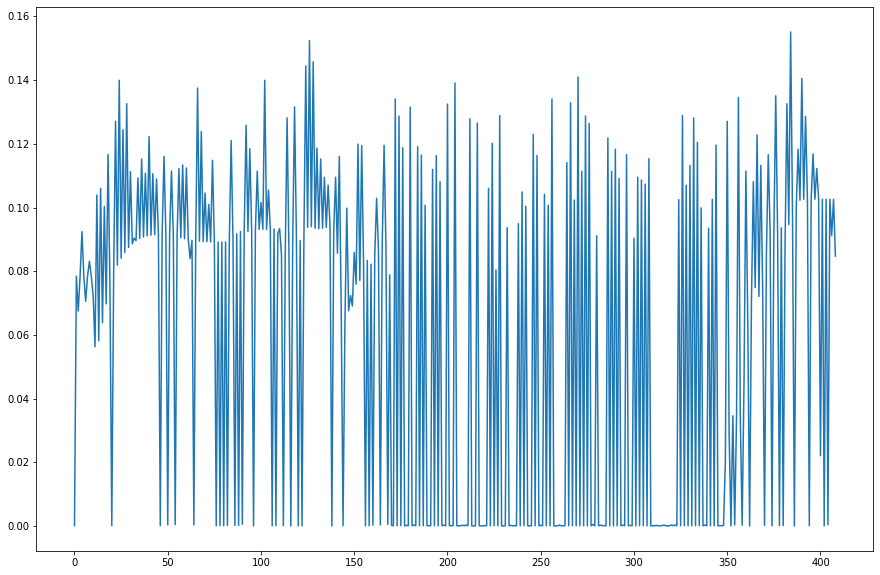

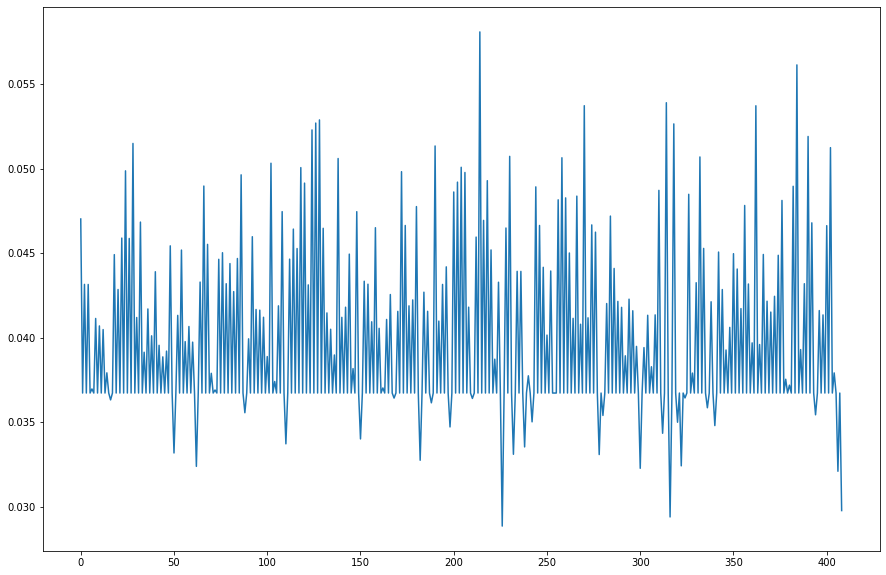

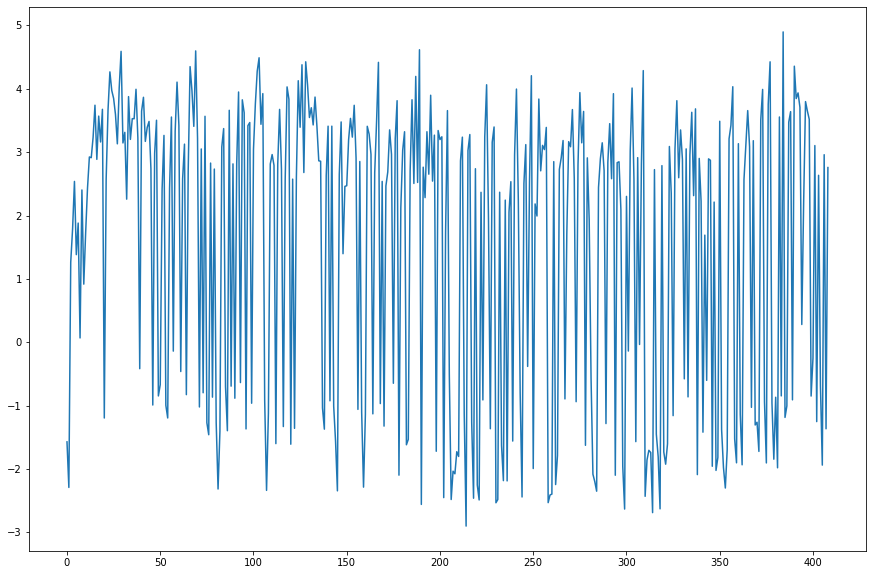

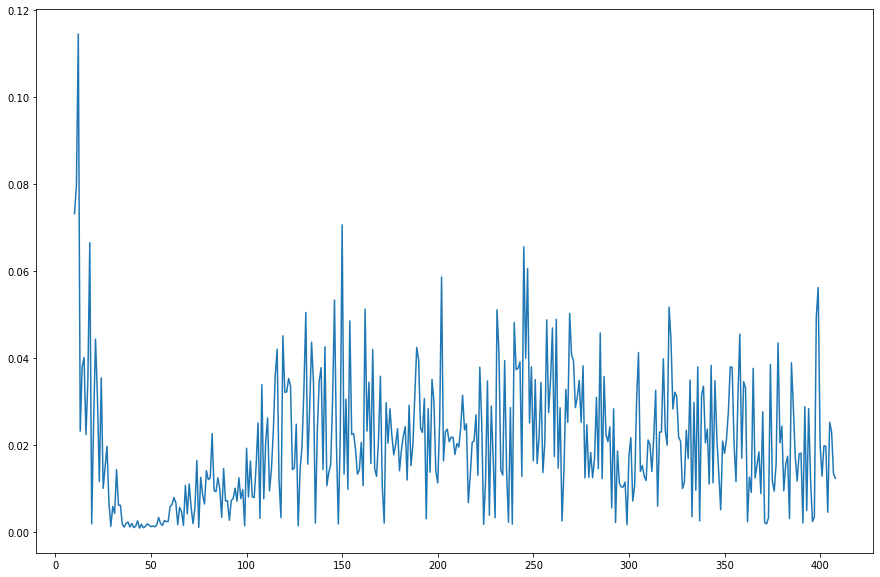

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):


      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            if episode > 990 or counter == 10:
              test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            if indicator:
              counter += 1
            else:
              counter = 0
          break

      if counter == 11:
        break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)

    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    err = 0.001
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0.1:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if (wsee - 0.11729630285067488) > 0: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP64_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.01)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.1)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.99)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 40
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

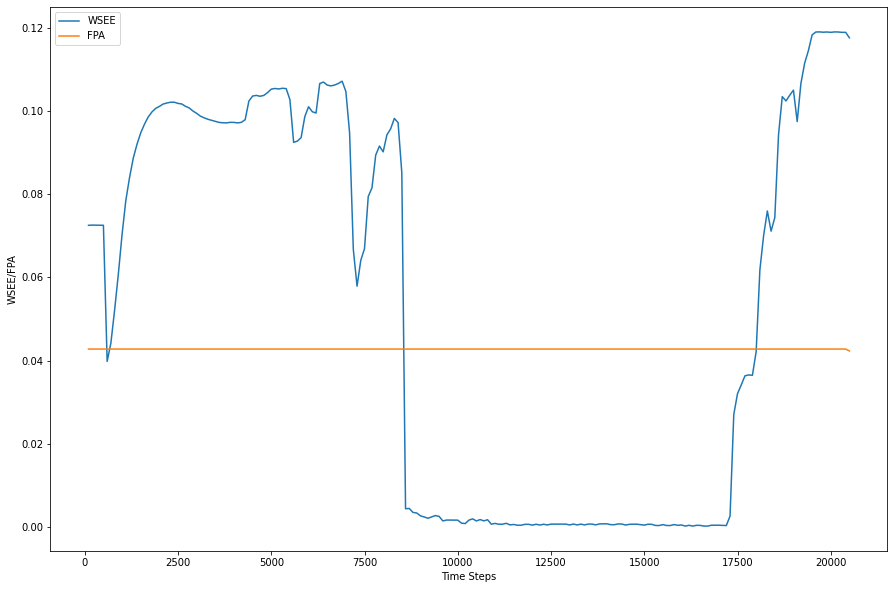

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

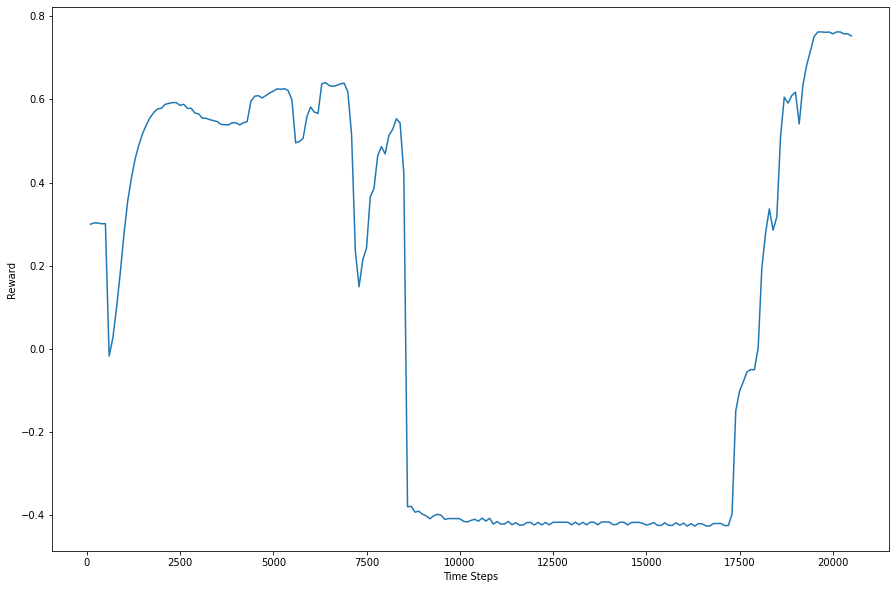

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
